# Genetic Algorithms

Lburgueno

In [ ]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Real Encoding

In [ ]:
def binaryTournamentSelection(population, fitness):
    """
    Binary tournament selection (deterministic)
    Select two random individuals and return the one with the higher fitness.
    """
    i, j = np.random.choice(len(population), 2, replace=False)
    if fitness[i] > fitness[j]:
        return population[i]
    else:
        return population[j]


In [ ]:
def simulatedBinaryCrossover(parent1, parent2, pc, eta_c=20):
    """
    Perform Simulated Binary Crossover (SBX) on two parents to produce two children.

    Inputs:
    - parent1, parent2: Parents for crossover.
    - pc: Crossover probability.
    - eta_c: Distribution index (higher values => closer to parents).
    """
    if np.random.rand() <= pc:
        child1, child2 = np.copy(parent1), np.copy(parent2)
        for i in range(len(parent1)):
            u = np.random.rand()
            if u <= 0.5:
                beta = (2*u)**(1/(eta_c + 1))
            else:
                beta = (1/(2*(1 - u)))**(1/(eta_c + 1))

            child1 = 0.5 *((parent1 + parent2) - beta*(np.abs(parent2 - parent1)))
            child2 = 0.5 *((parent1 + parent2) + beta*(np.abs(parent2 - parent1)))

        return child1, child2
    else:
        return parent1, parent2


In [ ]:
def parameterBasedMutation(individual, pm, nm=20, lowerBound=None, upperBound=None):
  if np.random.rand() <= pm:

      position = np.random.randint(0,len(individual))
      u = np.random.uniform(0, 1)
      delta = np.min([(individual[position] - lowerBound), (upperBound - individual[position])]) / (upperBound - lowerBound)
      eta_m = nm  # Mutation intensity parameter (from nm)

      if u <= 0.5:
          delta_q = (2 * u + (1 - 2 * u) * (1 - delta) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1
      else:
          delta_q = 1 - (2 * (1 - u) + 2 * (u - 0.5) * (1 - delta) ** (eta_m + 1)) ** (1 / (eta_m + 1))

      # Update the individual with the new mutated value
      individual[position] = individual[position] + delta_q * (upperBound - lowerBound)

      # Ensure the individual stays within the specified bounds
      individual[position] = np.clip(individual[position], lowerBound, upperBound)

  return individual

In [ ]:
def initializePopulation(miu, numVariables, lowerBound, upperBound):
    """
    Initialize population of real-encoded individuals within bounds.

    Inputs:
    - miu: Population size.
    - numVariables: Number of variables (dimensionality).
    - lowerBound, upperBound: Bounds for each variable.

    Returns:
    Population of real values.
    """
    return np.random.uniform(lowerBound, upperBound, (miu, numVariables))


In [ ]:
def obtainFitness(population, function):
    """
    Obtain fitness scores of the population.

    Inputs:
    - population: Population of individuals.
    - function: Function to optimize.

    Returns:
    Numpy array containing fitness scores of each individual.
    """
    fitness = np.array([1/function(ind) + 1e-9 for ind in population])  # Inverse fitness for minimization.
    return fitness


In [ ]:
def geneticAlgorithmReal(miu, numGenerations, pc, pm, lowerBound, upperBound, function, numVariables, verbose=True):
    """
    Genetic Algorithm for Real Encoding

    Inputs:
    - miu: Population size.
    - numGenerations: Number of generations.
    - pc: Crossover probability.
    - pm: Mutation probability.
    - lowerBound, upperBound: Bounds for variables.
    - function: Objective function to minimize.
    - numVariables: Number of variables (dimensions).
    - verbose: If True, plots convergence graph.

    Returns:
    - bestIndividual: Best individual found.
    - bestFitness: Fitness value of the best individual.
    - maxFitness: Maximum fitness reached.
    - bestPerGeneration: List of best fitness values per generation.
    """
    # Initialize population
    population = initializePopulation(miu, numVariables, lowerBound, upperBound)
    bestPerGeneration = []  # Track the best fitness for each generation
    bestIndividualperGeneration = []

    for generation in range(numGenerations):
        # Obtain fitness for the current population
        fitness = obtainFitness(population, function)
        bestPerGeneration.append(np.max(fitness))  # Max fitness in this generation
        bestIndividualperGeneration.append(population[np.argmax(fitness)])
        newPopulation = []

        for _ in range(miu // 2):  # Produce next generation
            parent1 = binaryTournamentSelection(population, fitness)
            parent2 = binaryTournamentSelection(population, fitness)

            # Perform crossover and mutation
            child1, child2 = simulatedBinaryCrossover(parent1, parent2, pc)
            child1 = parameterBasedMutation(child1, pm, lowerBound=lowerBound, upperBound=upperBound)
            child2 = parameterBasedMutation(child2, pm, lowerBound=lowerBound, upperBound=upperBound)

            newPopulation.append(child1)
            newPopulation.append(child2)

        # Update population
        population = np.array(newPopulation)

    if verbose:
        # Plotting the convergence
        plt.figure(figsize=(10, 6))
        plt.plot(range(numGenerations), bestPerGeneration)
        plt.title("Convergence Graph")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness")
        plt.show()

    # Return the best solution found
    bestIndividual = bestIndividualperGeneration[np.argmax(bestPerGeneration)]
    bestFitness= np.max(bestPerGeneration)
    return bestIndividual, function(bestIndividual), bestFitness, bestPerGeneration


## Binary Encoding

In [ ]:
def rouletteWheelSelection(population, fitness):
  """
  Algorithm for roulette Wheel selection

  inputs:
  population: array containing the population
  fitness: array containing fitness scores for each individual in the population

  returns:
  individual selected according to the algorithm
  """
  cumulatedFitness = np.sum(fitness) # Obtain fitness cummulative sum
  probabilities = [] # Probabilities of each individual to be selected
  cumulatedProbabilities = [] # Cumulated probabilities for each individual
  r = np.random.rand() # Random number to perform selection
  currentSum = 0
  for fit in fitness:
    probabilities.append(fit/cumulatedFitness)
    cumulatedProbabilities.append(currentSum + fit/cumulatedFitness)
    currentSum += fit/cumulatedFitness


  for i in range(1, len(cumulatedProbabilities)):
    if r < cumulatedProbabilities[i]:
      return population[i]


In [ ]:
def singlePointCrossover(parent1, parent2, pc):
  """
  Performs single point crossover to obtain two children from two parents

  Inputs:
  parent1, parent2: parents that will be used for crossover

  Outputs:
  child1, child2: Parents' offsprings
  """
  if np.random.rand() <= pc:
    point = np.random.randint(len(parent1)) # Randomly select crossover point
    child1 = np.concatenate([parent1[:point], parent2[point:]]) # Left part of parent1 + right part of parent2
    child2 = np.concatenate([parent2[:point], parent1[point:]]) # Left part of parent2 + right part of parent1
    return child1, child2
  else:
    return parent1,parent2

In [ ]:
def binaryMutation(individual, pm):
  """
  Perform binary mutation on an individual

  inputs:
  individual: individual to be mutated

  outputs:
  mutated individual
  """
  if np.random.rand() <= pm:
    position = np.random.randint(len(individual)) # Select random position
    individual[position] = 1 - individual[position] # 1-1=0 || 1-0=1
  return individual


In [ ]:
def decode(binary, lowerBound, upperBound, numBits):
  """
  Decode the binary string to a real number within the range specified

  Inputs:
  binary: array representing an individual in binary form
  lowerBound, upperBound: lower and upper bound of the function to evaluate
  numBits: number of bits of precision

  Returns:
  Real value
  """
  decimal = int("".join(str(int(bit)) for bit in binary), 2) # Convert the binary array to a string and then into an integer (2 because it's in binary)
  maxValue = 2**numBits-1 #Obtain the maximum value possible to scale the decimal value obtained
  return lowerBound + (decimal/maxValue) * (upperBound-lowerBound) # Scale the value and multiply it by the possible range, then add the lower bound to obtain a value within the range

In [ ]:
def obtainFitnessBinary(population, lowerBound, upperBound, numBits, function, numVariables):
  """
  Obtain fitness scores of the population

  Inputs:
  population: Population of individuals
  lowerBound, upperBound: lower and upper bound of the function to evaluate
  numBits: number of bits of precision
  function: function to optimize

  Returns:
  Numpy array containing fitness scores of each individual

  """
  fitness = []
  for individual in population:
    xValues = []
    for i in range(numVariables):
      xValues.append(decode(individual[i*numBits:(i+1)*numBits], lowerBound, upperBound, numBits))
    fitness.append(1/function(xValues) + 1e-9) # Use inverse because we are minimizing and substraction didn't work, add 1e-9 so there are no divisions by zero
  return np.array(fitness)

In [ ]:
def geneticAlgorithmBinary(miu, numBits, numGenerations, pc, pm, lowerBound, upperBound, function, numVariables, verbose=True):
  population = np.random.randint(0,2, (miu, numBits*numVariables)) #Generate population
  bestPerGeneration = [] # Best fitness for each generation
  bestIndividualperGeneration = []

  for generation in range(numGenerations):
    fitness = obtainFitnessBinary(population, lowerBound, upperBound, numBits, function, numVariables)
    bestPerGeneration.append(np.max(fitness))
    bestIndividualperGeneration.append(population[np.argmax(fitness)])
    newPopulation = []


    for _ in range(miu//2):
      parent1 = rouletteWheelSelection(population, fitness)
      parent2 = rouletteWheelSelection(population, fitness)

      child1, child2 = singlePointCrossover(parent1, parent2, pc)

      child1 = binaryMutation(child1, pm)
      child2 = binaryMutation(child2, pm)

      newPopulation.append(child1)
      newPopulation.append(child2)

    population=np.array(newPopulation)

  if verbose:
    plt.figure(figsize=(10, 6))
    plt.plot(range(numGenerations), bestPerGeneration)
    plt.title("Convergence Graph")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.show()

  # Return the best solution found
  bestIndividual = bestIndividualperGeneration[np.argmax(bestPerGeneration)]
  bestFitness= np.max(bestPerGeneration)
  xValues = []
  for i in range(numVariables):
    xValues.append(decode(bestIndividual[i*numBits:(i+1)*numBits], lowerBound, upperBound, numBits))
  return xValues, function(xValues), bestFitness, bestPerGeneration


## Function definitions

In [ ]:
def rastringin(x):
  return 10 * len(x) + np.sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])

In [ ]:
#Define problems with jacobian and hessian for the other methods
def function1(x):
  return 100 * (x[0]**2 - x[1])**2 + (1-x[0])**2

def jacobian1(x):
  dx1 = 400*x[0]*(x[0]**2-x[1]) + 2*(x[0]-1)
  dx2 = -200*(x[0]**2-x[1])
  return np.array([dx1, dx2])

def hessian1(x):
  d2x1_dx1 = 400*(3*x[0]**2 - x[1])+2 # Partial derivative of dx1 with respect to x1
  d2x1_dx2 = -400*x[0] # Partial derivative of dx1 with respect to x2
  d2x2_dx1 = -400*x[0] # Partial derivative of dx2 with respect to x1
  d2x2_dx2 = 200 # Partial derivative of dx2 with respect to x2
  return np.array([[d2x1_dx1, d2x1_dx2], [d2x2_dx1, d2x2_dx2]])

def function2(x):
  return 20 + (x[0]**2 - (10*np.cos(2*np.pi*x[0]))) + (x[1]**2 - (10*np.cos(2*np.pi*x[1])))  #since A=10 and n=2 we can define it like this

def jacobian2(x):
    dx1 =  2*x[0] + 20*np.pi*np.sin(2*np.pi*x[0])
    dx2 = 2*x[1] + 20*np.pi*np.sin(2*np.pi*x[1])
    return np.array([dx1, dx2])

def hessian2(x):
    d2x1_dx1 = 2 + 40*np.pi**2*np.cos(2*np.pi*x[0])
    d2x1_dx2 = 0
    d2x2_dx1 = 0
    d2x2_dx2 = 2 + 40*np.pi**2*np.cos(2*np.pi*x[1])

    return np.array([[d2x1_dx1, d2x1_dx2], [d2x2_dx1, d2x2_dx2]])

### Problem 1

Problem 1
Run 0


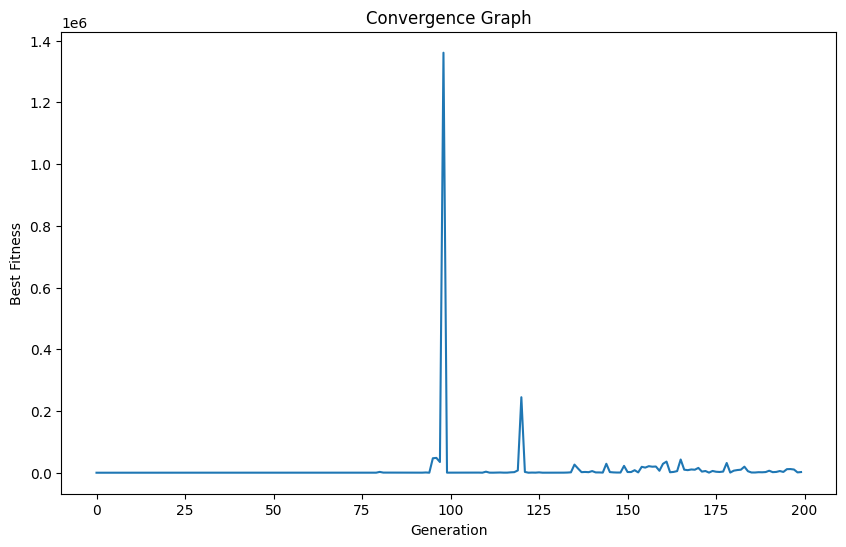

Best X: [0.99924363 0.99844747], Best Evaluation: 7.349392024044421e-07, Best Fit: 1360656.7682447478
Run 1


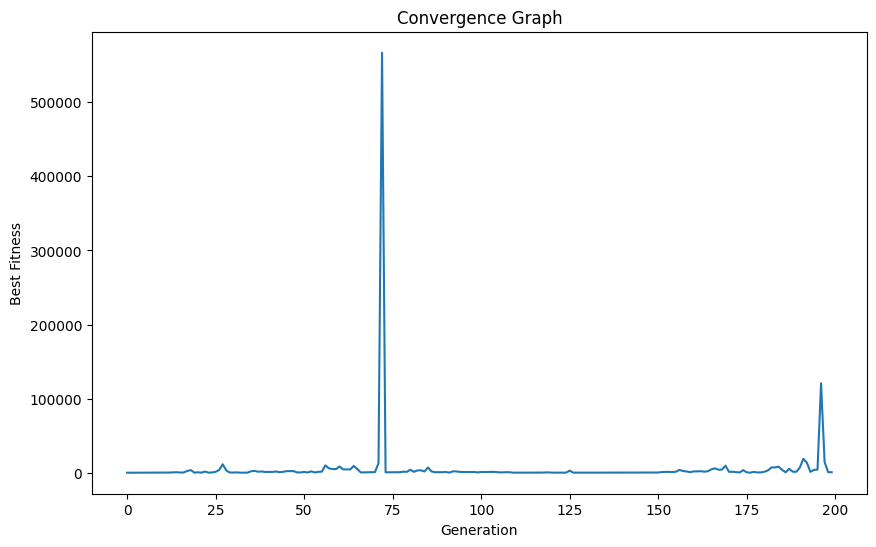

Best X: [1.00132527 0.8946166 ], Best Evaluation: 1.1671731618538477, Best Fit: 566875.8965442672
Run 2


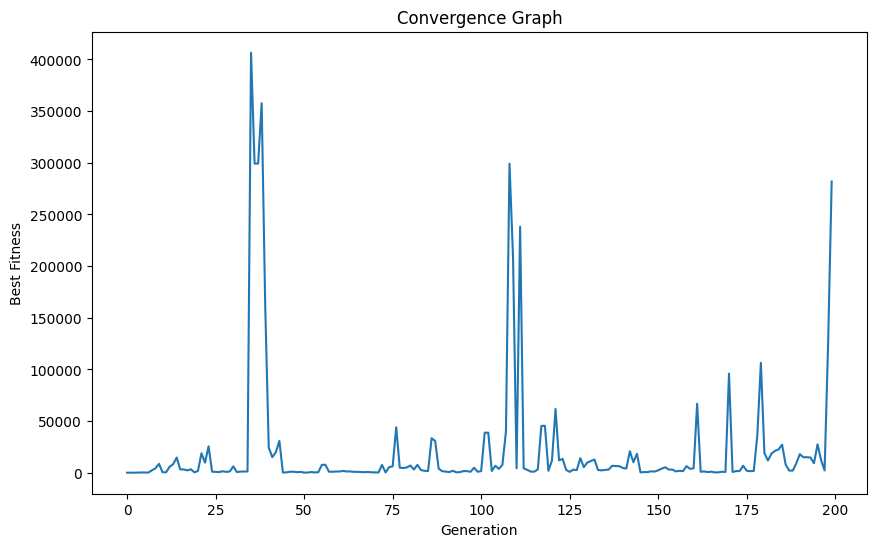

Best X: [1.00011206 1.00006768], Best Evaluation: 2.4599843417804773e-06, Best Fit: 406506.6525082947
Run 3


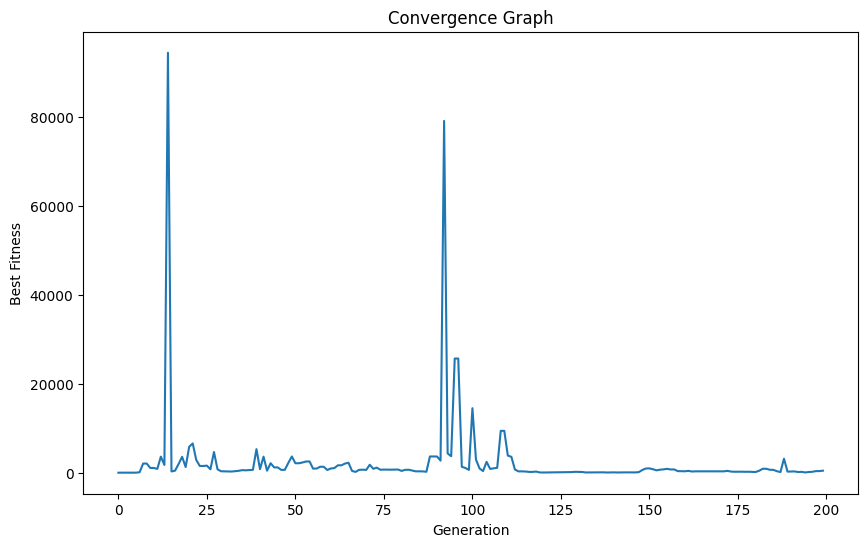

Best X: [0.99997124 1.00026795], Best Evaluation: 1.0594356868931135e-05, Best Fit: 94389.87305898641
Run 4


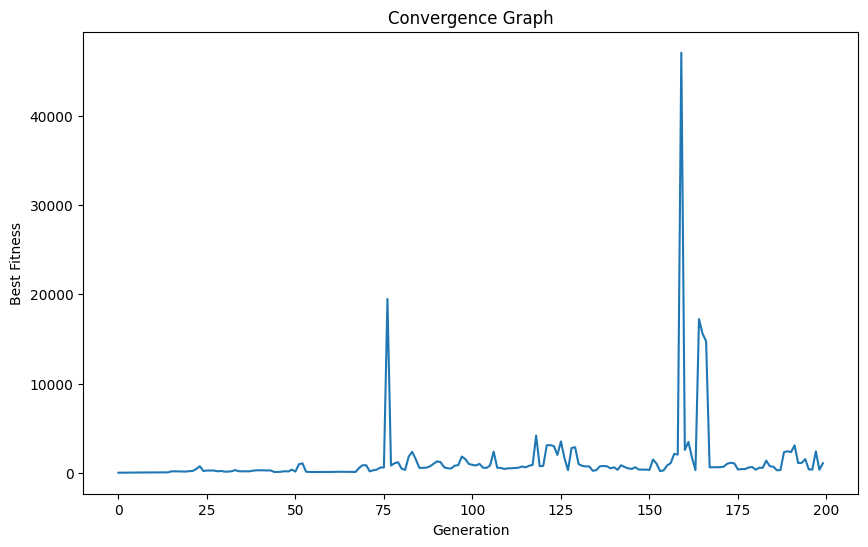

Best X: [1.00322858 1.00613876], Best Evaluation: 2.123598394338442e-05, Best Fit: 47089.88303372437
Run 5


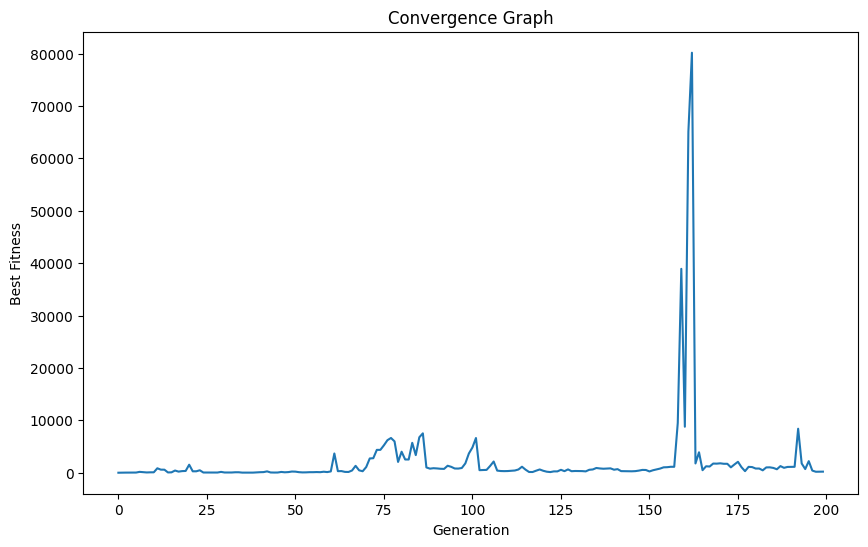

Best X: [0.99789458 0.99607718], Best Evaluation: 1.2475681022179921e-05, Best Fit: 80155.94485160048
Run 6


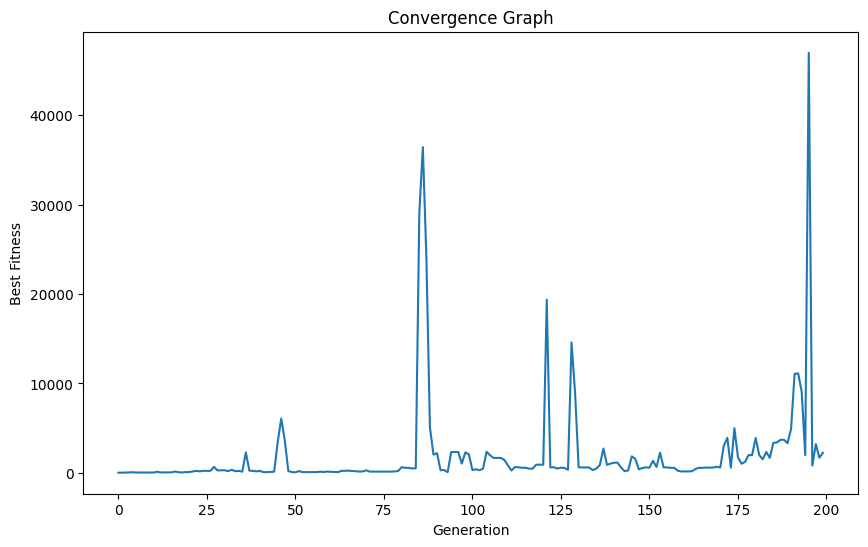

Best X: [0.99656304 0.99283031], Best Evaluation: 2.1273348394989044e-05, Best Fit: 47007.174490479934
Run 7


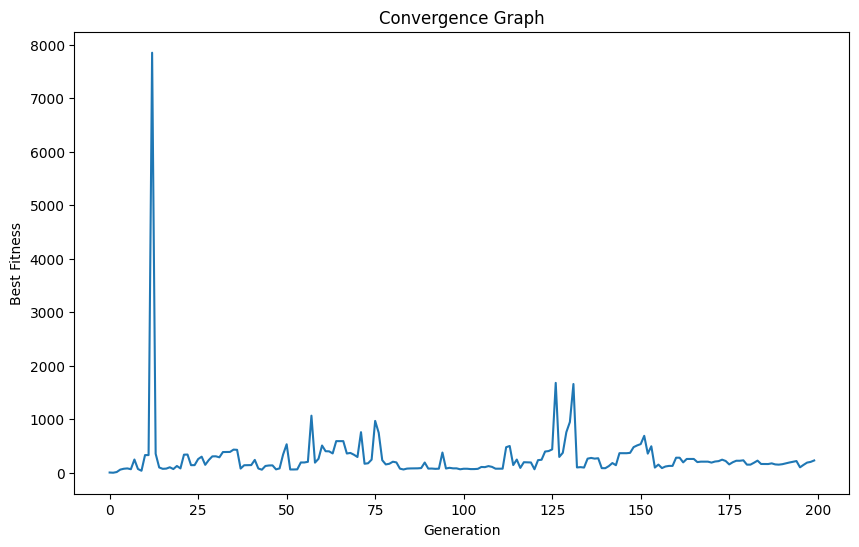

Best X: [0.99945769 0.99778806], Best Evaluation: 0.0001274447945935822, Best Fit: 7846.534675575404
Run 8


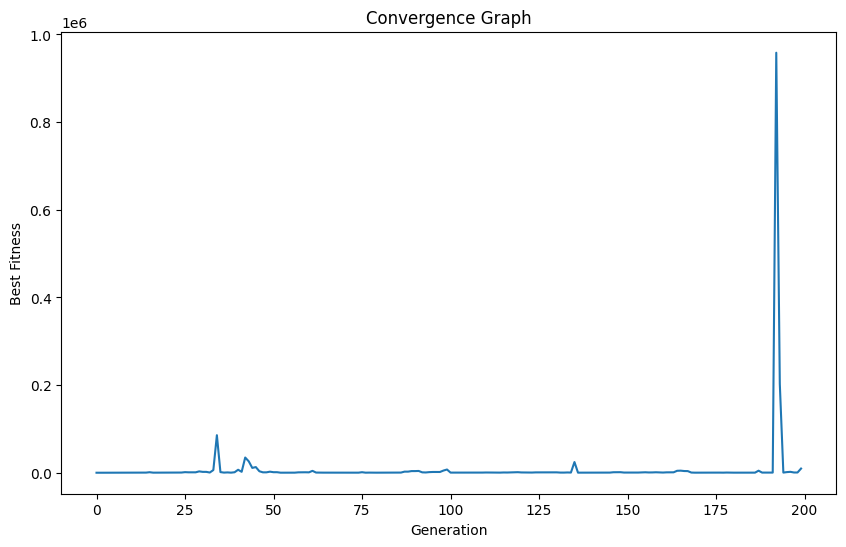

Best X: [0.99922506 0.99838417], Best Evaluation: 1.0434438964976895e-06, Best Fit: 958364.8947073173
Run 9


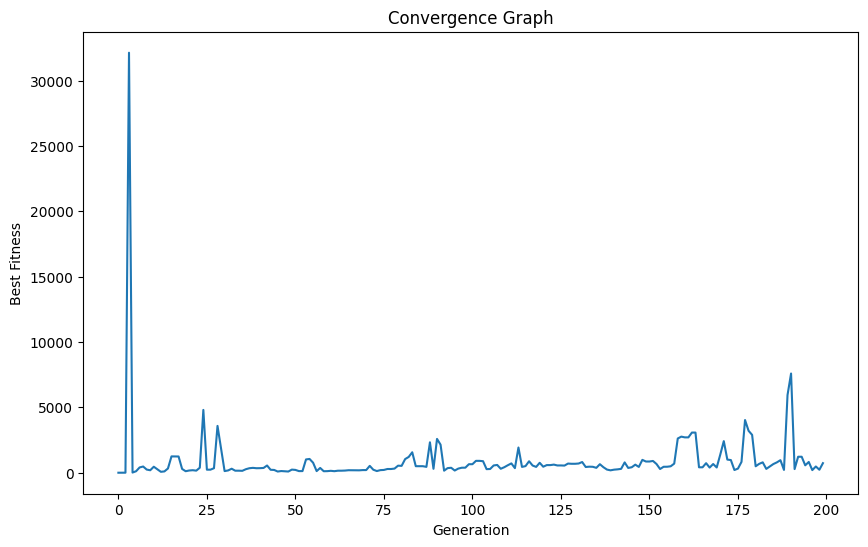

Best X: [1.00027994 1.00000276], Best Evaluation: 3.1124794392013286e-05, Best Fit: 32128.726294707158
Run 10


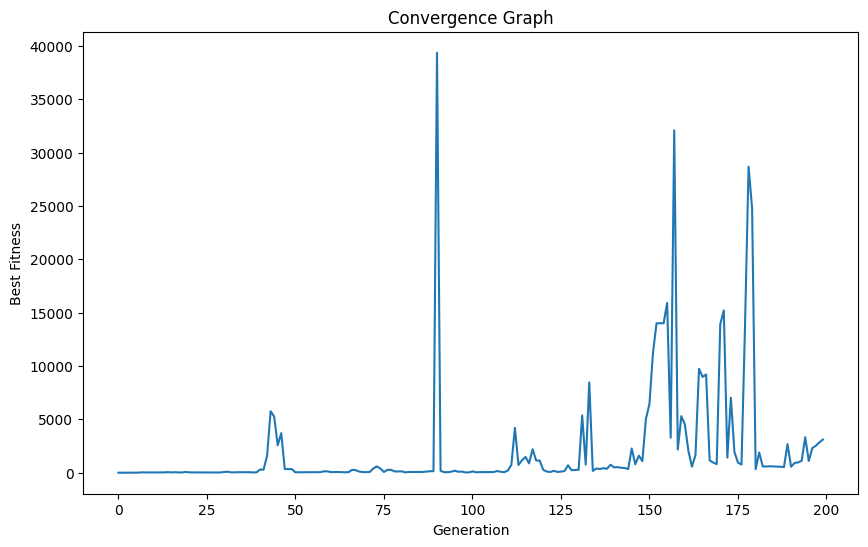

Best X: [0.99517782 0.9905259 ], Best Evaluation: 2.5414683993597077e-05, Best Fit: 39347.33165487965
Run 11


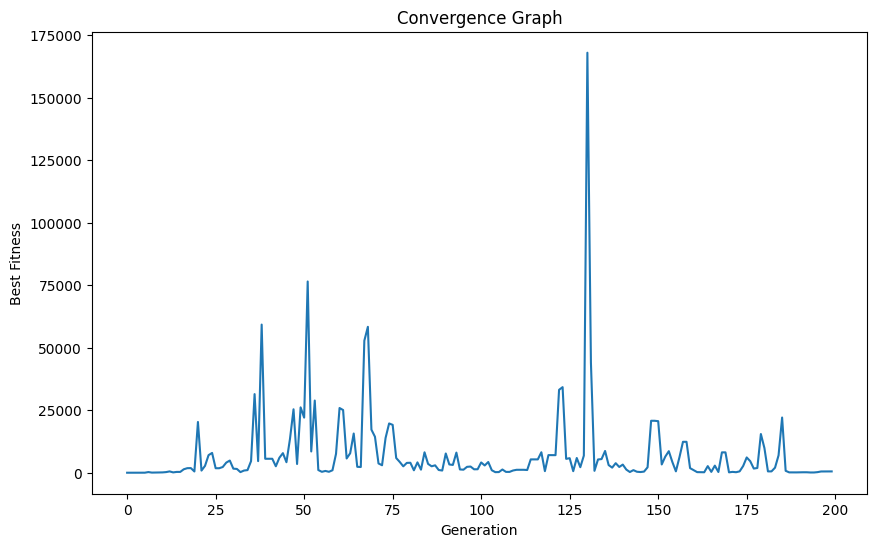

Best X: [0.99782829 0.99577256], Best Evaluation: 5.954569048606136e-06, Best Fit: 167938.26586561944
Run 12


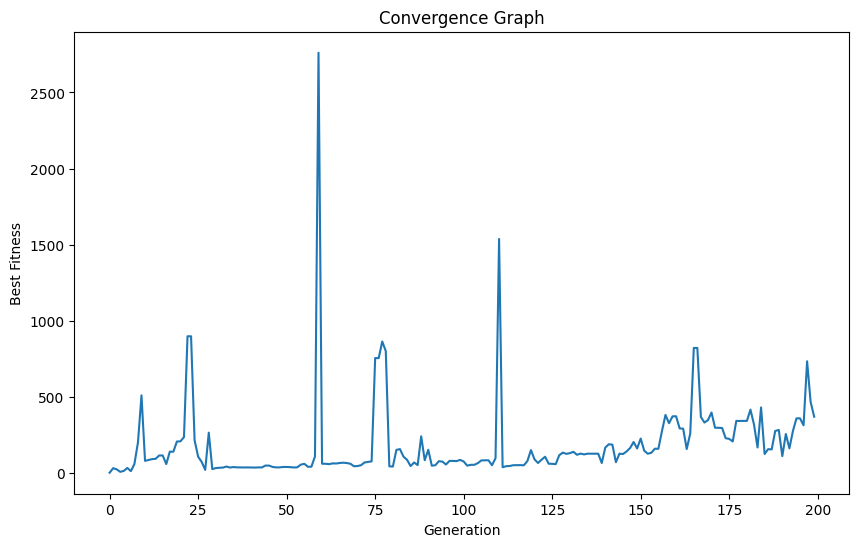

Best X: [1.0078384  1.01747253], Best Evaluation: 0.0003622197399205378, Best Fit: 2760.755115719916
Run 13


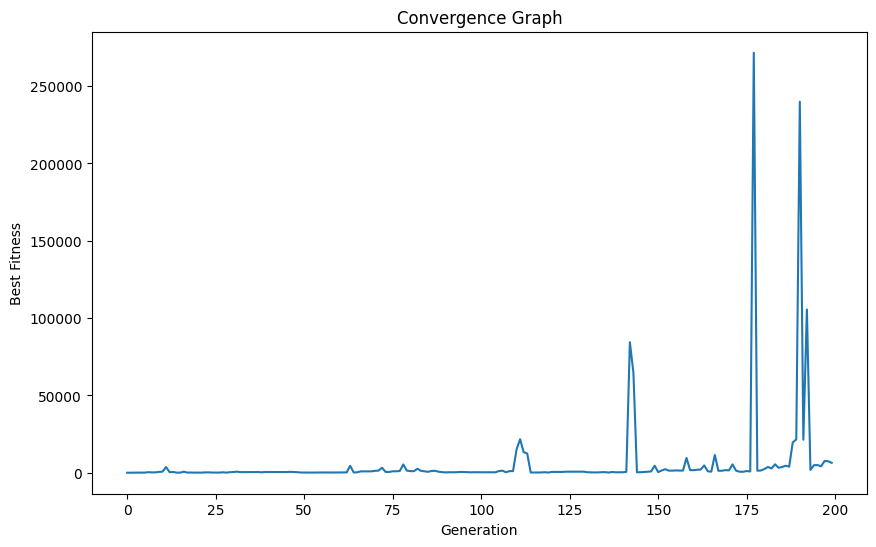

Best X: [0.99916934 0.99816642], Best Evaluation: 3.6812279950712435e-06, Best Fit: 271648.48288095515
Run 14


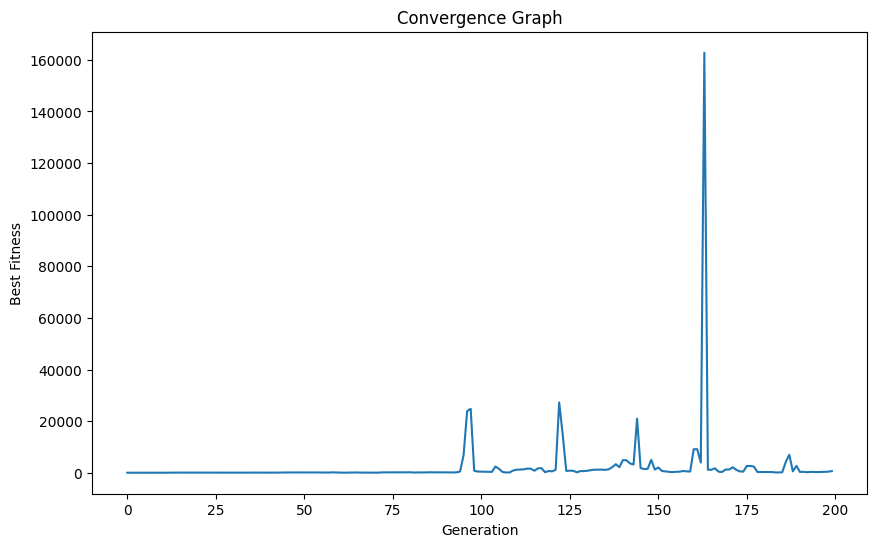

Best X: [1.00146172 1.21125751], Best Evaluation: 4.340221793383725, Best Fit: 162754.00677530456
Run 15


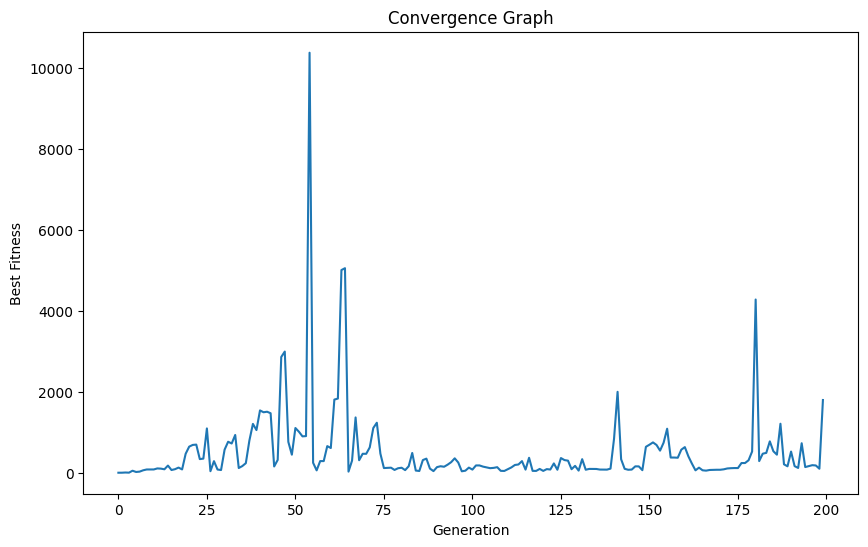

Best X: [1.00898021 1.01764568], Best Evaluation: 9.62768994353348e-05, Best Fit: 10386.707568119753
Run 16


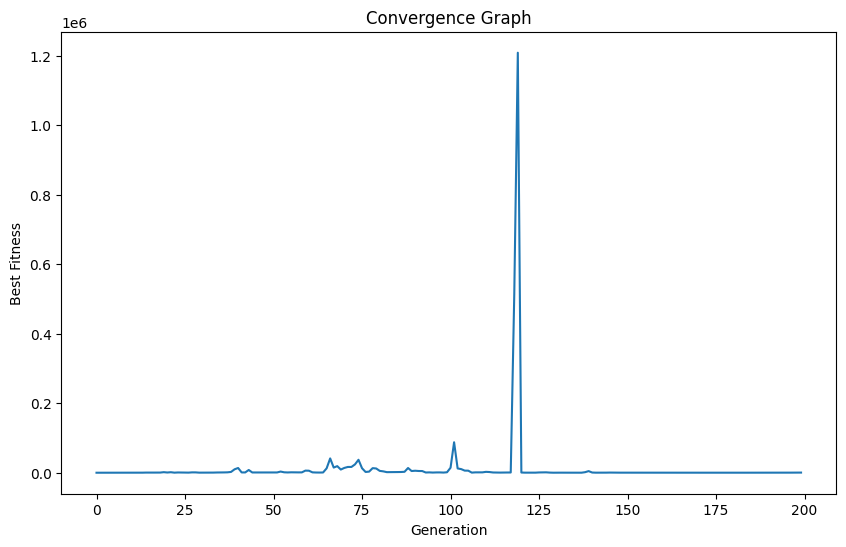

Best X: [0.99982159 0.99973239], Best Evaluation: 8.269957195578113e-07, Best Fit: 1209196.101443782
Run 17


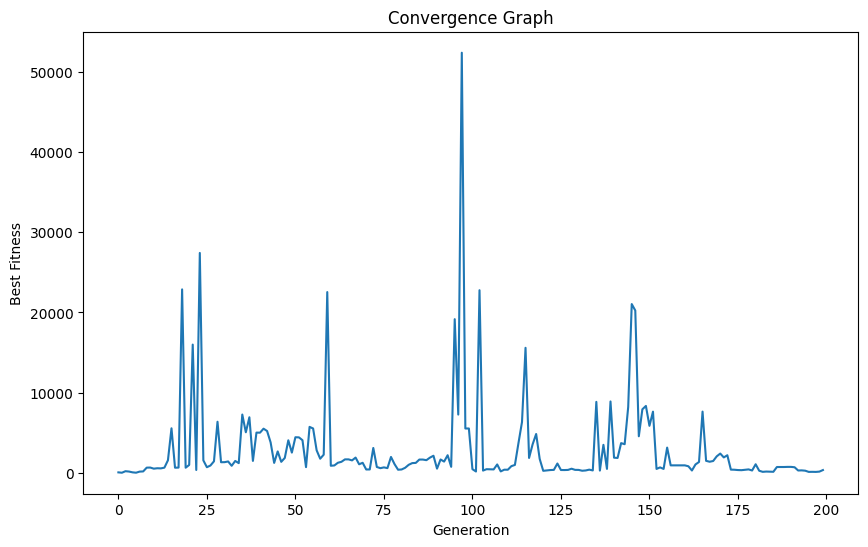

Best X: [1.00396198 1.00775544], Best Evaluation: 1.9090460200116433e-05, Best Fit: 52382.18406038845
Run 18


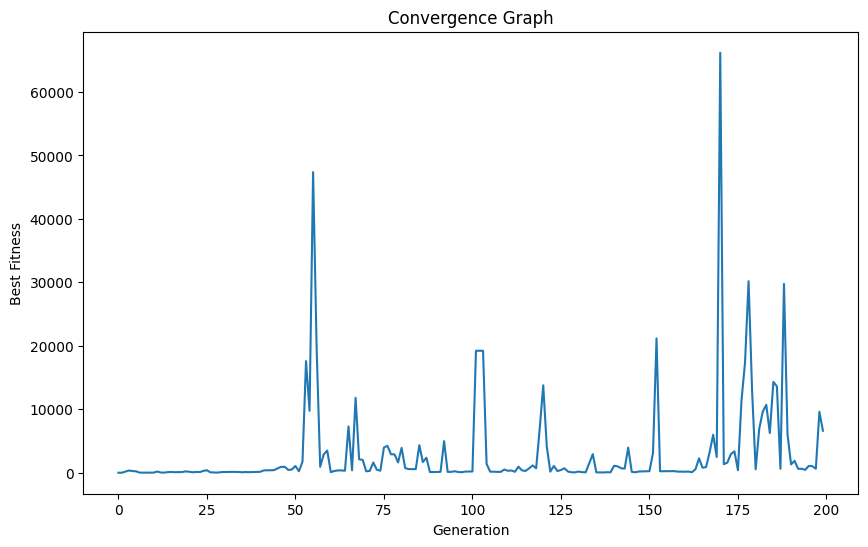

Best X: [1.25097325 0.99551777], Best Evaluation: 32.48648035045832, Best Fit: 66176.27074549149
Run 19


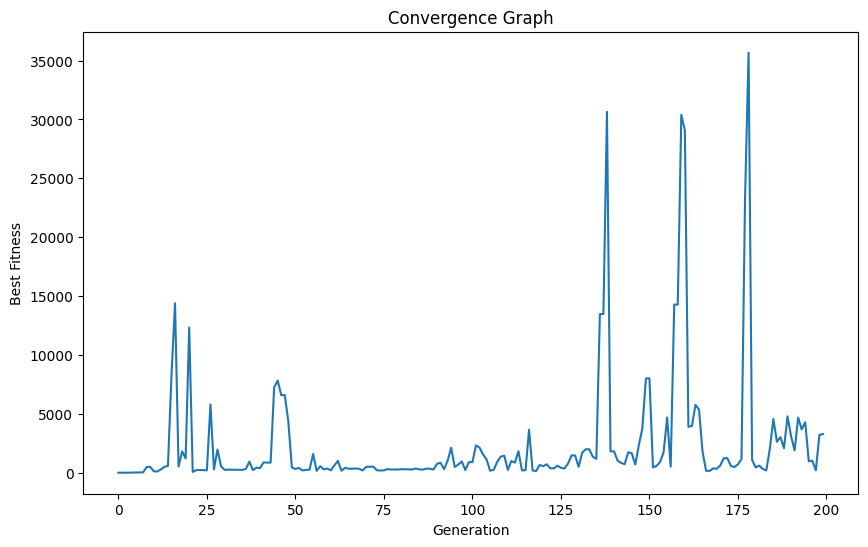

Best X: [0.99516954 0.99014552], Best Evaluation: 2.8037412203409412e-05, Best Fit: 35666.629742613186
Mean Fitness: 280963.9542131288
Standard Deviation: 406151.80759833765
Min: 2760.755115719916
Max: 1360656.7682447478


In [ ]:
#Parameters
miu = 100
upperBound = 2.048
lowerBound = -2.048
numBits = 16 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 2
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem1Real = []
bestPerGenerationperRunProblem1Real = []

print("Problem 1")
for i in range(20):
  print("Run", i)
  bestX, bestEvaluation, bestFit, bestPerGeneration = geneticAlgorithmReal(
    miu=100,
    numGenerations=200,
    pc=0.9,
    pm=1/numVariables,
    lowerBound=lowerBound,
    upperBound=upperBound,
    function=function1,  # Pass function1
    numVariables=numVariables,
    verbose=True
)
  bestFitnessRunsProblem1Real.append(bestFit)
  bestPerGenerationperRunProblem1Real.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem1Real, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem1Real, axis=0))
print("Min:", np.min(bestFitnessRunsProblem1Real))
print("Max:", np.max(bestFitnessRunsProblem1Real))

Problem 1
Run 0


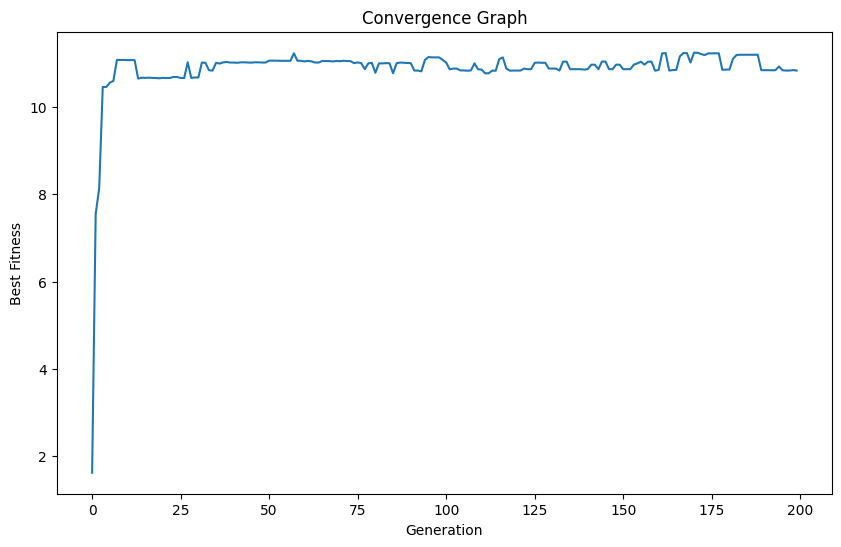

Best X: [0.7019794613565269, 0.49141374837872887], Best Evaluation: 0.08900158674803776, Best Fit: 11.235754739069849
Run 1


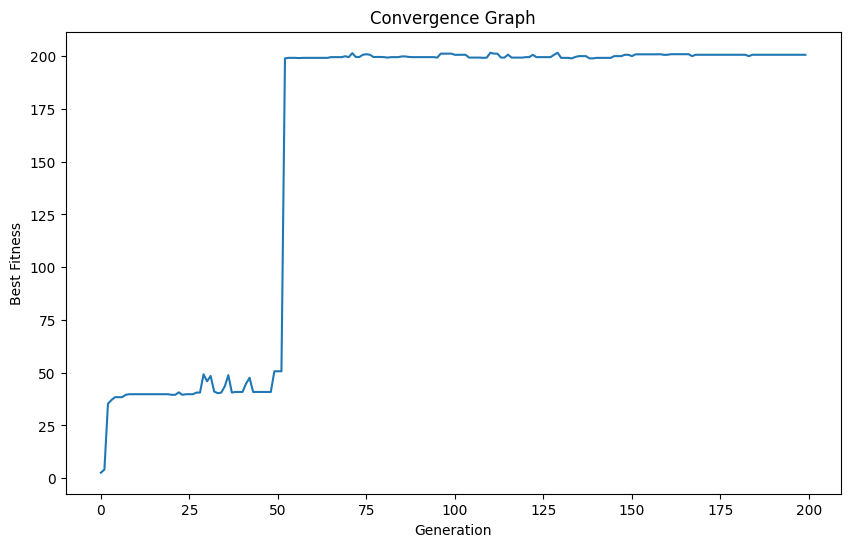

Best X: [0.9296704356450749, 0.8639194323643857], Best Evaluation: 0.004959766962120214, Best Fit: 201.62237614032517
Run 2


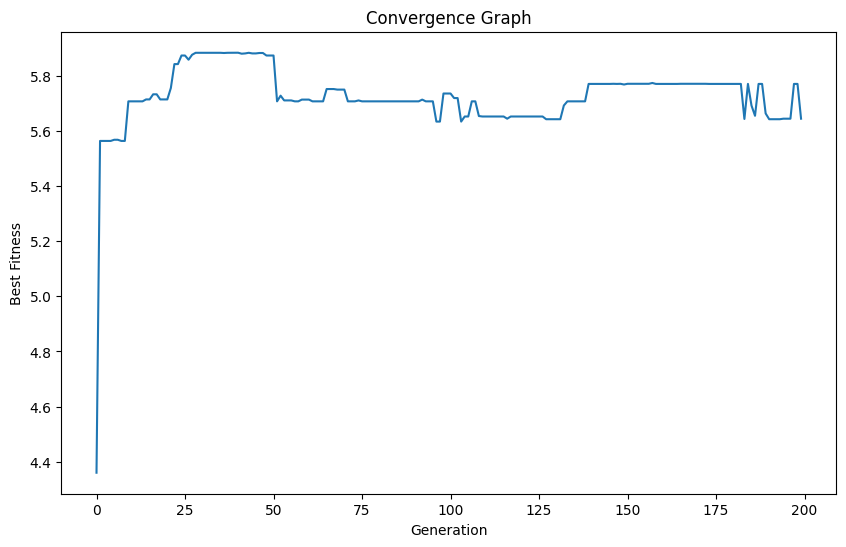

Best X: [1.4123028000305182, 1.9945616845960172], Best Evaluation: 0.16999373964586137, Best Fit: 5.882569571404447
Run 3


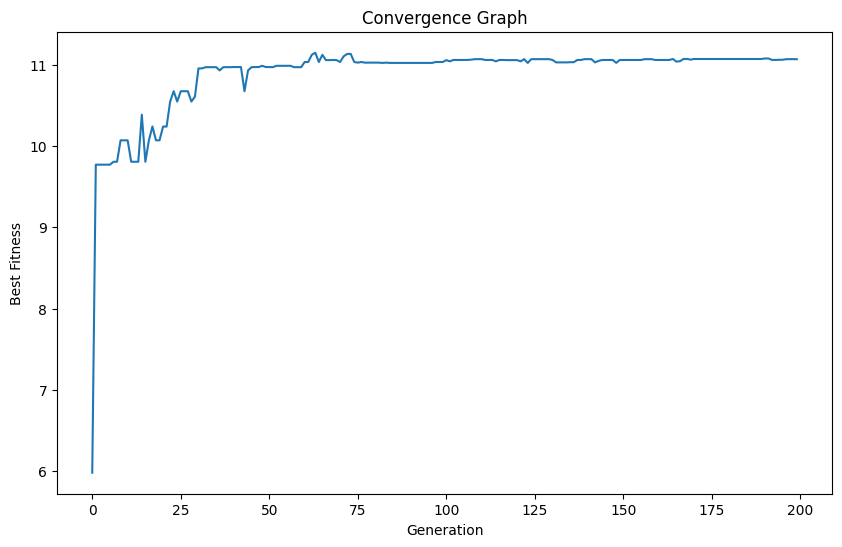

Best X: [1.299238574807355, 1.6893695277332723], Best Evaluation: 0.08972561126982528, Best Fit: 11.145089857147905
Run 4


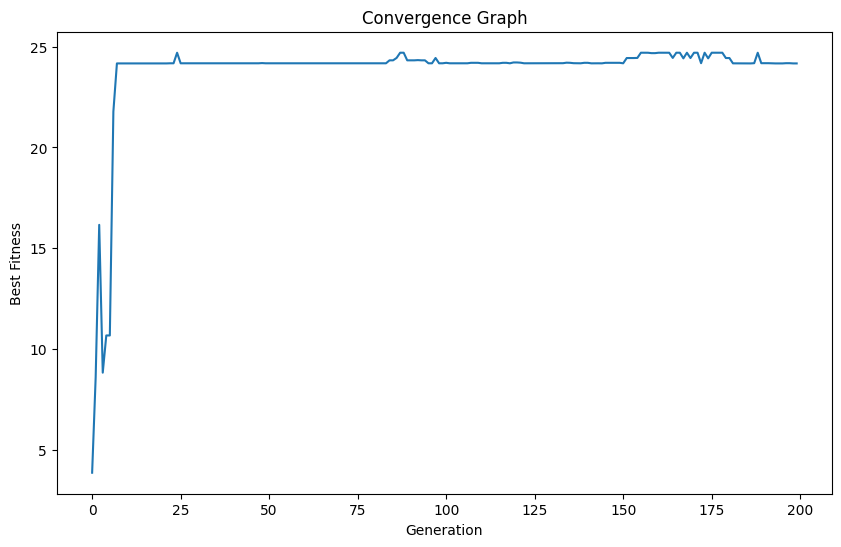

Best X: [0.7987934386205842, 0.6379784847791257], Best Evaluation: 0.04048493546407976, Best Fit: 24.700545735777062
Run 5


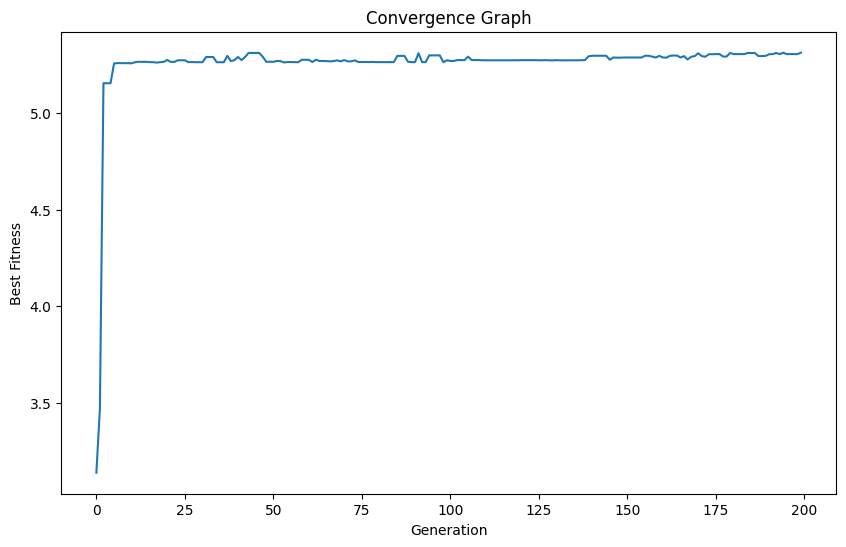

Best X: [0.5662273899443044, 0.31984863050278456], Best Evaluation: 0.18821717321045087, Best Fit: 5.313011470372522
Run 6


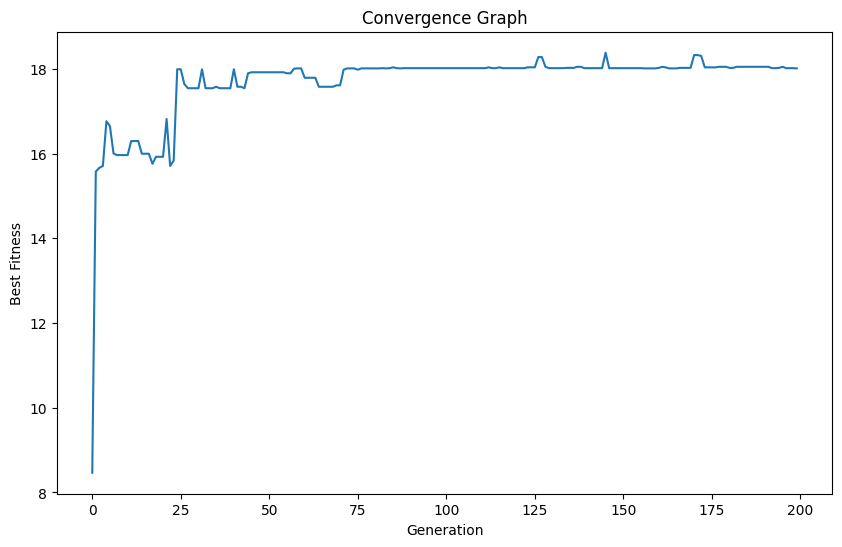

Best X: [0.767605462729839, 0.5912277714198524], Best Evaluation: 0.05441108021995342, Best Fit: 18.378609577534082
Run 7


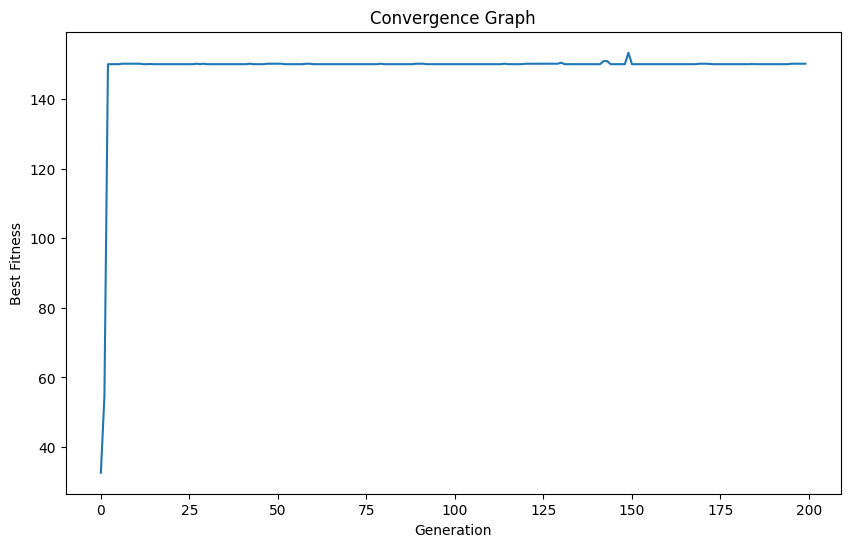

Best X: [1.080485236896315, 1.1681115739681087], Best Evaluation: 0.006521860339364291, Best Fit: 153.33048363068679
Run 8


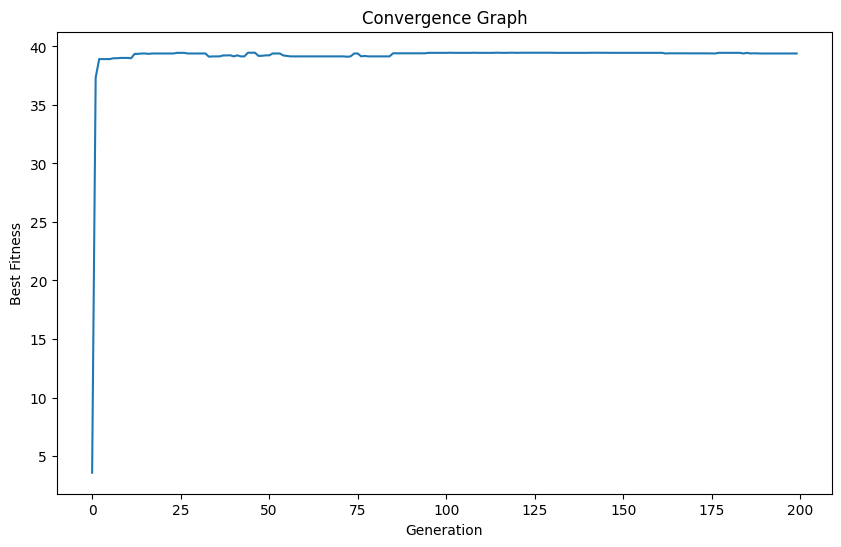

Best X: [1.1591114366369117, 1.3440517586022738], Best Evaluation: 0.02534270834019912, Best Fit: 39.45908174459484
Run 9


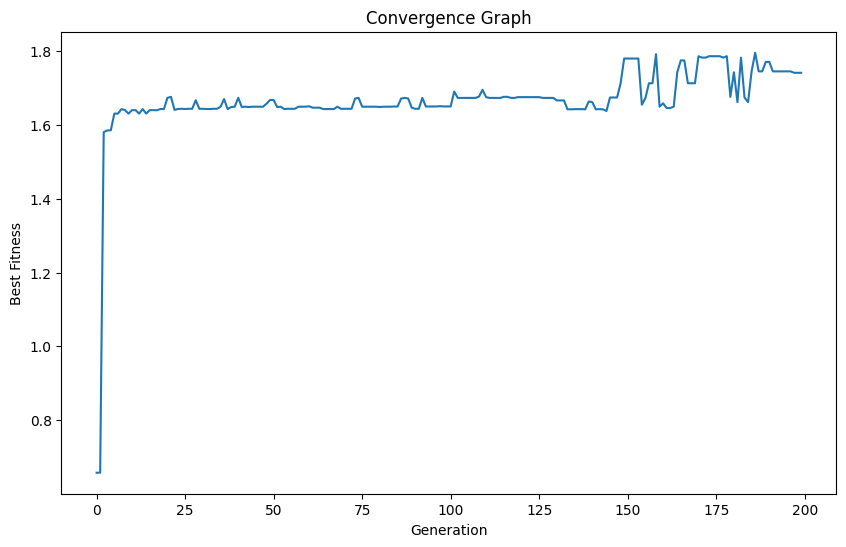

Best X: [0.2559101548790723, 0.05996966506446899], Best Evaluation: 0.5567171155293645, Best Fit: 1.7962443989275398
Run 10


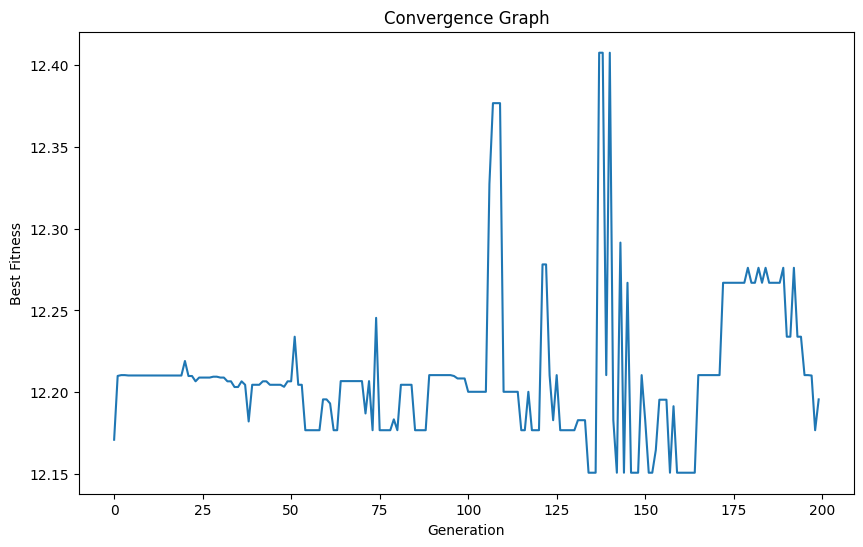

Best X: [1.2829258258945604, 1.6482439002059968], Best Evaluation: 0.0805970312033592, Best Fit: 12.407404902513557
Run 11


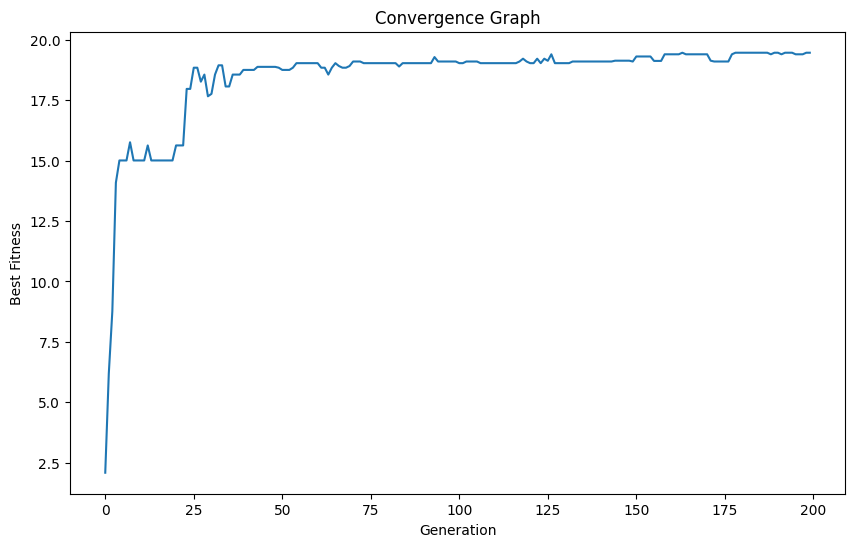

Best X: [1.2160498054474709, 1.4719287098496983], Best Evaluation: 0.05136760337010769, Best Fit: 19.467522999784272
Run 12


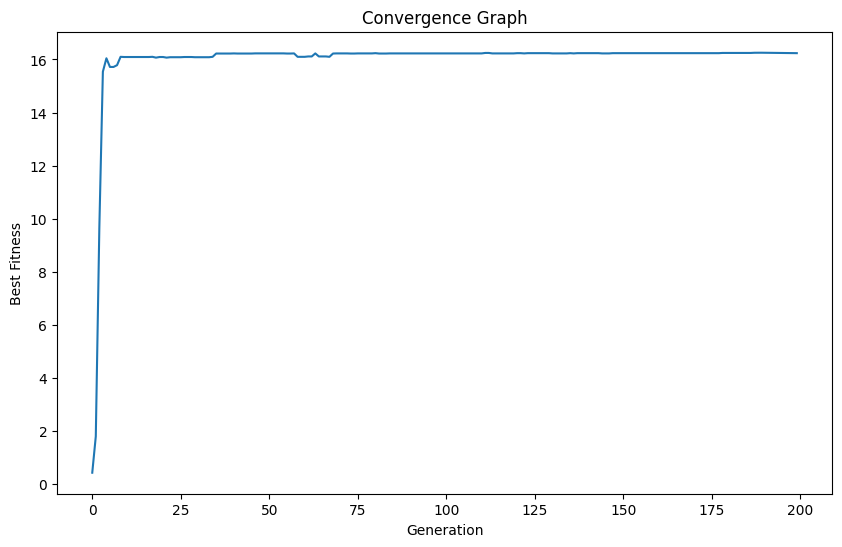

Best X: [1.2480502937361715, 1.5576175173571372], Best Evaluation: 0.06152896266664532, Best Fit: 16.25250868407093
Run 13


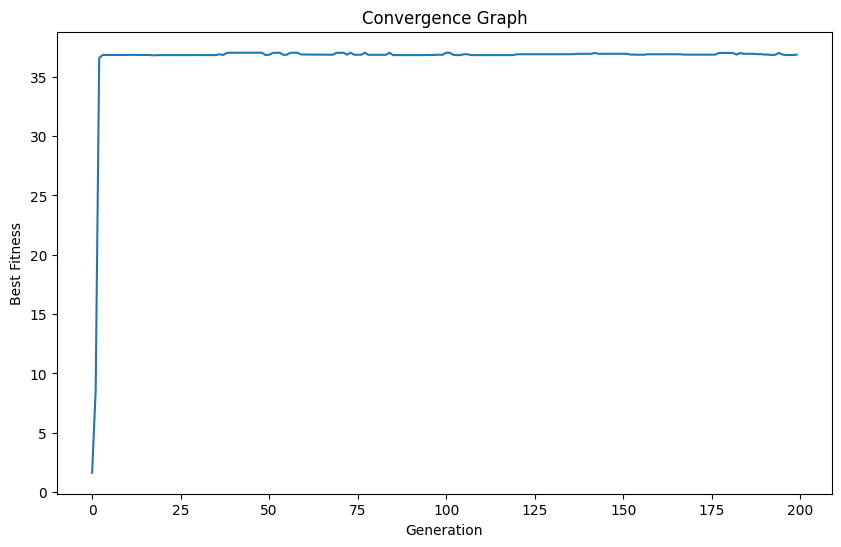

Best X: [1.164236514839399, 1.3560519417105366], Best Evaluation: 0.027010269100631503, Best Fit: 37.022955835846524
Run 14


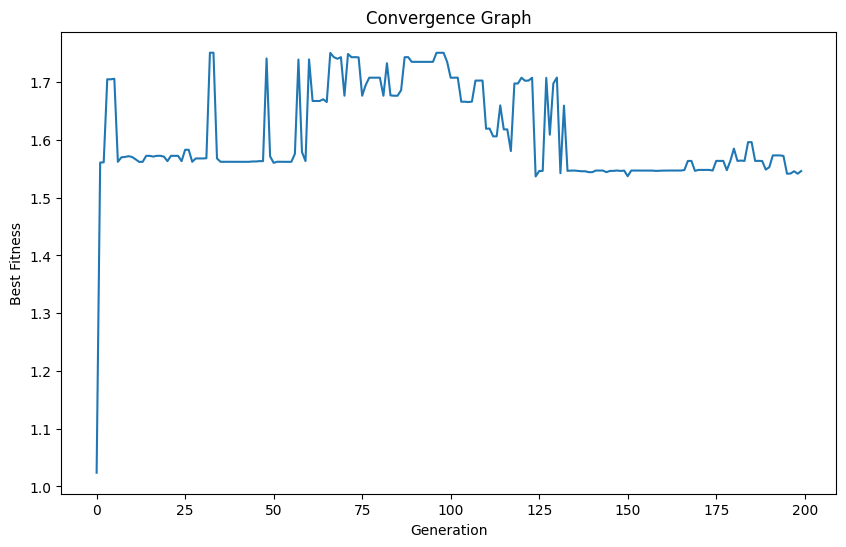

Best X: [0.24497248798352045, 0.056844617380025664], Best Evaluation: 0.5710694710391585, Best Fit: 1.7511004374851253
Run 15


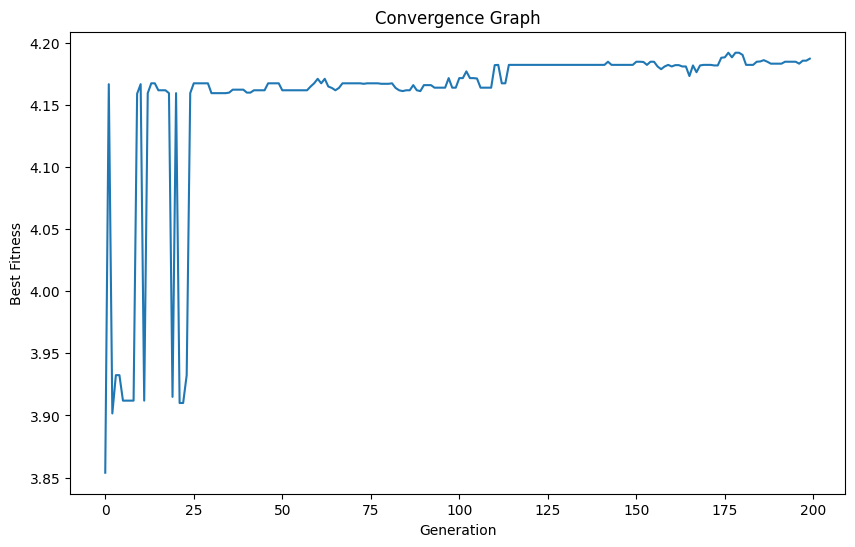

Best X: [0.5116015564202336, 0.26216025024795897], Best Evaluation: 0.23855102557843985, Best Fit: 4.19197527159544
Run 16


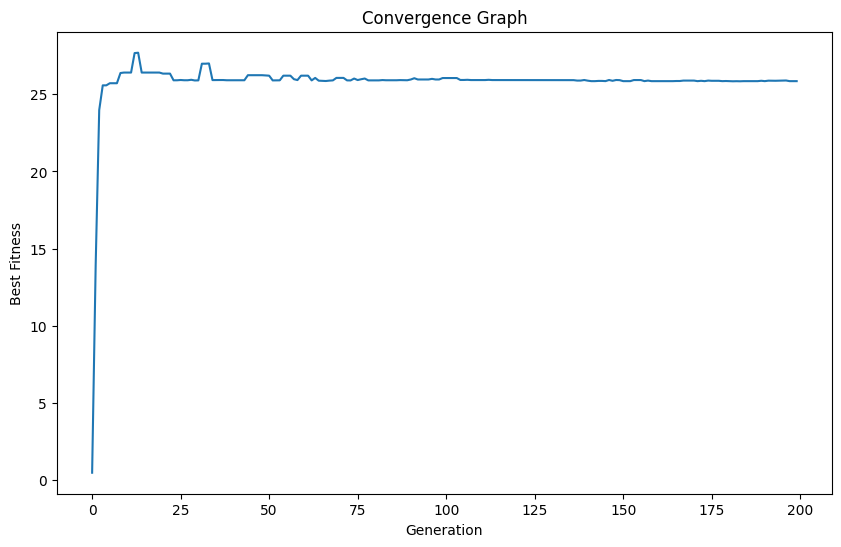

Best X: [0.8115436331731134, 0.6561662623025866], Best Evaluation: 0.03610960466331996, Best Fit: 27.693462981939177
Run 17


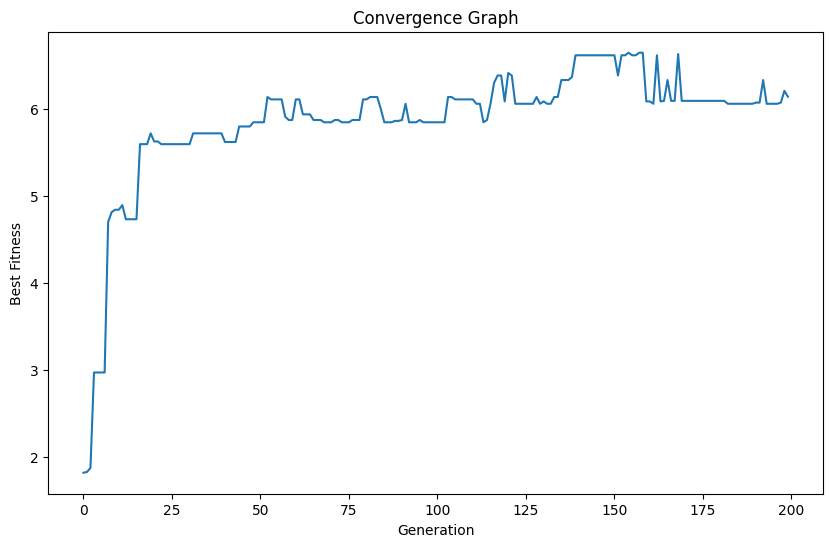

Best X: [1.2795507743953611, 1.6641191424429693], Best Evaluation: 0.15034272687160183, Best Fit: 6.651469086392049
Run 18


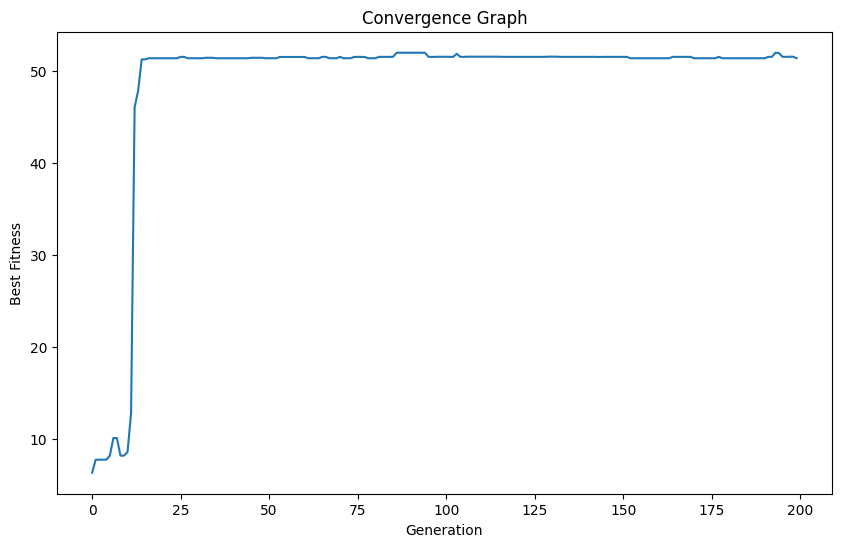

Best X: [1.1382361181048295, 1.2966760357061111], Best Evaluation: 0.019229033824101707, Best Fit: 52.00469296412736
Run 19


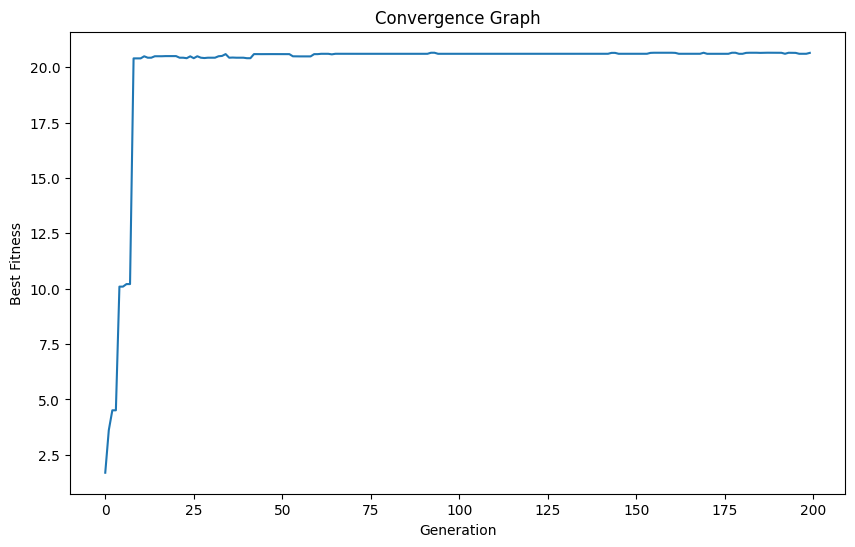

Best X: [1.2200498664835586, 1.4885539635309377], Best Evaluation: 0.04842204798333489, Best Fit: 20.65174939301588
Mean Fitness: 33.54793047113053
Standard Deviation: 50.30135884246721
Min: 1.7511004374851253
Max: 201.62237614032517


In [ ]:
#Parameters
miu = 100
upperBound = 2.048
lowerBound = -2.048
numBits = 16 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 2
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem1Binary = []
bestPerGenerationperRunProblem1Binary = []

print("Problem 1")
for i in range(20):
  print("Run", i)
  bestX, bestEvaluation, bestFit, bestPerGeneration = geneticAlgorithmBinary(miu, numBits, numGenerations, pc, pm, lowerBound, upperBound, function1, numVariables)
  bestFitnessRunsProblem1Binary.append(bestFit)
  bestPerGenerationperRunProblem1Binary.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem1Binary, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem1Binary, axis=0))
print("Min:", np.min(bestFitnessRunsProblem1Binary))
print("Max:", np.max(bestFitnessRunsProblem1Binary))


**Best Evaluation Real: 7.349392024044421e-07**

Best Evaluation Binary: 0.004959766962120214

### Problem 2, n=2

Problem 2
Run 0


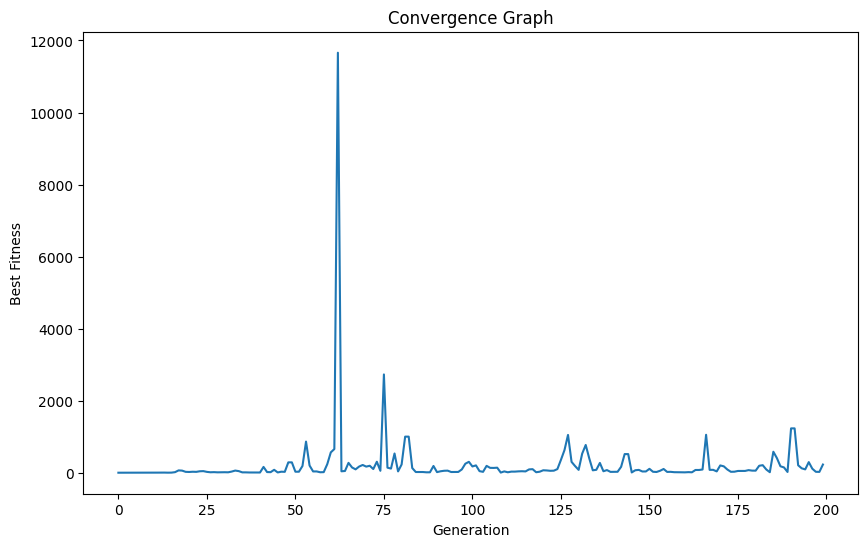

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 1


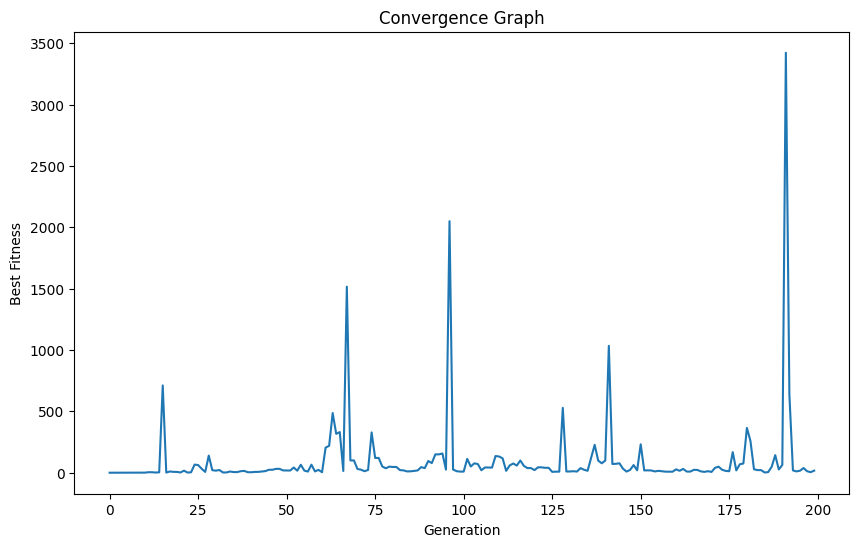

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 2


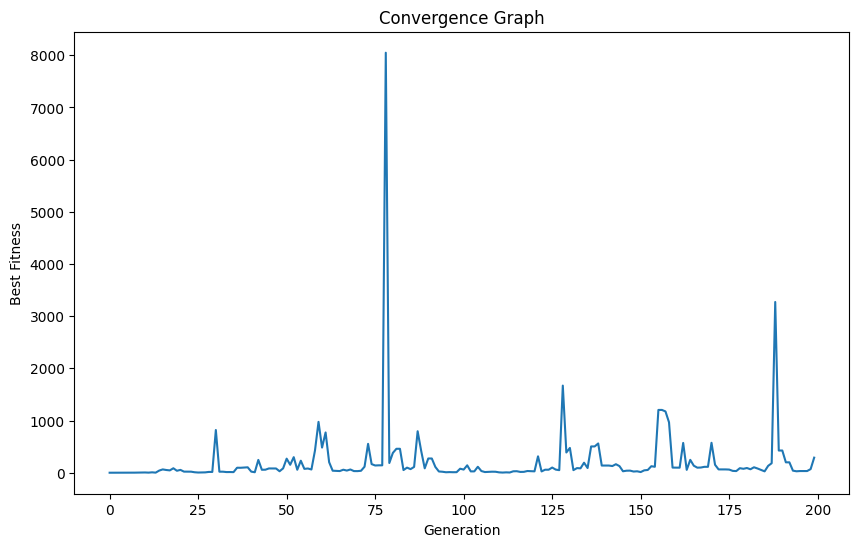

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 3


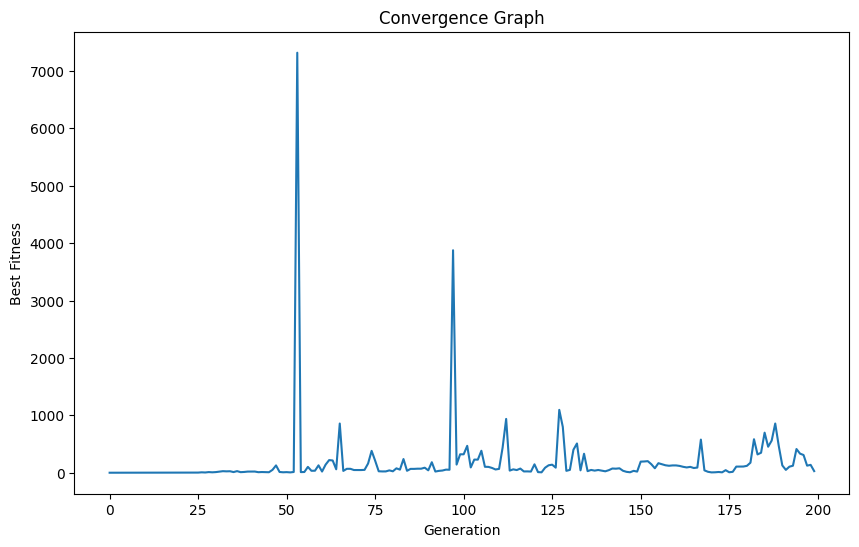

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 4


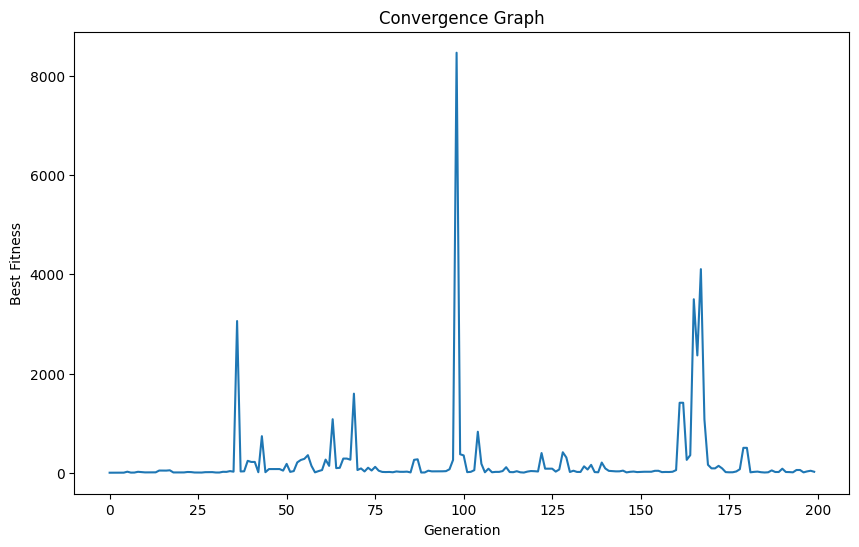

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 5


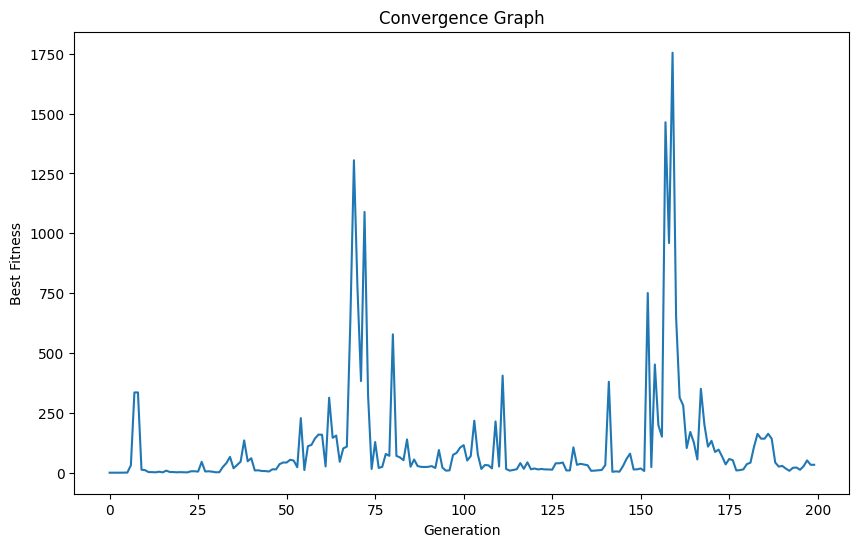

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 6


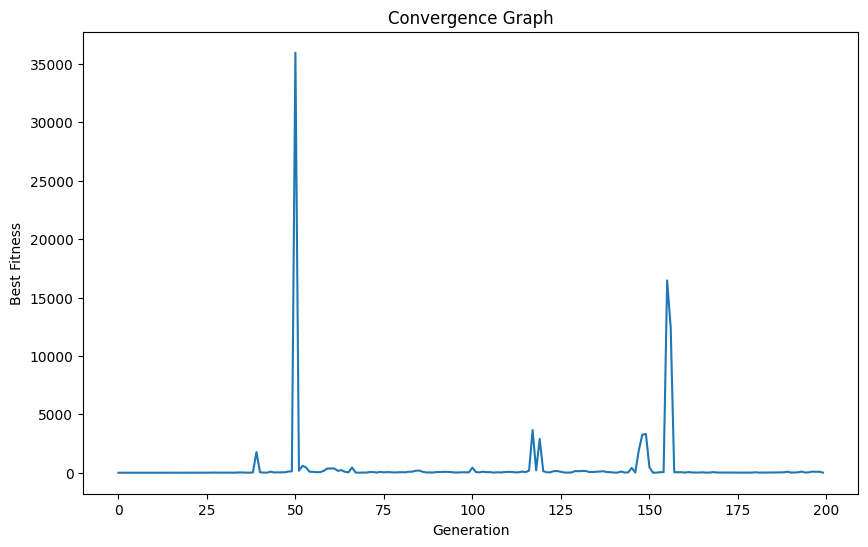

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 7


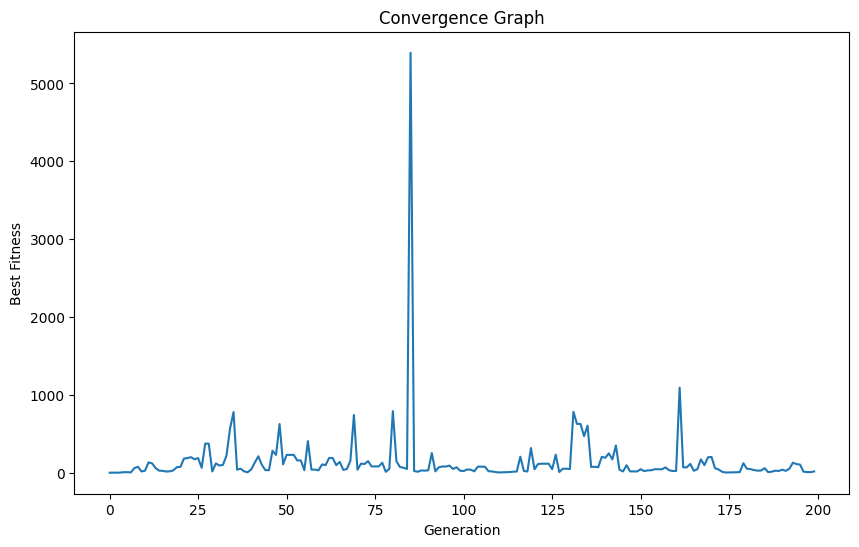

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 8


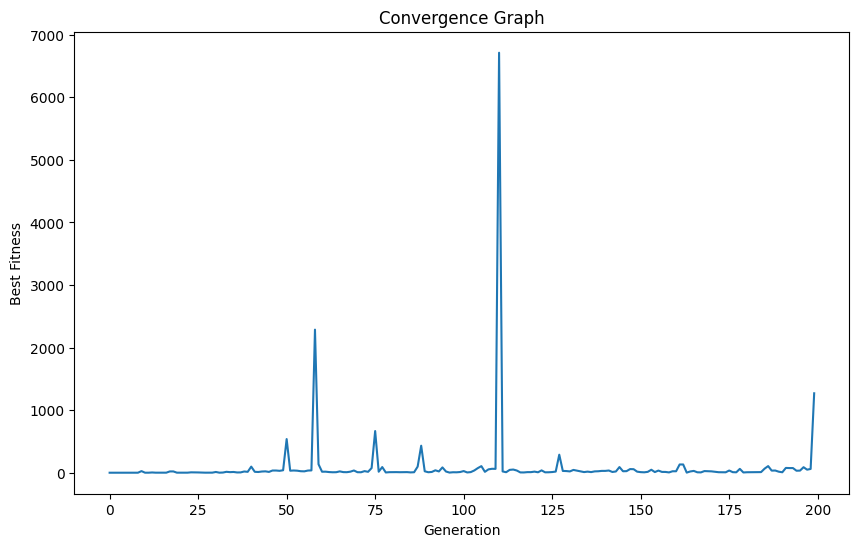

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 9


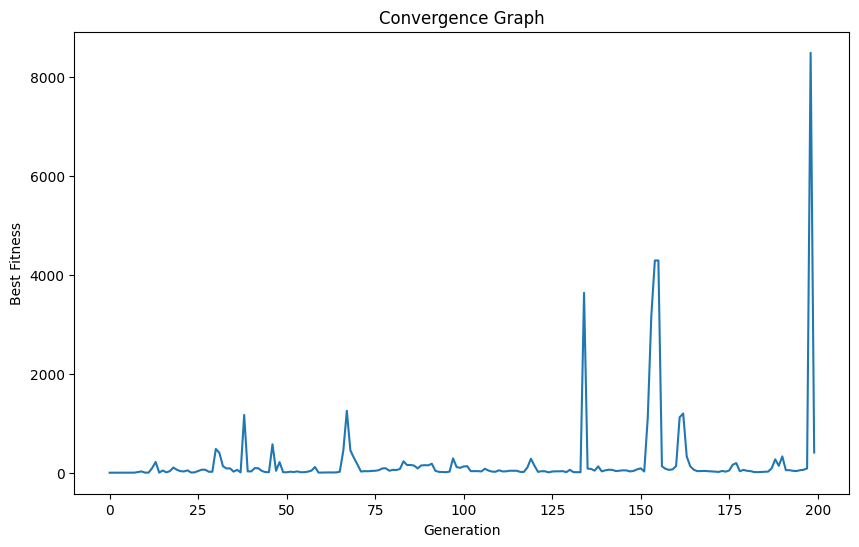

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 10


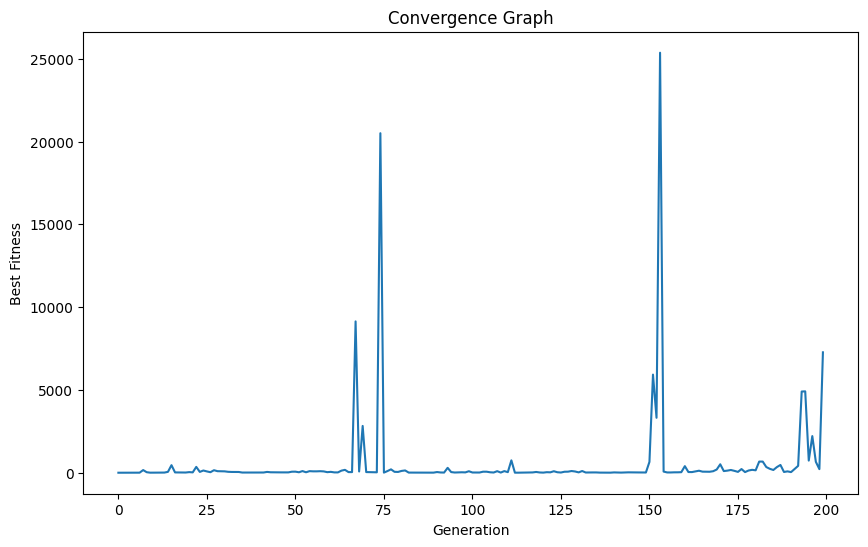

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 11


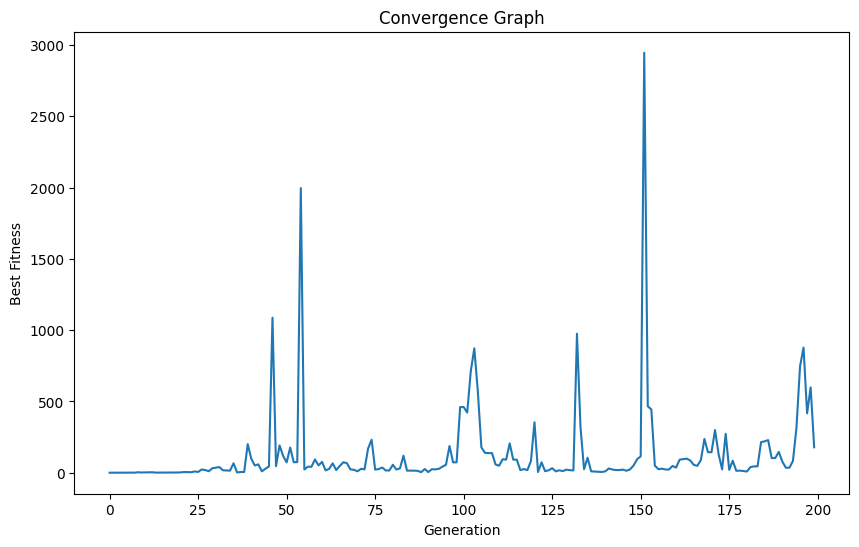

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 12


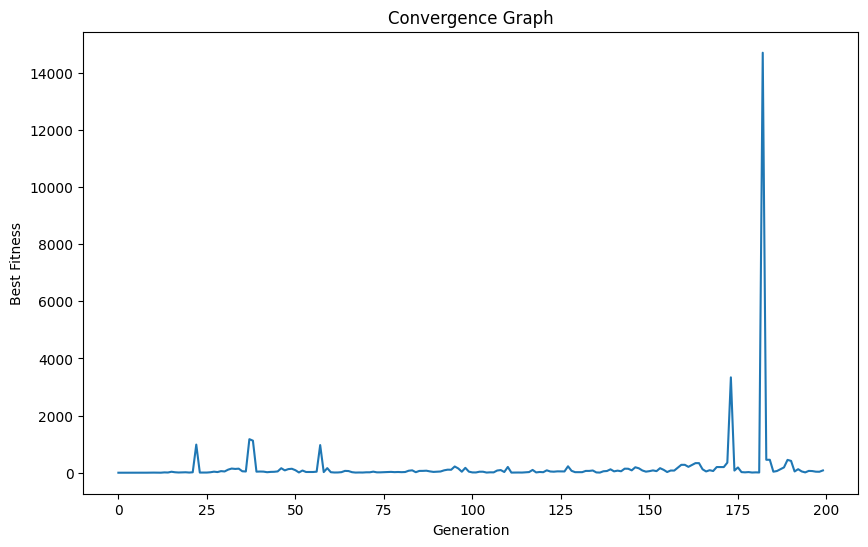

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 13


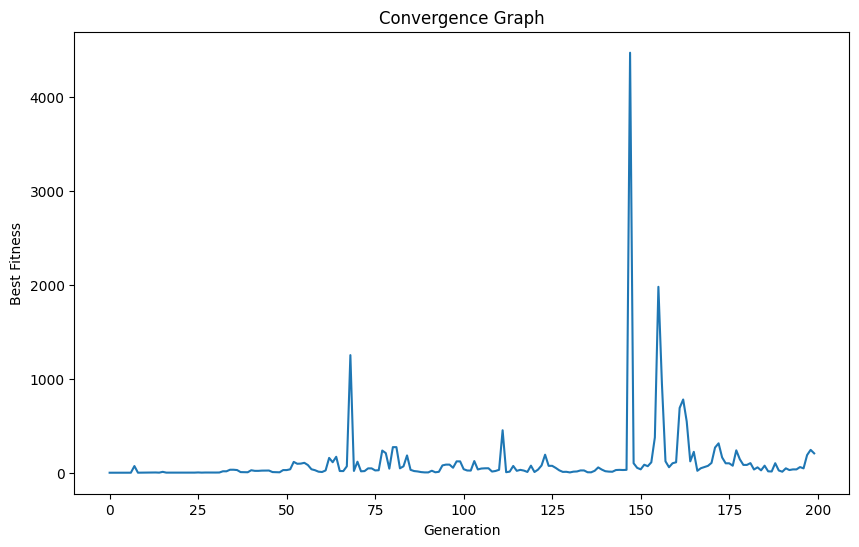

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 14


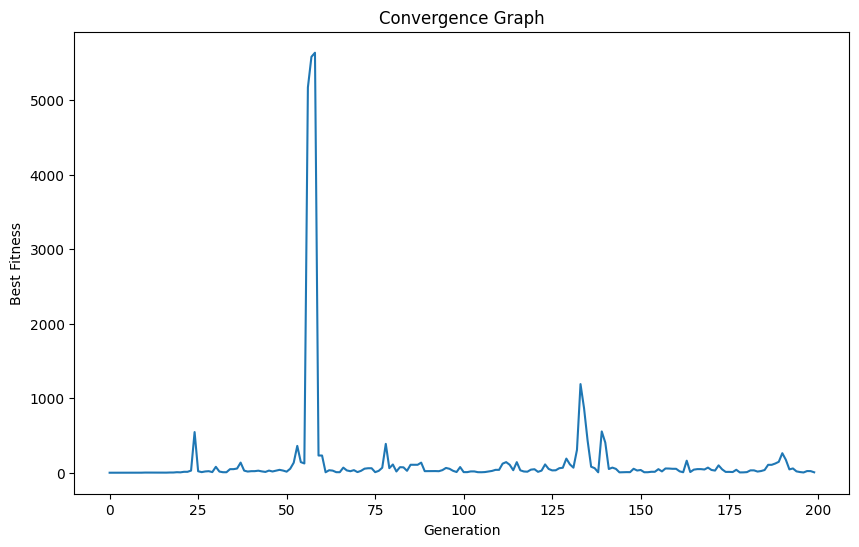

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 15


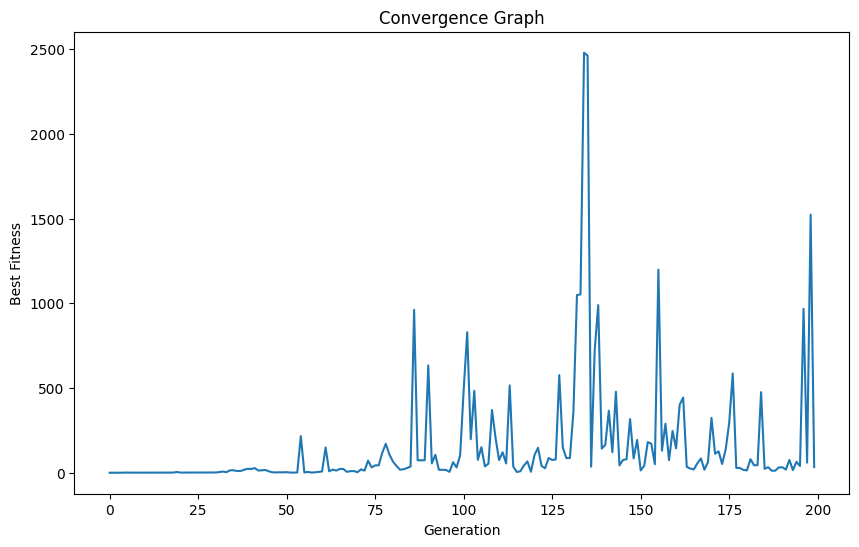

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 16


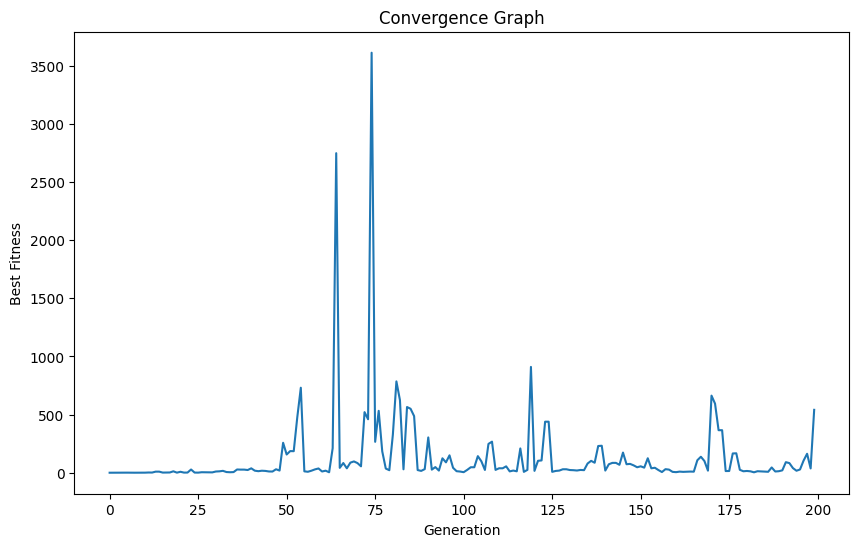

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 17


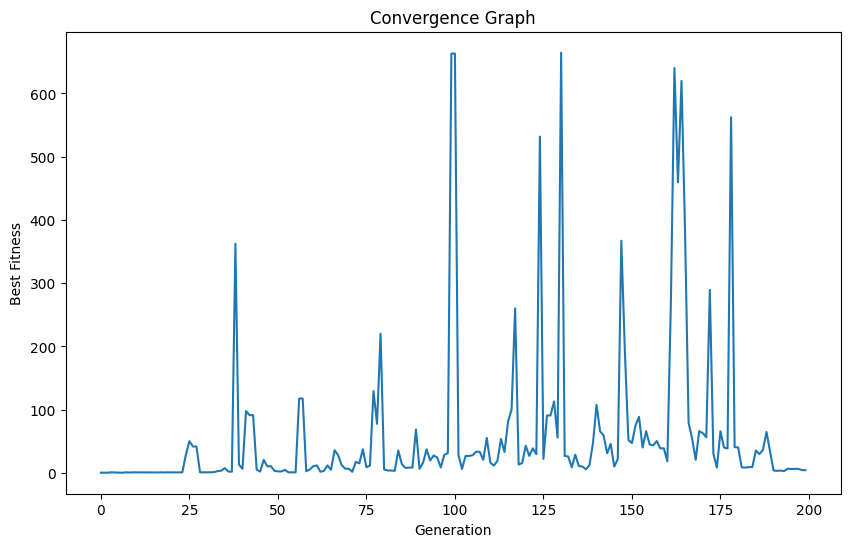

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 18


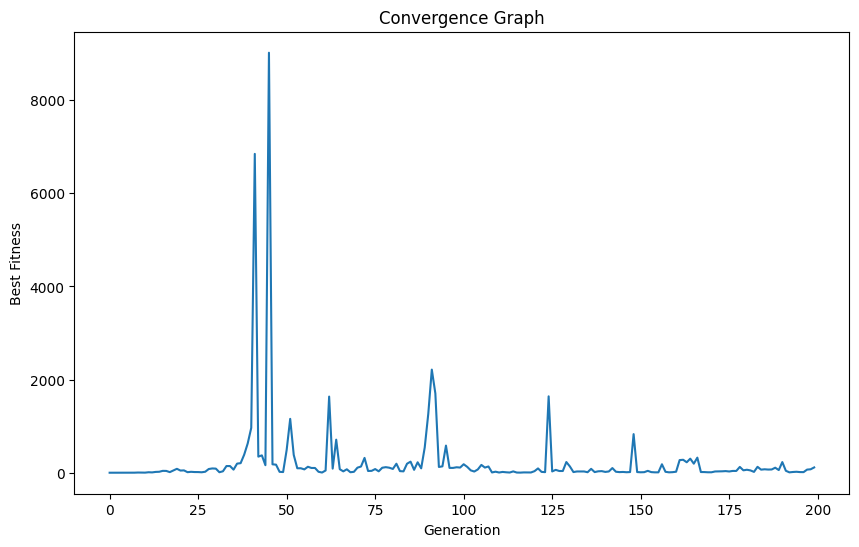

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Run 19


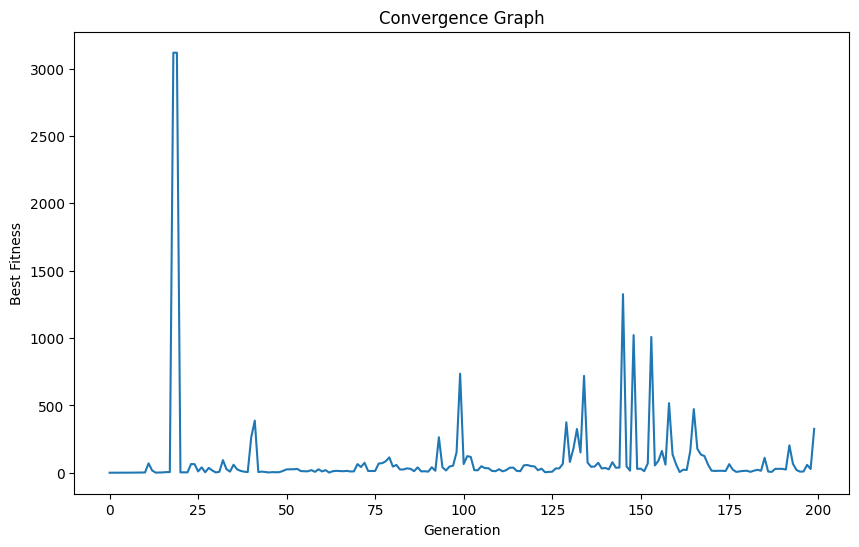

Best X: [0.94201195 0.89021788], Best Evaluation: 0.004164278890295366, Best Fit: 415604.7960573741
Mean Fitness: 415604.7960573741
Standard Deviation: 0.0
Min: 415604.7960573741
Max: 415604.7960573741


In [ ]:
#Parameters
miu = 100
upperBound = 5.12
lowerBound = -5.12
numBits = 17 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 2
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem2Real = []
bestPerGenerationperRunProblem2Real = []

print("Problem 2")
for i in range(20):
  print("Run", i)
  bestX,
  bestEvaluation,
  bestFit,
  bestPerGeneration = geneticAlgorithmReal(
    miu=100,
    numGenerations=200,
    pc=0.9,
    pm=1/numVariables,
    lowerBound=lowerBound,
    upperBound=upperBound,
    function=function2,  # Pass function2
    numVariables=numVariables,
    verbose=True
)
  bestFitnessRunsProblem2Real.append(bestFit)
  bestPerGenerationperRunProblem2Real.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem2Real, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem2Real, axis=0))
print("Min:", np.min(bestFitnessRunsProblem2Real))
print("Max:", np.max(bestFitnessRunsProblem2Real))

Problem 2
Run 0


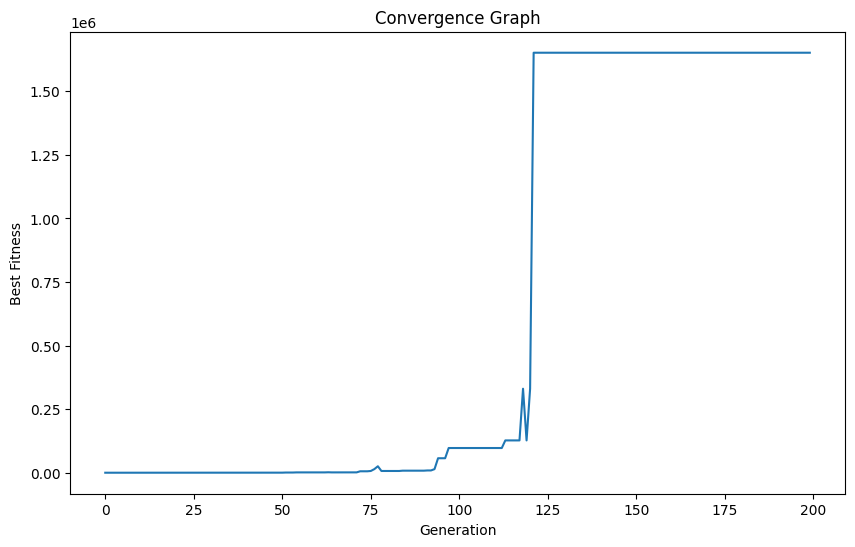

Best X: [3.906279802556867e-05, 3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 1


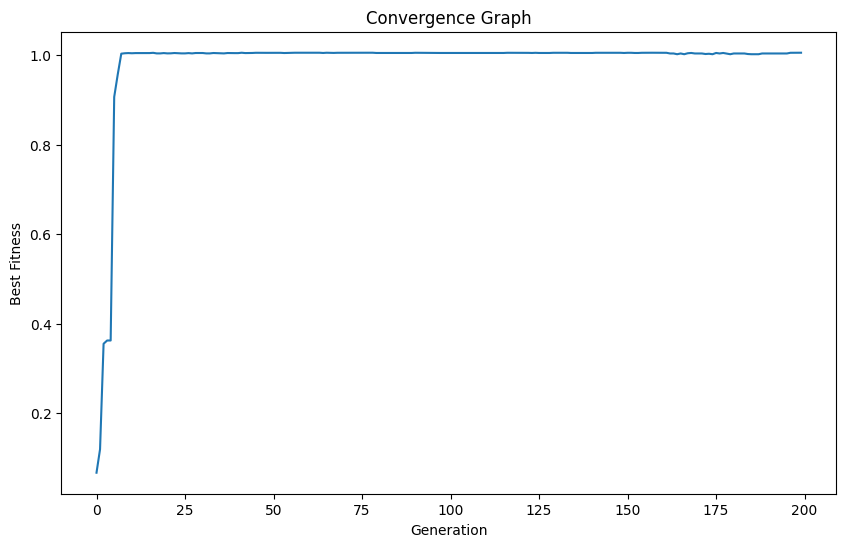

Best X: [0.0006640675664337792, -0.994812277315348], Best Evaluation: 0.9950507927108578, Best Fit: 1.0049738247740196
Run 2


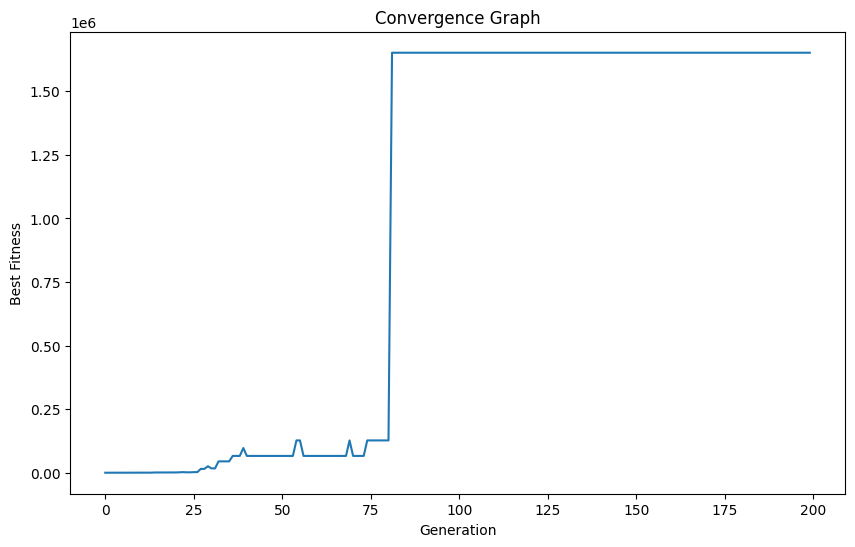

Best X: [3.906279802556867e-05, -3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 3


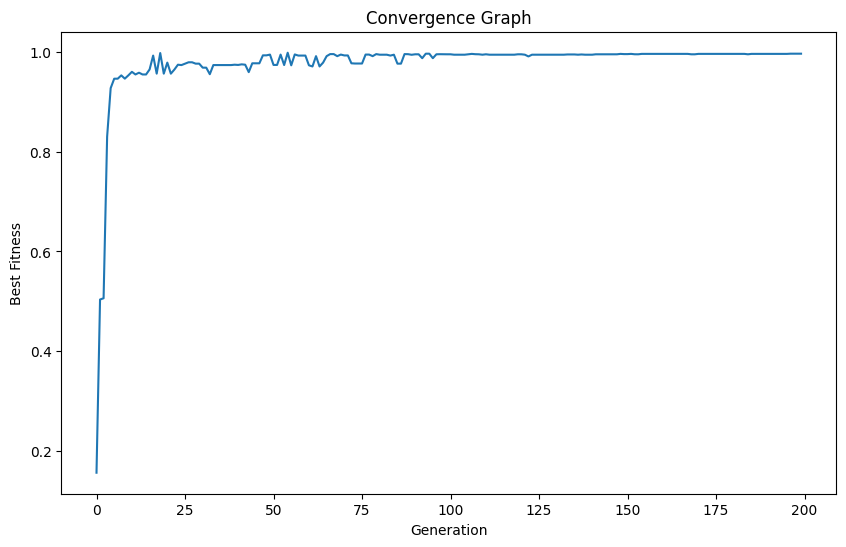

Best X: [-1.0002029434428668, 0.0019922026993004494], Best Evaluation: 1.0012014403629852, Best Fit: 0.9988000023638118
Run 4


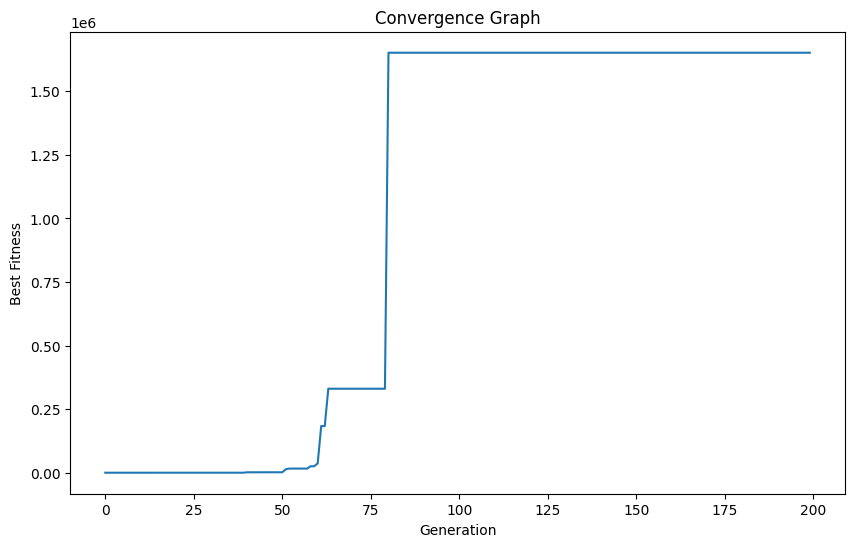

Best X: [3.906279802556867e-05, -3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 5


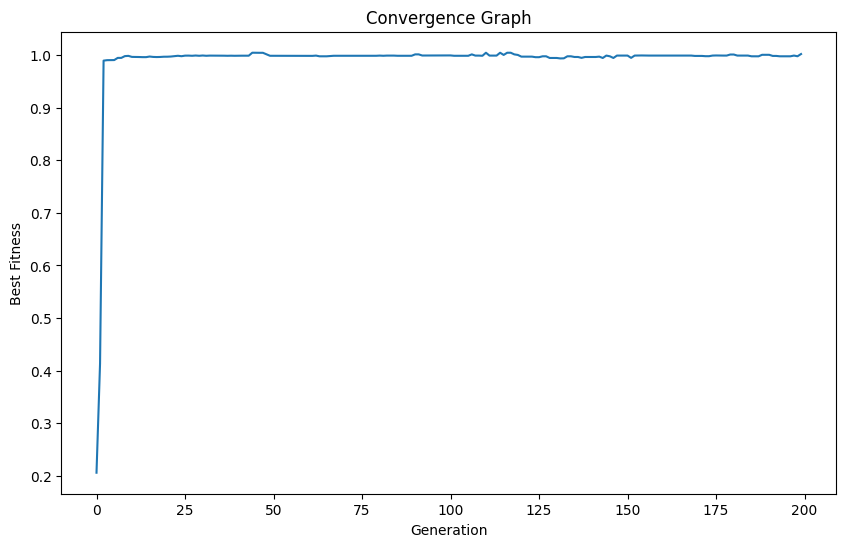

Best X: [-0.9959841612561133, -0.0005078163743315045], Best Evaluation: 0.9952187758586319, Best Fit: 1.0048041950700357
Run 6


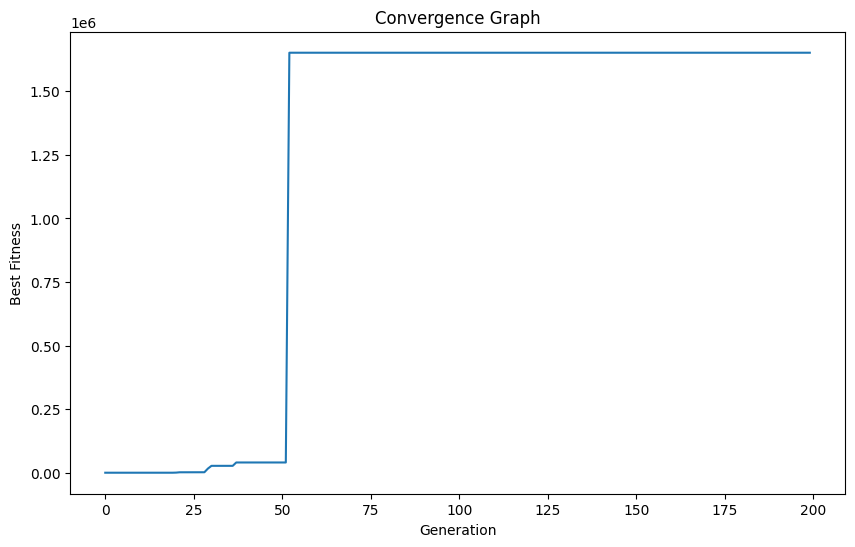

Best X: [-3.906279802556867e-05, 3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 7


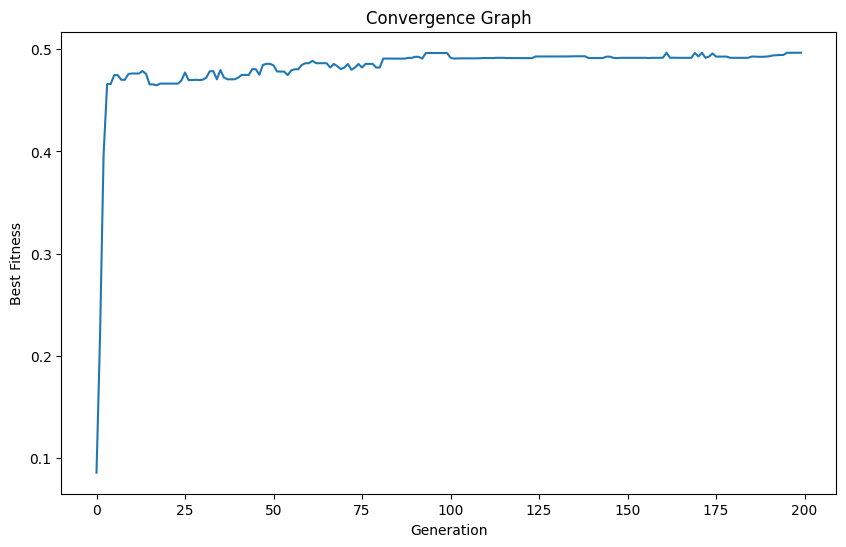

Best X: [1.002781088112549, -1.0025467113243964], Best Evaluation: 2.013476705828648, Best Fit: 0.49665337528795794
Run 8


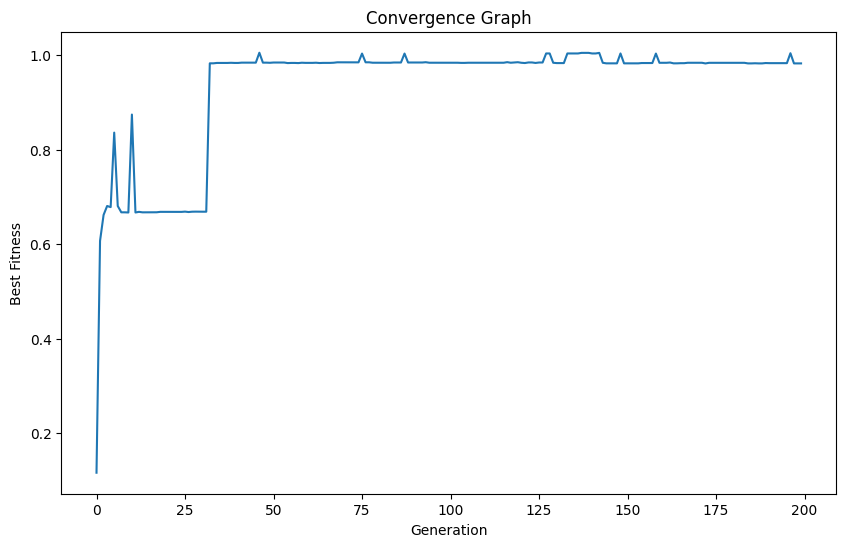

Best X: [0.00035156518222922983, 0.9935622677785316], Best Evaluation: 0.9953701813549838, Best Fit: 1.0046513545684923
Run 9


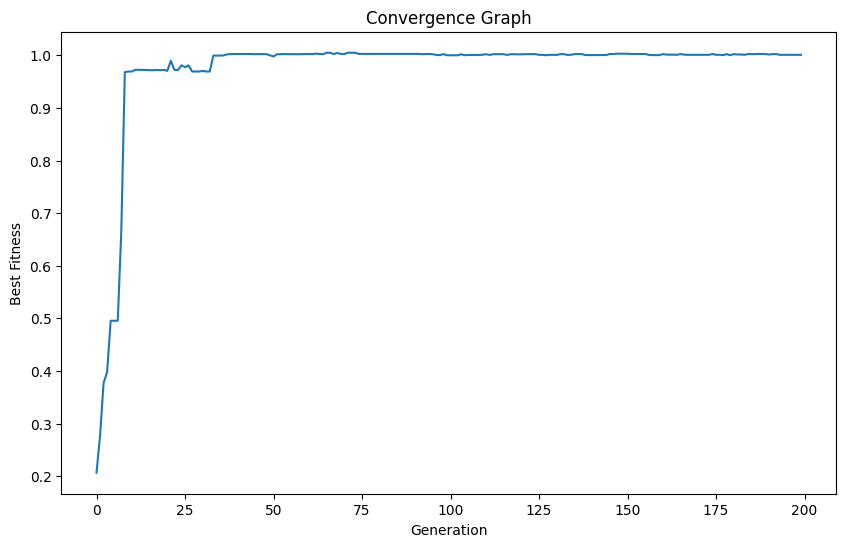

Best X: [-0.0009765699506374403, -0.9951247796995526], Best Evaluation: 0.9951537344073937, Best Fit: 1.0048698672578926
Run 10


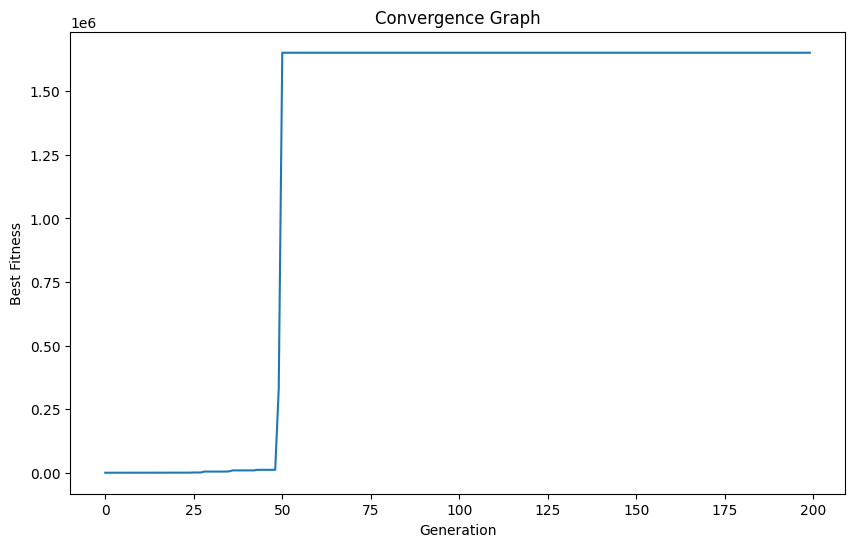

Best X: [3.906279802556867e-05, 3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 11


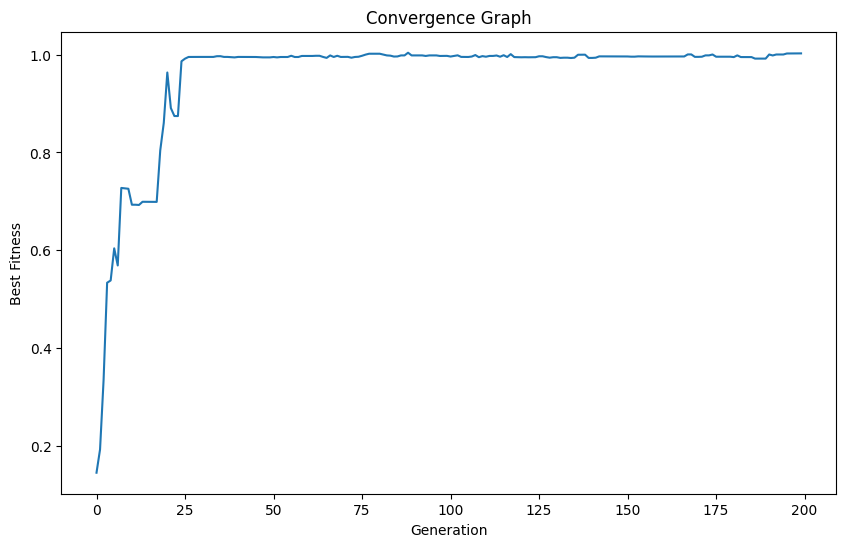

Best X: [0.9956716588719088, -0.0023047050835041105], Best Evaluation: 0.9961136478132211, Best Fit: 1.0039015158475384
Run 12


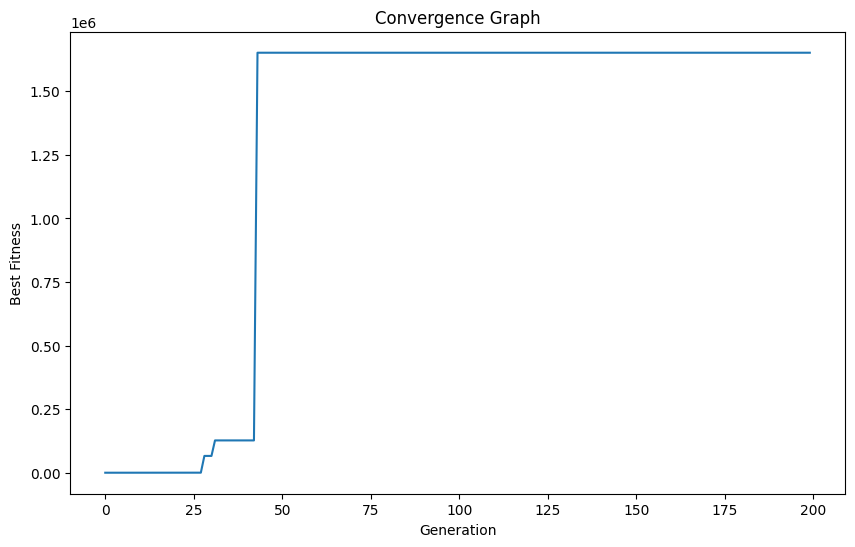

Best X: [-3.906279802556867e-05, 3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 13


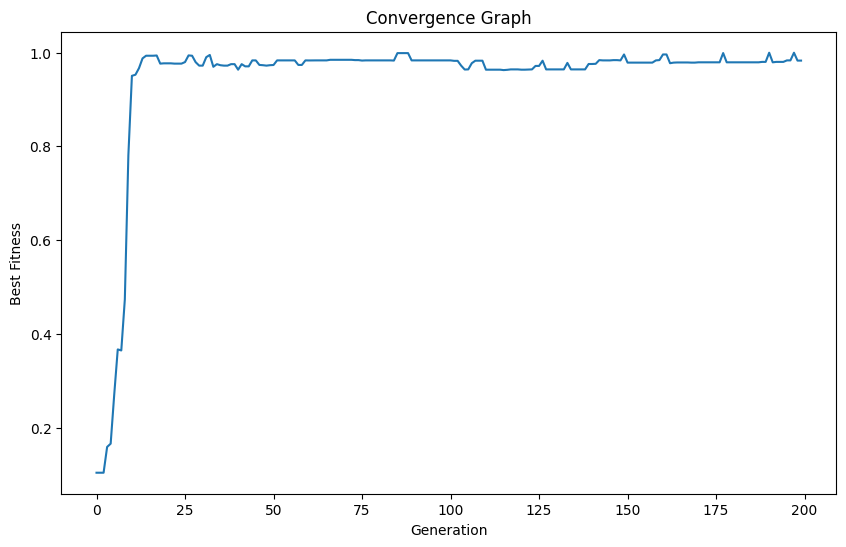

Best X: [-1.0002029434428668, 0.0002734395861780925], Best Evaluation: 1.0004288914848285, Best Fit: 0.9995712933842174
Run 14


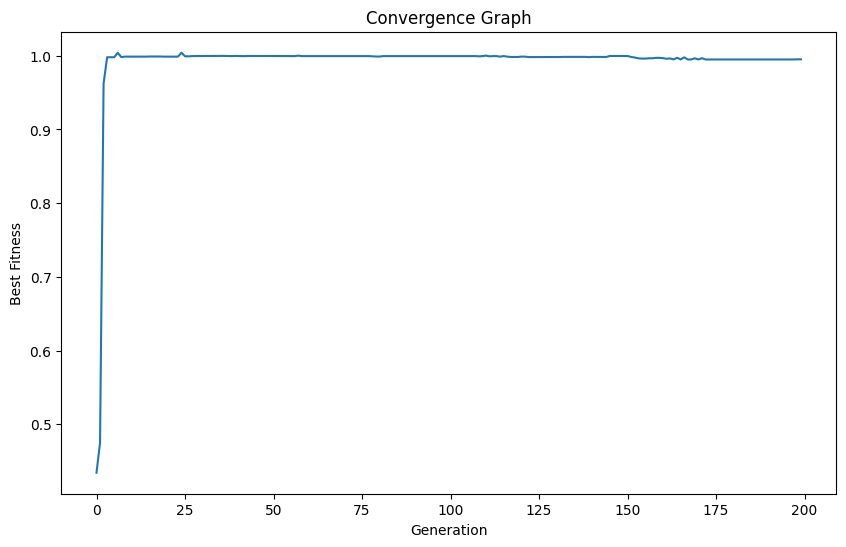

Best X: [0.0020703282953515867, -0.9951247796995526], Best Evaluation: 0.9958148786639942, Best Fit: 1.0042027111880831
Run 15


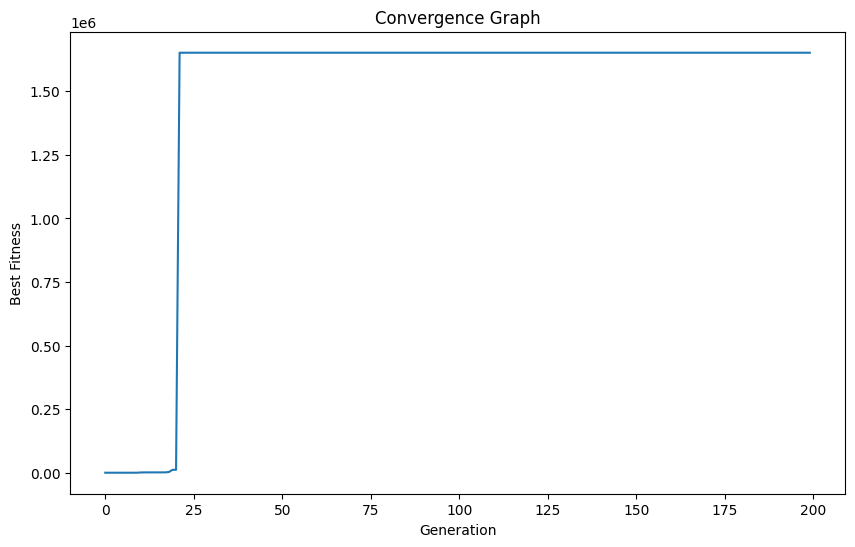

Best X: [3.906279802556867e-05, -3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 16


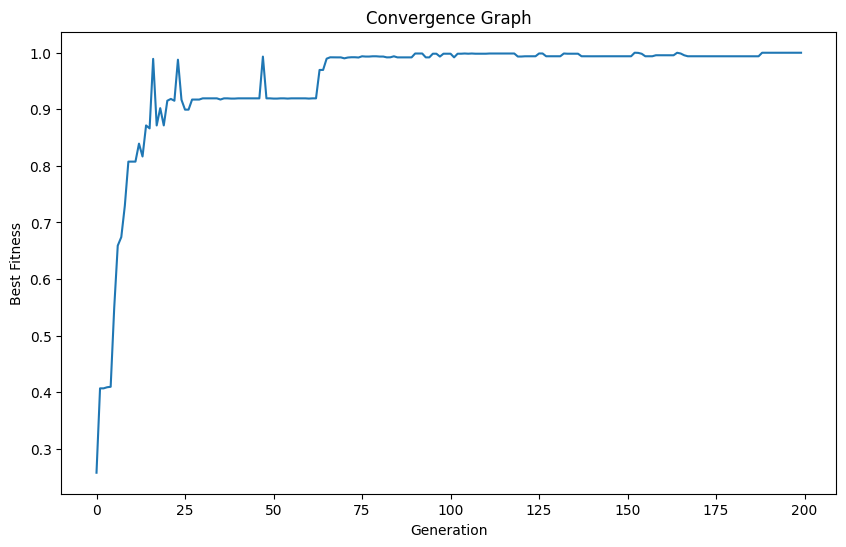

Best X: [-0.0002734395861780925, -1.0000466922507654], Best Evaluation: 1.0001086506447905, Best Fit: 0.9998913621588896
Run 17


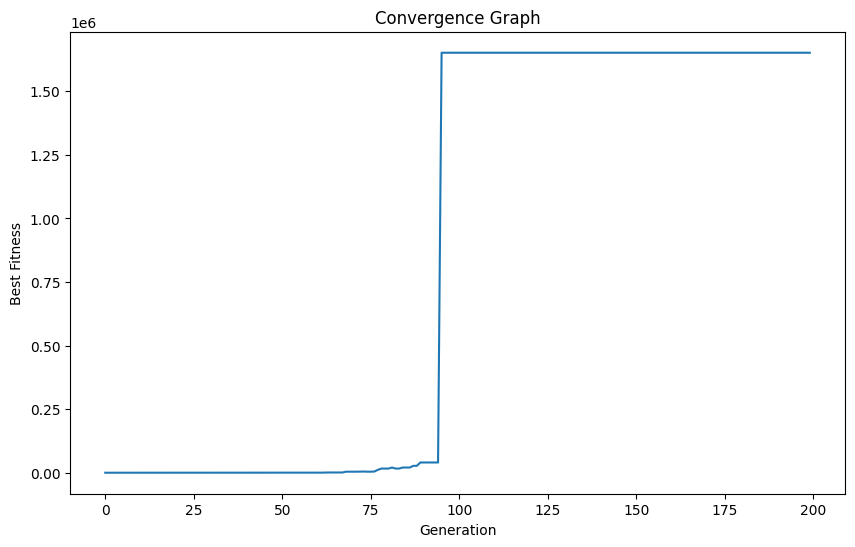

Best X: [3.906279802556867e-05, 3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Run 18


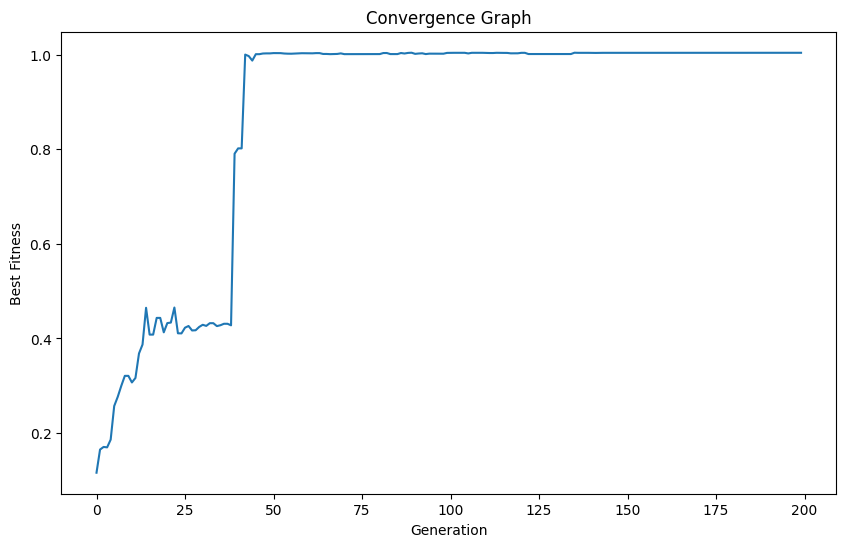

Best X: [0.9959841612561124, -0.0015234491229945135], Best Evaluation: 0.9956280592017048, Best Fit: 1.0043911395962752
Run 19


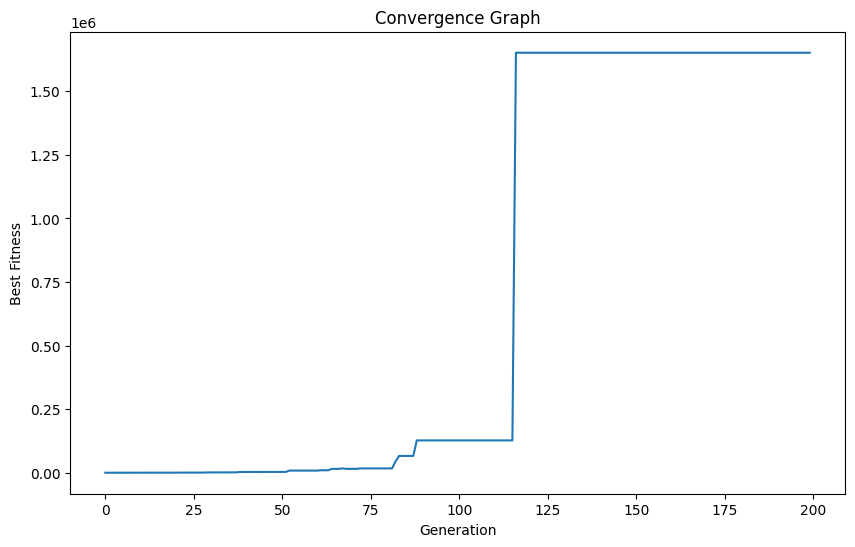

Best X: [3.906279802556867e-05, -3.906279802556867e-05], Best Evaluation: 6.054538417288313e-07, Best Fit: 1651653.5713846826
Mean Fitness: 743244.6334586393
Standard Deviation: 821686.8009016258
Min: 0.49665337528795794
Max: 1651653.5713846826


In [ ]:
#Parameters
miu = 100
upperBound = 5.12
lowerBound = -5.12
numBits = 17 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 2
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem2Binary = []
bestPerGenerationperRunProblem2Binary = []

print("Problem 2")
for i in range(20):
  print("Run", i)
  bestX, bestEvaluation, bestFit, bestPerGeneration = geneticAlgorithmBinary(miu, numBits, numGenerations, pc, pm, lowerBound, upperBound, function2, numVariables)
  bestFitnessRunsProblem2Binary.append(bestFit)
  bestPerGenerationperRunProblem2Binary.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem2Binary, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem2Binary, axis=0))
print("Min:", np.min(bestFitnessRunsProblem2Binary))
print("Max:", np.max(bestFitnessRunsProblem2Binary))

Best Evaluation Real: 0.004164278890295366 (All runs gave the same result)

**Best Evaluation Binary: 6.054538417288313e-07**

### Problem 3

Problem 3, Rastringin n=5
Run 0


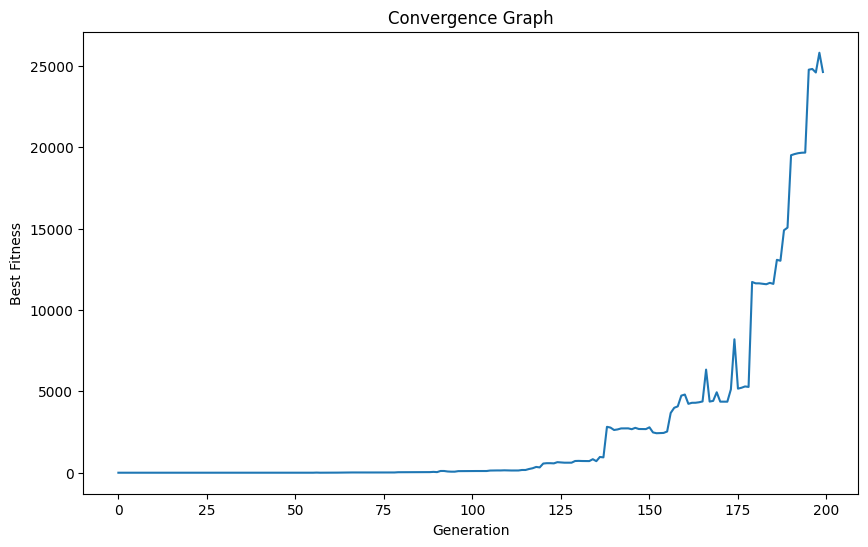

Best X: [ 2.23038574e-05 -1.14534569e-04 -4.94156684e-05 -6.04357457e-05
  4.18963762e-04], Best Evaluation: 3.873418035027498e-05, Best Fit: 25816.99137446546
Run 1


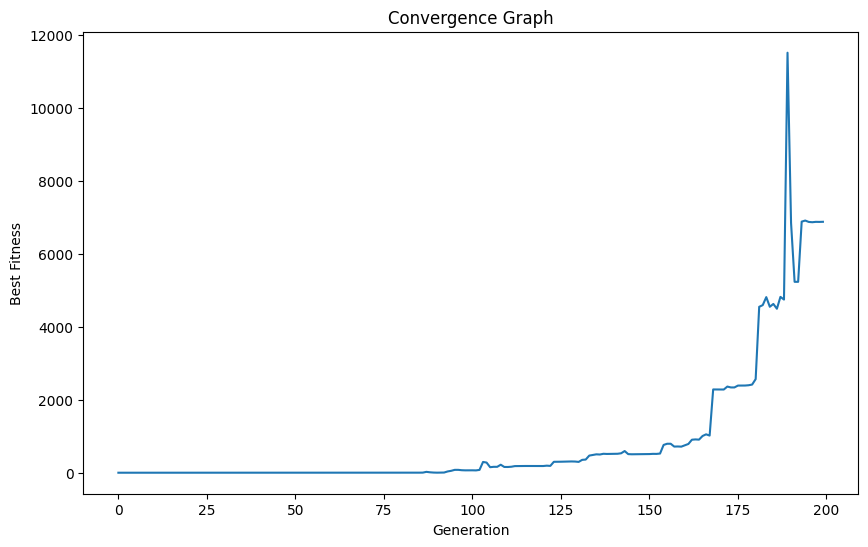

Best X: [ 2.79423448e-04 -7.91881371e-05 -3.26360145e-04 -3.98547506e-04
  2.96516693e-04], Best Evaluation: 8.682059703346567e-05, Best Fit: 11518.004185281392
Run 2


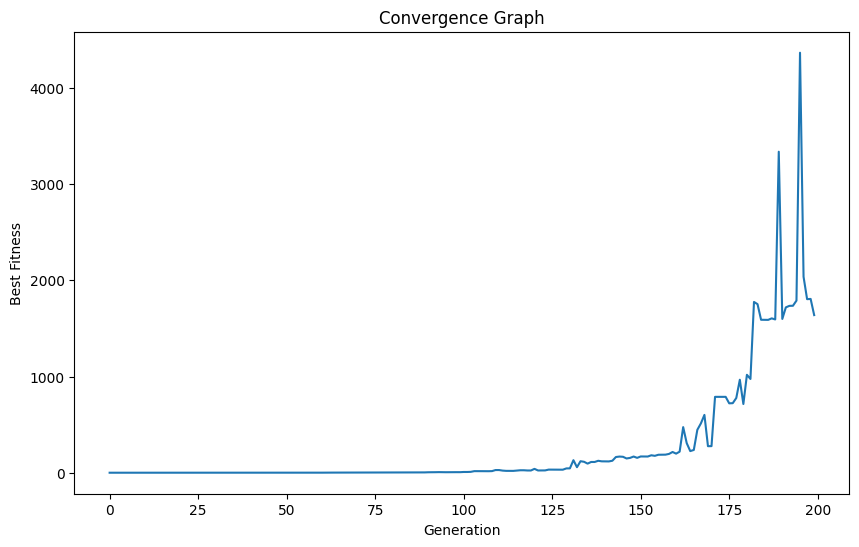

Best X: [ 6.68182721e-04 -3.32499658e-04  7.21161677e-05  2.19565218e-04
  7.37399394e-04], Best Evaluation: 0.00022898216317202014, Best Fit: 4367.152384917383
Run 3


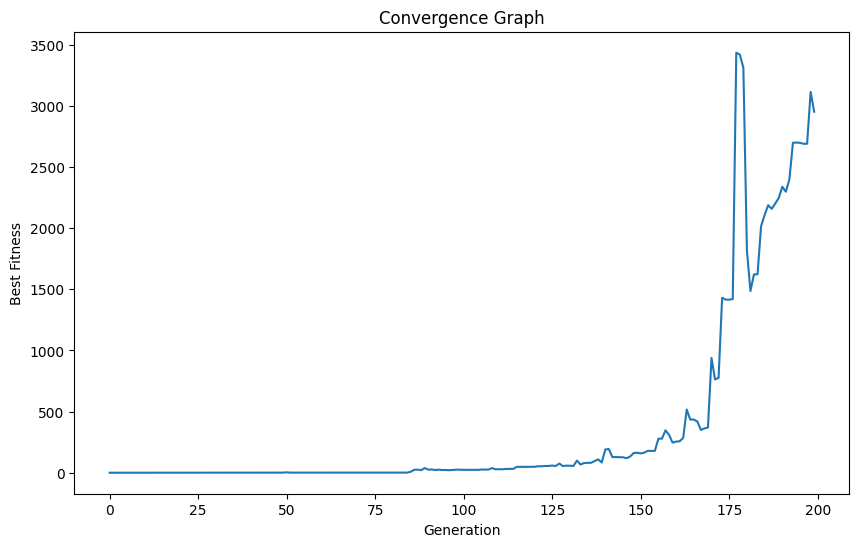

Best X: [ 5.88285029e-04 -3.96481827e-07 -2.23249406e-04  3.11893687e-05
 -1.03447361e-03], Best Evaluation: 0.0002910459563167933, Best Fit: 3435.883503263059
Run 4


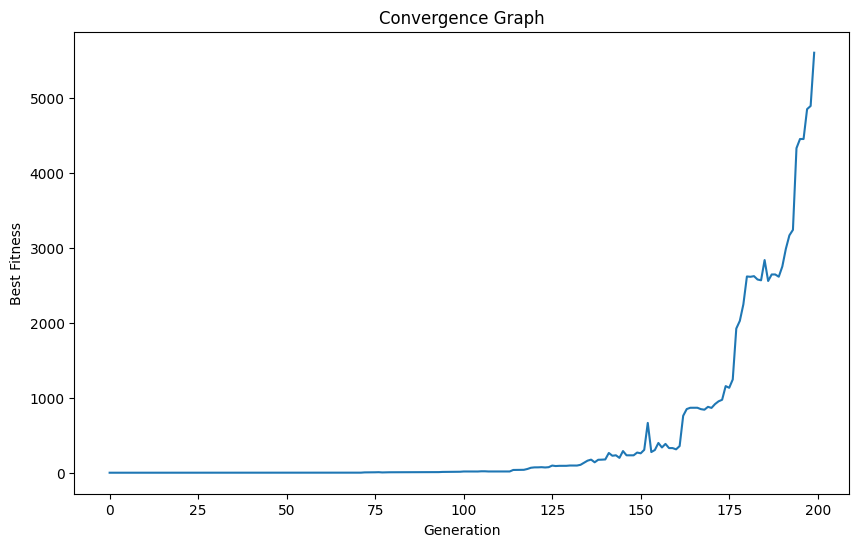

Best X: [-0.00026521  0.00013231  0.00036502 -0.00075221 -0.00033713], Best Evaluation: 0.0001786635103115941, Best Fit: 5597.113804918257
Run 5


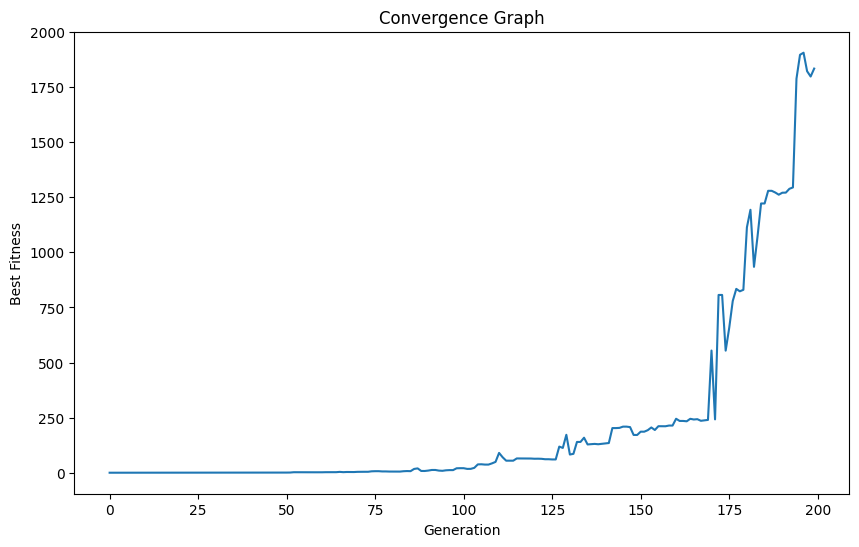

Best X: [ 1.04884840e-03  3.72551512e-04 -1.15278891e-03  2.62159765e-04
 -9.13082124e-05], Best Evaluation: 0.0005247182998004973, Best Fit: 1905.7844949961413
Run 6


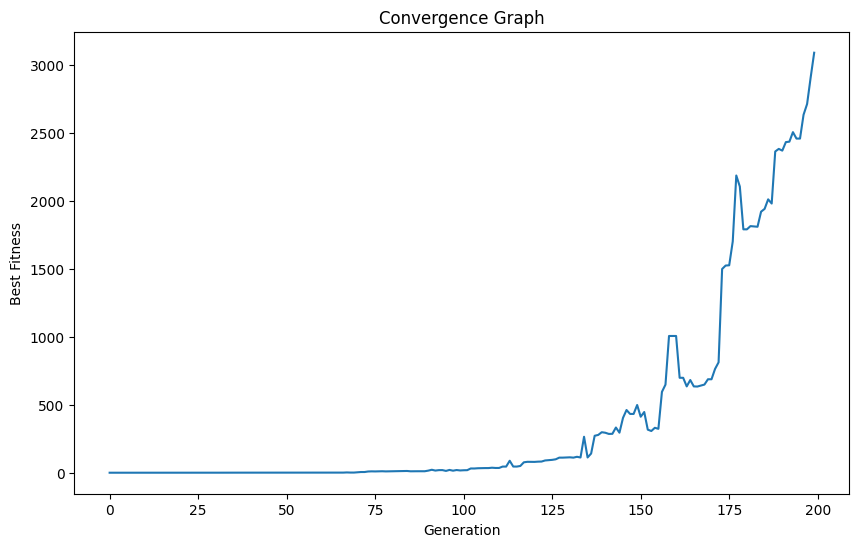

Best X: [-0.00051841  0.00079476 -0.00034951  0.00016317 -0.00076409], Best Evaluation: 0.00032397555666108246, Best Fit: 3086.652617581408
Run 7


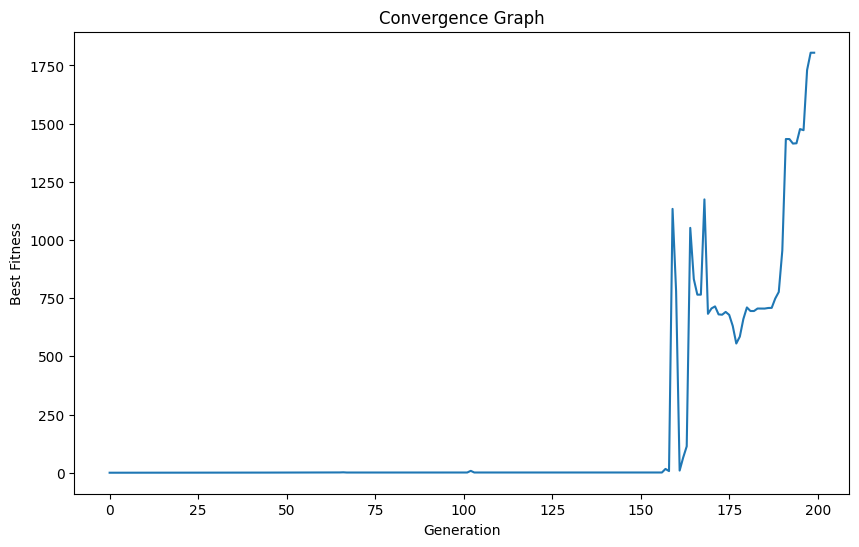

Best X: [ 0.00121216 -0.00083486 -0.00016172 -0.00041455  0.00065464], Best Evaluation: 0.0005540818242479872, Best Fit: 1804.7875895546247
Run 8


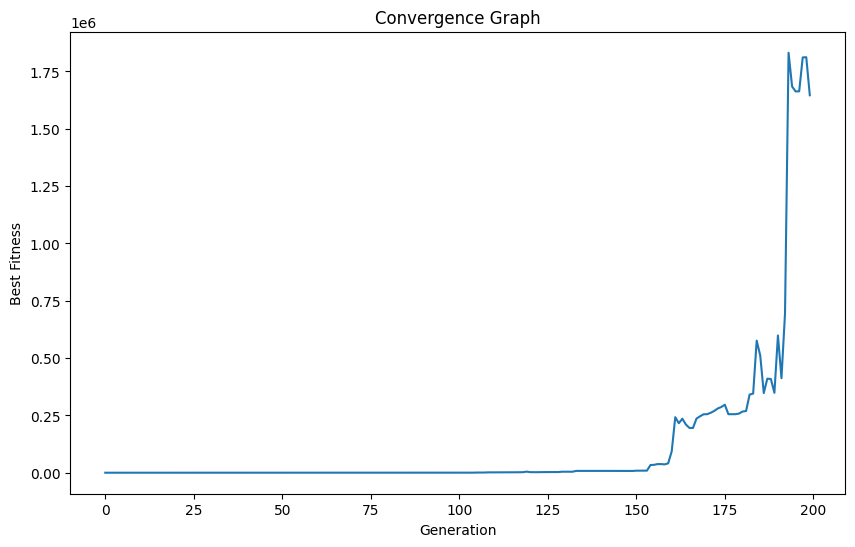

Best X: [-7.03559979e-06  3.09665789e-05  3.96966350e-05 -5.39387822e-06
 -1.17840420e-05], Best Evaluation: 5.460165013460028e-07, Best Fit: 1831446.481076796
Run 9


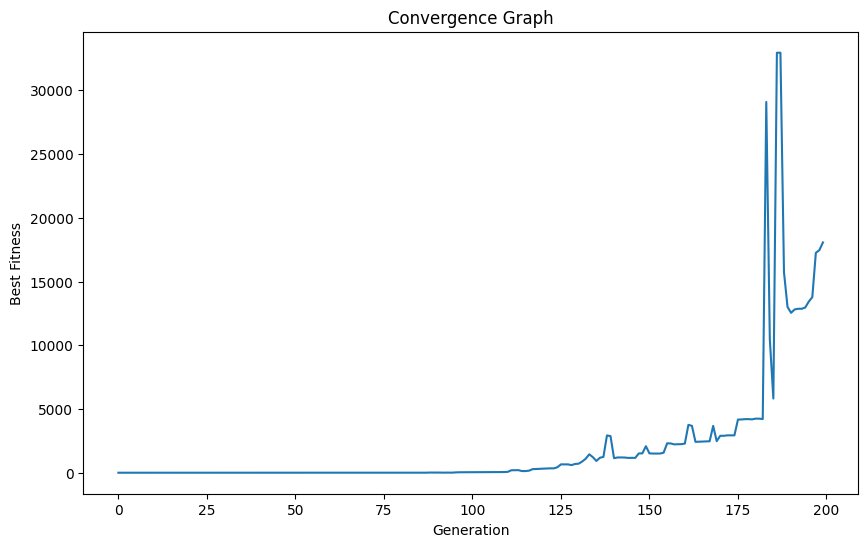

Best X: [-7.26275496e-05  7.55267976e-05  1.31291208e-04  3.52632282e-04
 -2.05584217e-05], Best Evaluation: 3.0351720369026225e-05, Best Fit: 32947.061578114866
Run 10


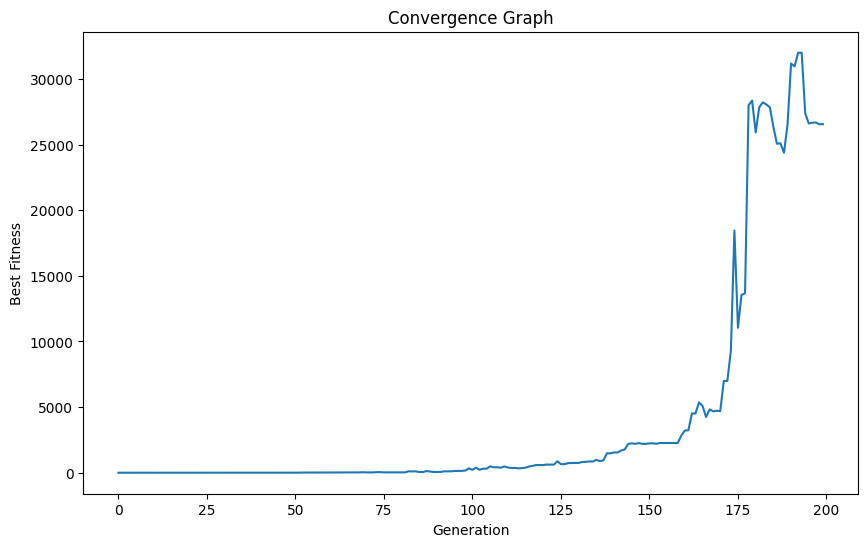

Best X: [ 5.13353494e-05 -5.15085376e-05  1.41444253e-04  2.45935025e-04
  2.67854588e-04], Best Evaluation: 3.125171579654307e-05, Best Fit: 31998.24312080321
Run 11


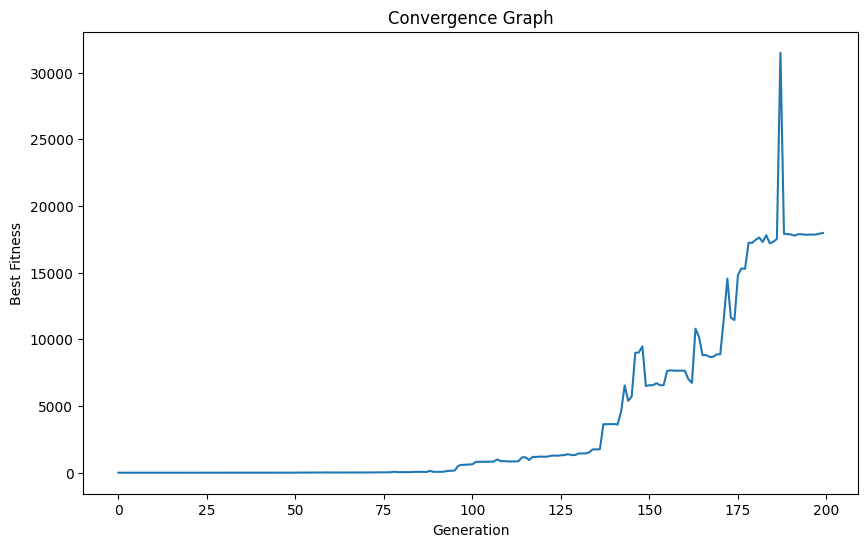

Best X: [ 5.61331304e-05  6.57964994e-05  6.56385448e-05  1.80093749e-04
 -3.40324101e-04], Best Evaluation: 3.17512116225771e-05, Best Fit: 31494.861105992222
Run 12


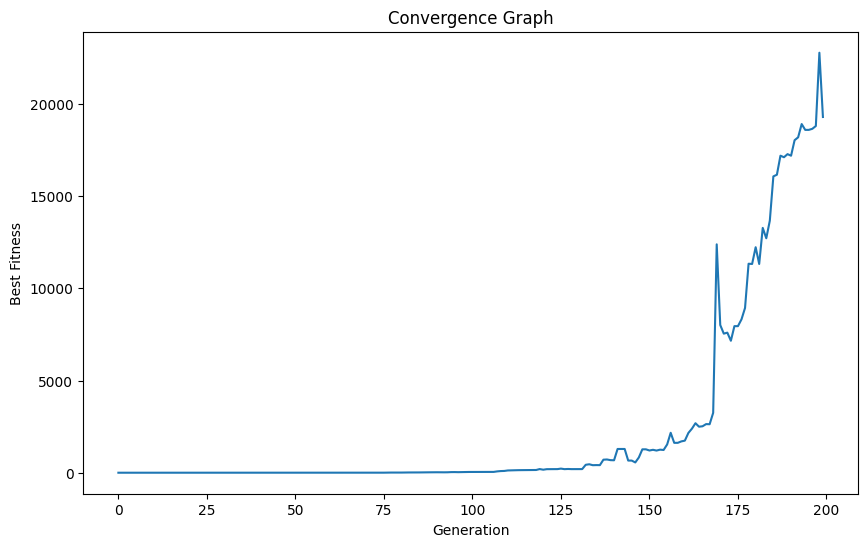

Best X: [ 1.93616313e-04 -1.19269610e-05  1.01036003e-04 -3.37827888e-04
 -2.43473377e-04], Best Evaluation: 4.389320014297482e-05, Best Fit: 22782.572169327133
Run 13


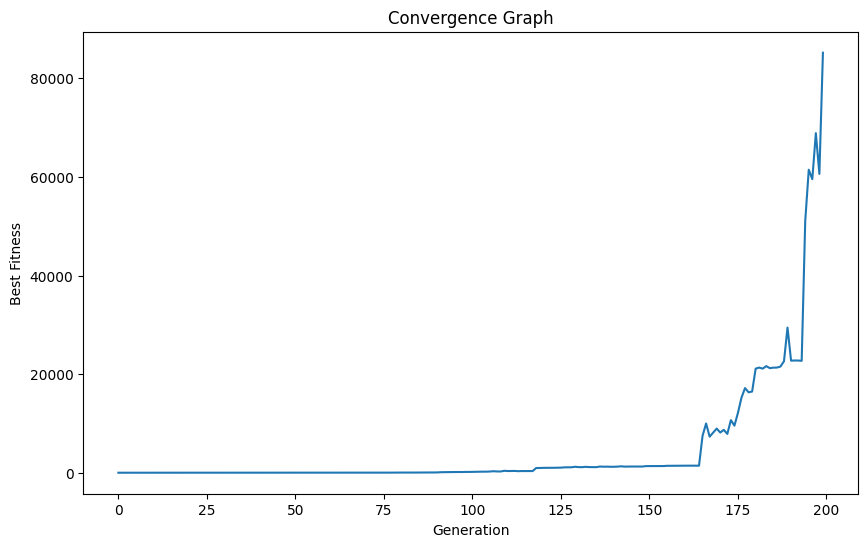

Best X: [-3.06683122e-05  2.78042576e-05 -2.33071371e-04  4.20796315e-05
  3.68077435e-05], Best Evaluation: 1.173715010338583e-05, Best Fit: 85199.55791581303
Run 14


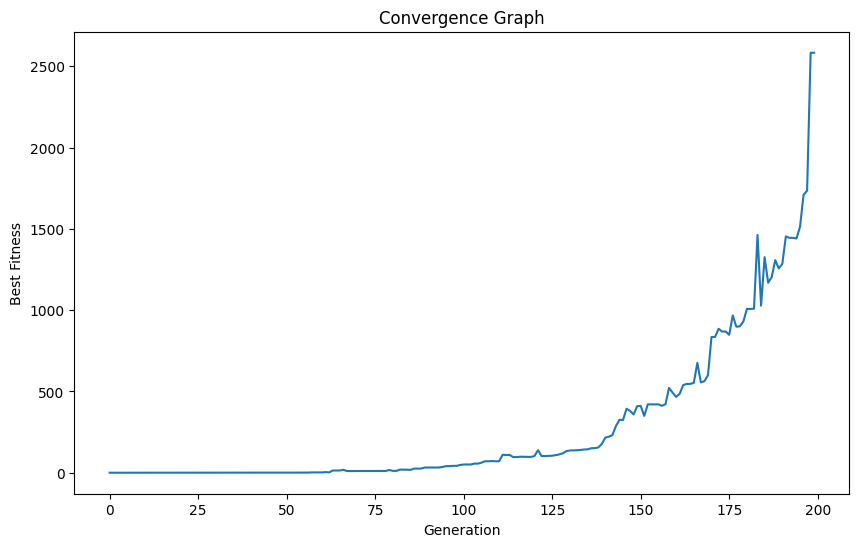

Best X: [-0.0009304  -0.00082989 -0.00022371 -0.00043747 -0.00039397], Best Evaluation: 0.00038706174982650055, Best Fit: 2583.567093489952
Run 15


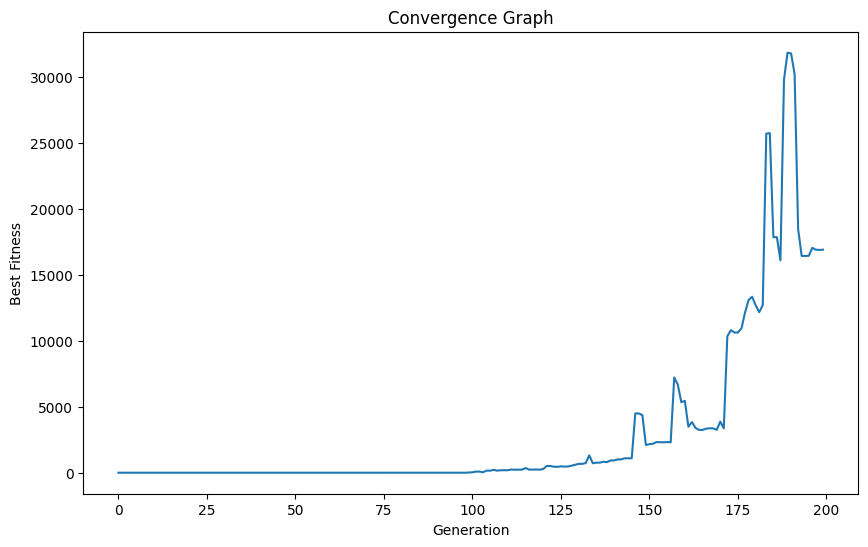

Best X: [-5.52881299e-05 -1.87819421e-05  2.27104669e-04  3.16827469e-04
  5.58888499e-05], Best Evaluation: 3.144301045665543e-05, Best Fit: 31803.570506664542
Run 16


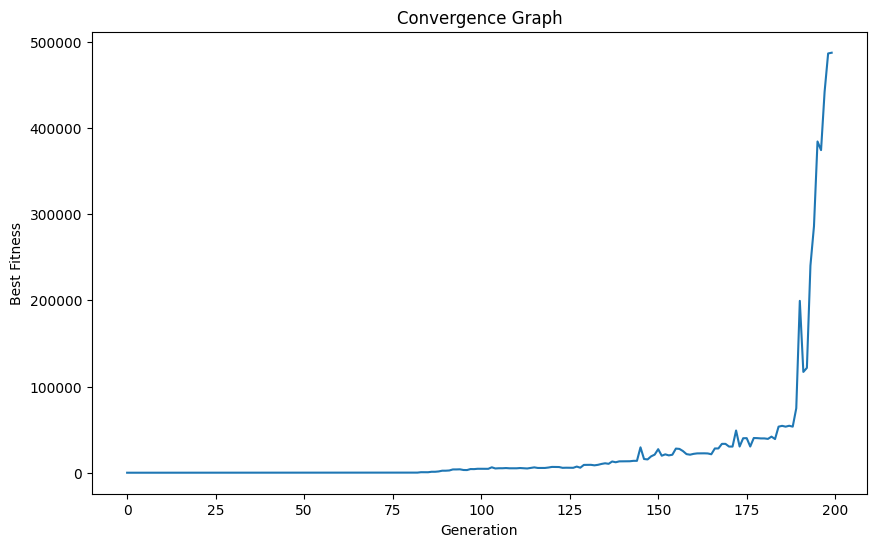

Best X: [ 4.17696455e-05  3.89899921e-05  3.07408646e-10 -2.60551557e-05
  8.00091884e-05], Best Evaluation: 2.052418523135202e-06, Best Fit: 487230.059916063
Run 17


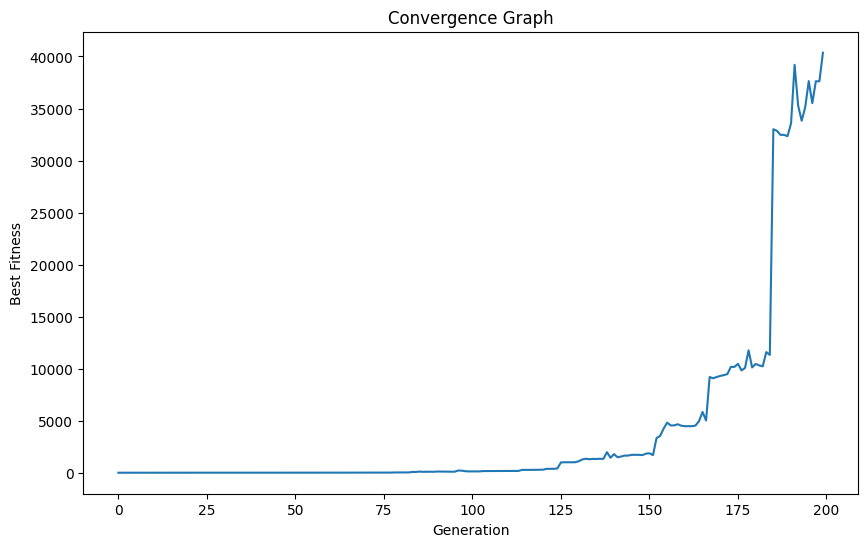

Best X: [-1.13772124e-04 -6.85094197e-06 -2.21407816e-04  1.83080022e-05
 -2.50069950e-04], Best Evaluation: 2.477571863579442e-05, Best Fit: 40362.098662005585
Run 18


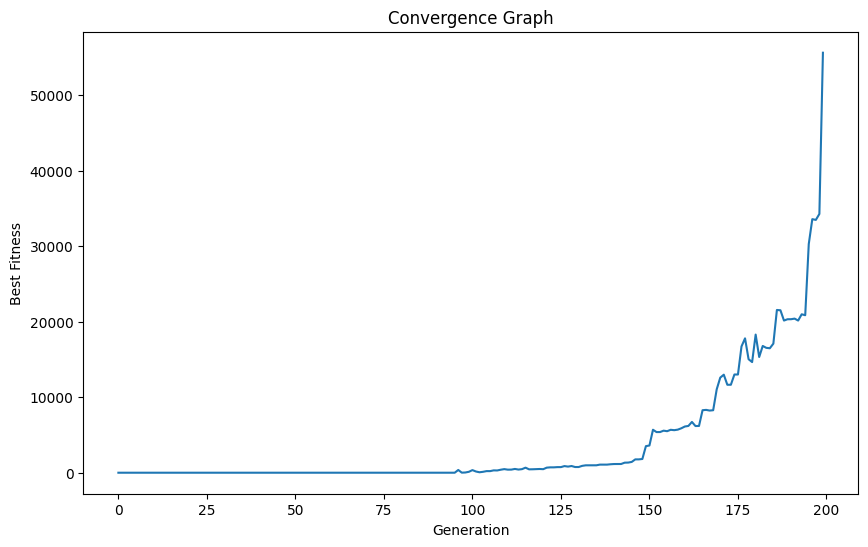

Best X: [-2.09067836e-04  8.18088745e-05 -1.54166151e-04 -1.28113698e-04
  6.76053918e-06], Best Evaluation: 1.7979891978825435e-05, Best Fit: 55617.686756833595
Run 19


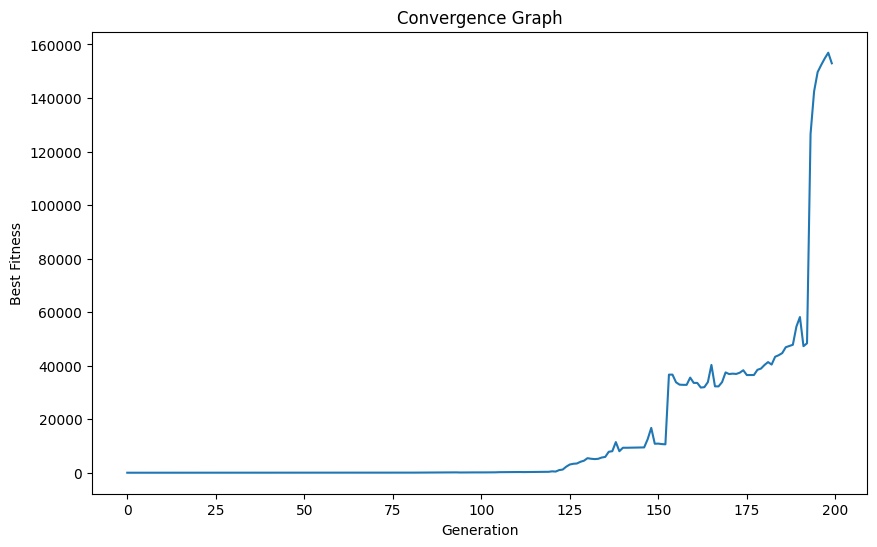

Best X: [-6.36771025e-05  3.42717355e-05 -5.05104884e-05 -1.44695654e-04
 -5.83599996e-05], Best Evaluation: 6.373019488137288e-06, Best Fit: 156911.4925603793
Mean Fitness: 143395.481120863
Standard Deviation: 401401.4813654474
Min: 1804.7875895546247
Max: 1831446.481076796


In [ ]:
#Parameters
miu = 100
upperBound = 5.12
lowerBound = -5.12
numBits = 17 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 5
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem3Real = []
bestPerGenerationperRunProblem3Real = []

print("Problem 3, Rastringin n=5")
for i in range(20):
  print("Run", i)
  bestX, bestEvaluation, bestFit, bestPerGeneration = geneticAlgorithmReal(
    miu=100,
    numGenerations=200,
    pc=0.9,
    pm=1/numVariables,
    lowerBound=lowerBound,
    upperBound=upperBound,
    function=rastringin,  # Pass function2
    numVariables=numVariables,
    verbose=True
)
  bestFitnessRunsProblem3Real.append(bestFit)
  bestPerGenerationperRunProblem3Real.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem3Real, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem3Real, axis=0))
print("Min:", np.min(bestFitnessRunsProblem3Real))
print("Max:", np.max(bestFitnessRunsProblem3Real))

Problem 3, Rastringin n=5
Run 0


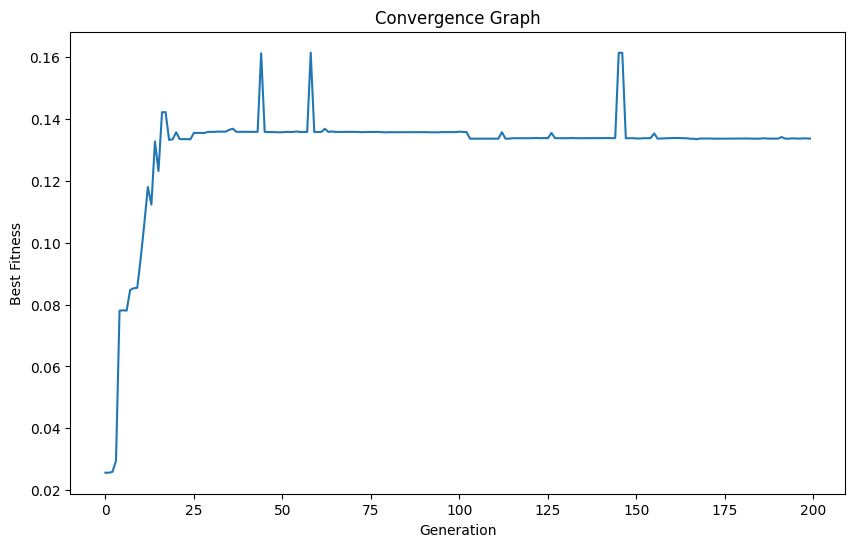

Best X: [0.0017578259111470373, 0.9686402026382641, -1.9870073471629883, -1.0137967971557398, 0.009492259920196311], Best Evaluation: 6.197078308597796, Best Fit: 0.16136636595501516
Run 1


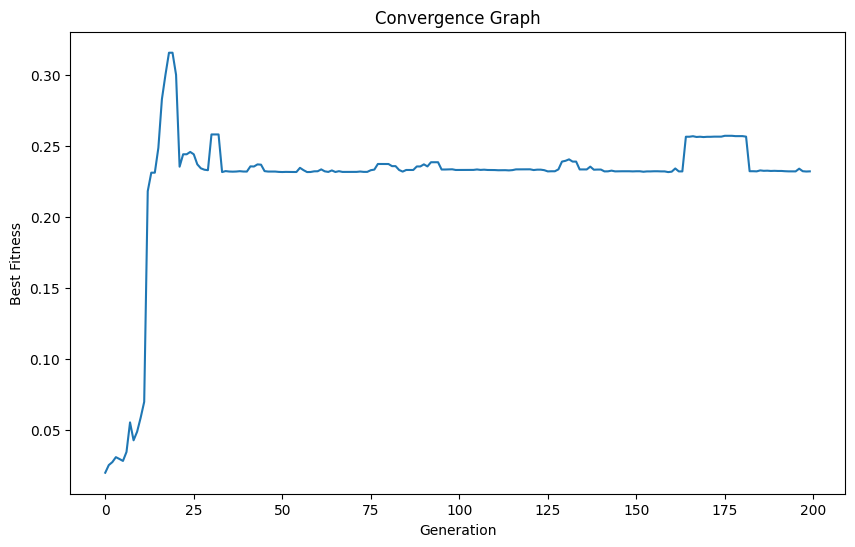

Best X: [0.008945380747839238, 1.049109566570789, -0.015429805220071202, 0.036445590557788954, -0.9577807447871765], Best Evaluation: 3.1655000623627956, Best Fit: 0.31590585483011463
Run 2


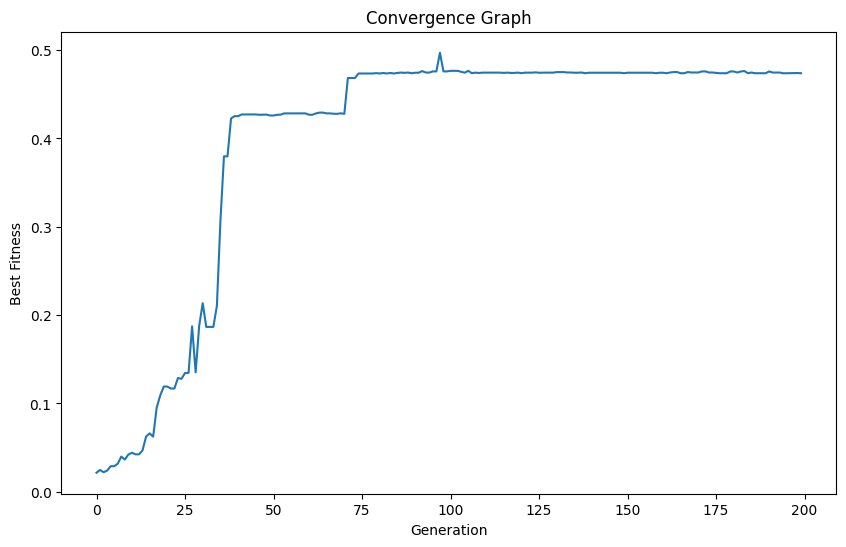

Best X: [-0.0020703282953515867, 0.008476627171533302, -0.0018359515071981747, 0.9898122391680841, 0.9929372630101243], Best Evaluation: 2.0117486666576525, Best Fit: 0.4970799874683962
Run 3


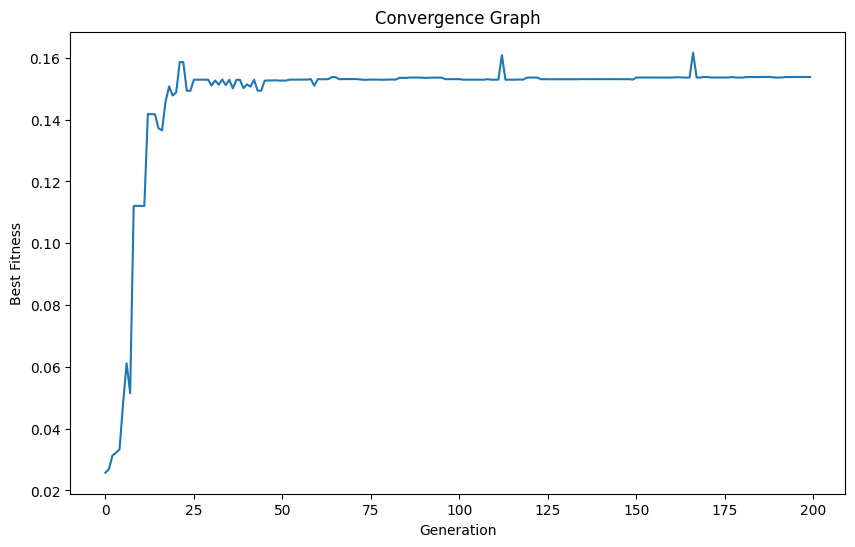

Best X: [-0.0005078163743315045, -1.0047342280138247, -1.95966338854514, -1.003874846457264, -0.0025390818716575225], Best Evaluation: 6.1857035375745255, Best Fit: 0.16166309945364973
Run 4


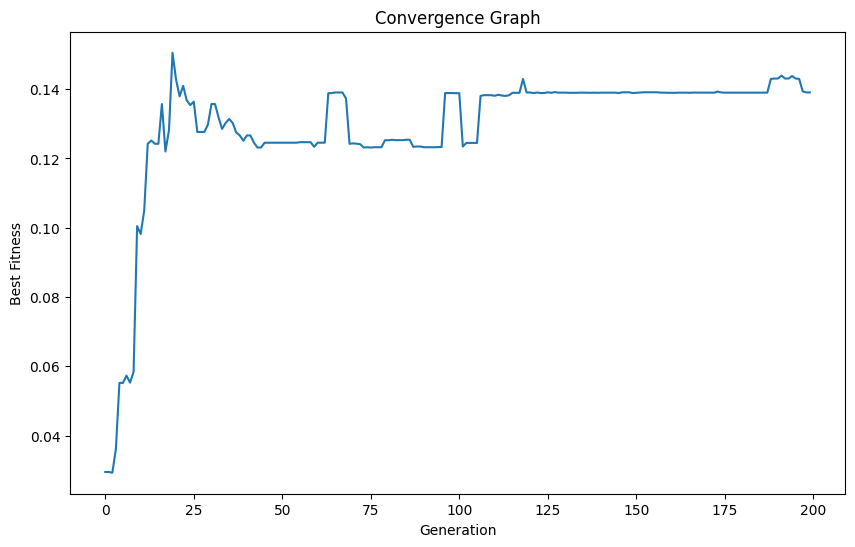

Best X: [0.9244992408694523, 0.025586132706701292, -0.0016015747190456509, -0.03003929168160724, -1.9448976508915017], Best Evaluation: 6.643562329456763, Best Fit: 0.15052165646278073
Run 5


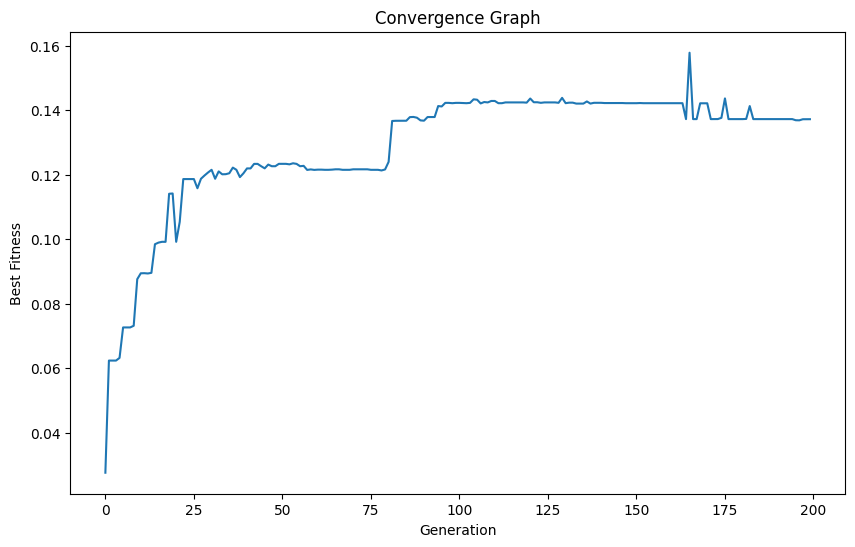

Best X: [-1.0148124299044028, -0.9826246843313928, 0.9517650738912495, 0.9447337702466596, -1.0394219926604666], Best Evaluation: 6.334806120362117, Best Fit: 0.15785802869648724
Run 6


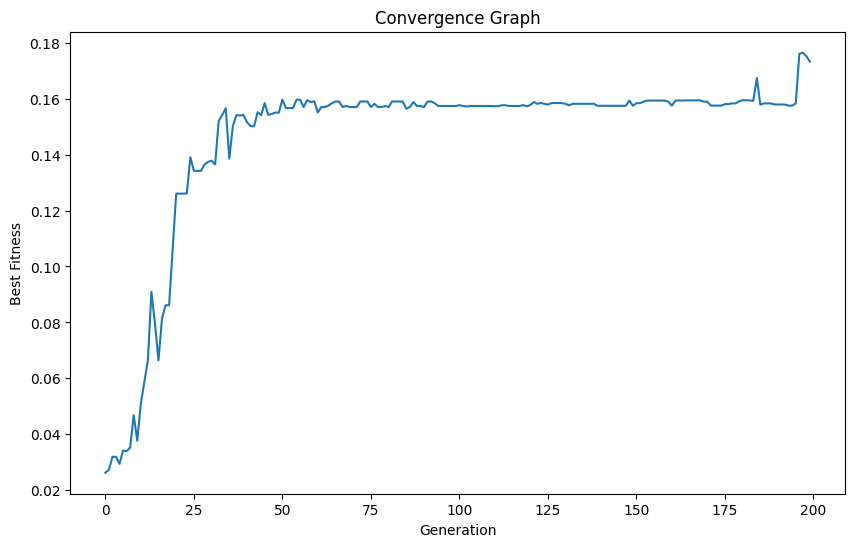

Best X: [0.02472675115013967, 0.02238298326860999, 0.02003921538708031, -2.008491886077012, -0.9543432185609326], Best Evaluation: 5.667551164962305, Best Fit: 0.17644304860443236
Run 7


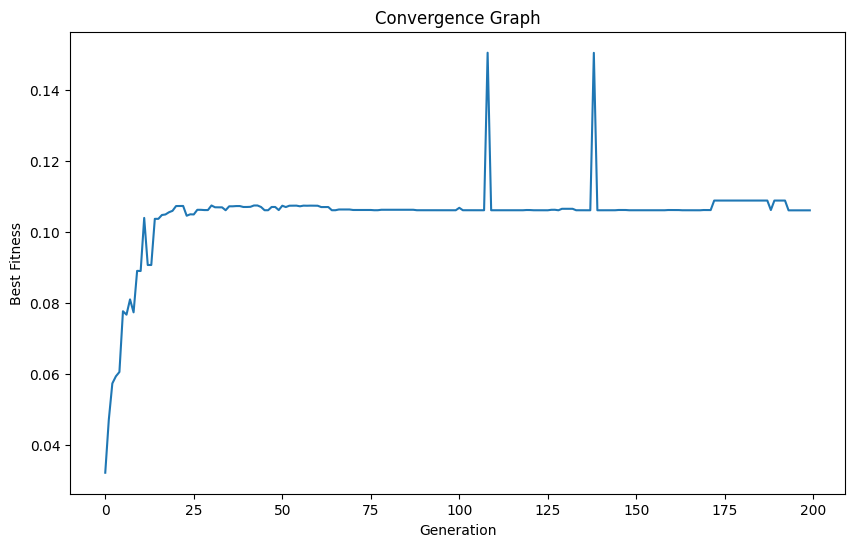

Best X: [-1.0127811644070777, 0.9608276430331646, 0.014414172471408193, 2.030054550587087, -0.009414134324145174], Best Evaluation: 6.640171640834318, Best Fit: 0.1505985177386958
Run 8


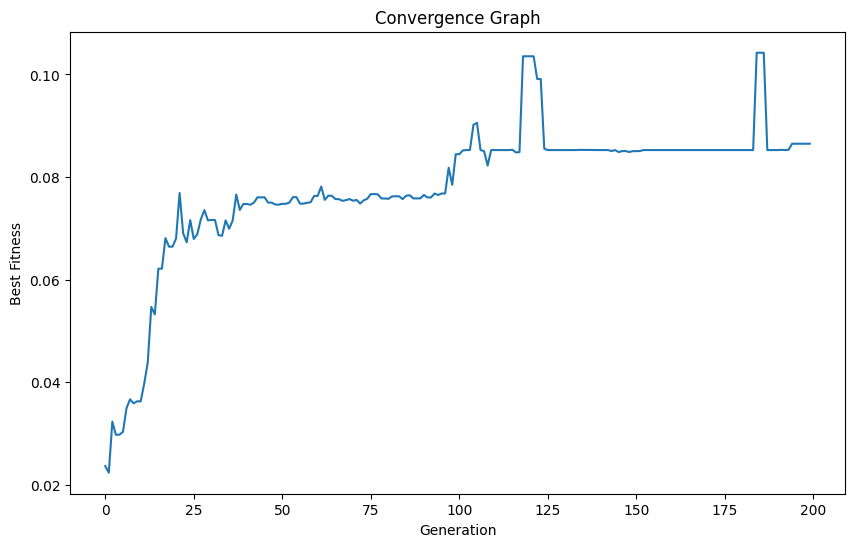

Best X: [-0.9809059212182714, 1.040125123024925, 2.113648938361652, 0.035117455424922284, 0.006289110482105009], Best Evaluation: 9.59410053973528, Best Fit: 0.10423072026944723
Run 9


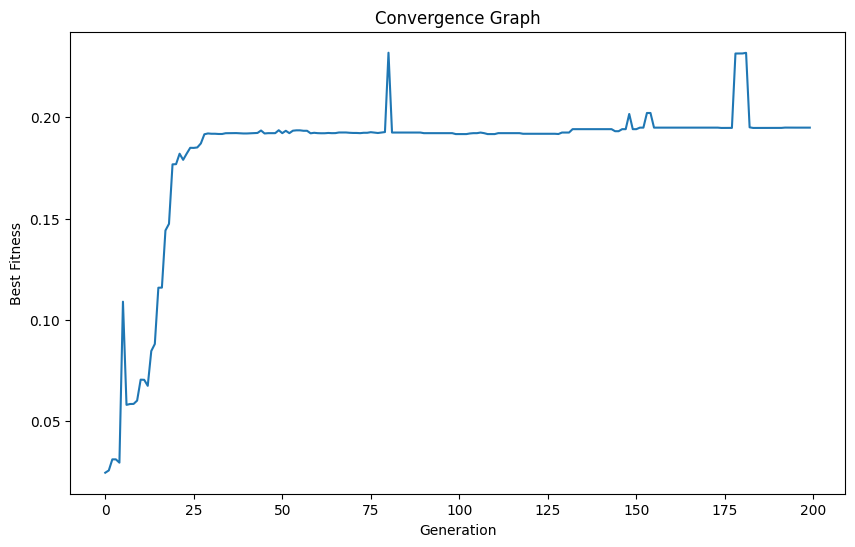

Best X: [0.9929372630101243, -0.984265321848464, -1.0006716970191727, -0.9558276048859016, -0.0018359515071981747], Best Evaluation: 4.311771485621378, Best Fit: 0.2319232379653022
Run 10


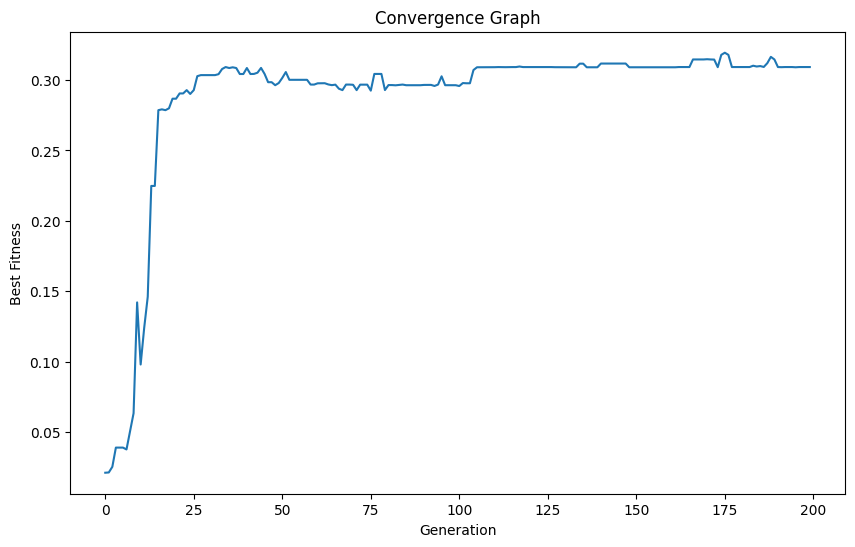

Best X: [0.02042984336733511, 0.016367312372683074, 0.9899684903601864, -0.9911403743009517, -0.9909841231088494], Best Evaluation: 3.1316264112359775, Best Fit: 0.31932289226573185
Run 11


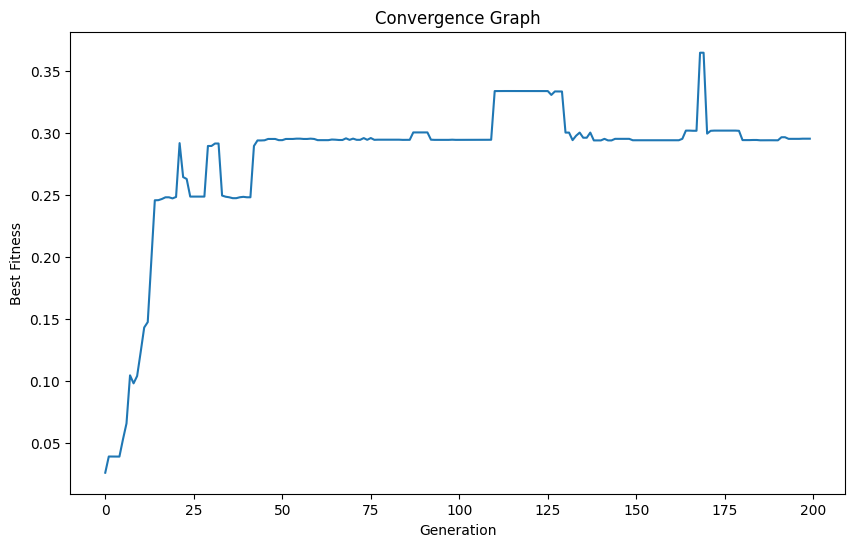

Best X: [-0.02105484813574332, -0.011367274225420054, 0.02207048088440633, -1.0069998702993033, 0.9437962630940477], Best Evaluation: 2.7414807431034944, Best Fit: 0.3647663786284453
Run 12


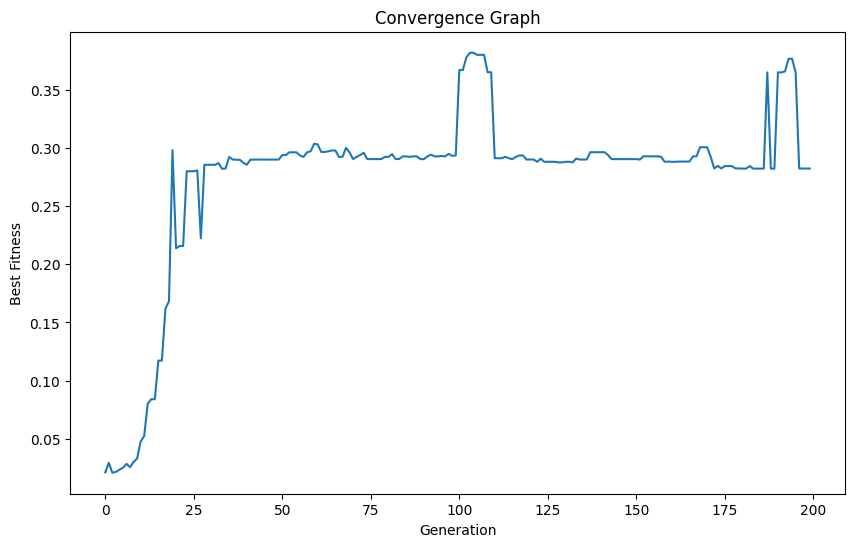

Best X: [-0.011367274225420054, 1.0323906890158767, -0.0016797003150967882, -0.9559838560780038, 0.011445399821471192], Best Evaluation: 2.61827906462144, Best Fit: 0.38193025950916454
Run 13


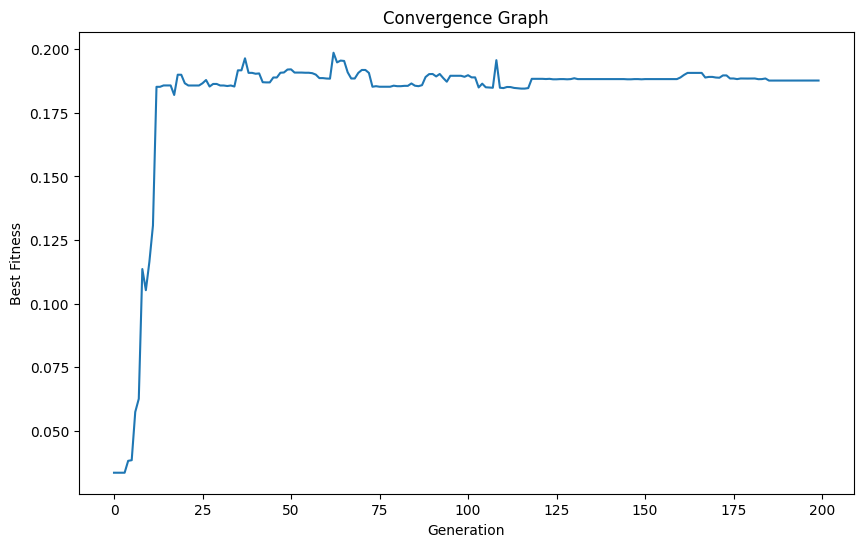

Best X: [-0.9659058067764805, -0.9633276621067974, 1.0107498989097508, 0.946999412532139, -0.03089867323816886], Best Evaluation: 5.033267646563473, Best Fit: 0.19867809050767055
Run 14


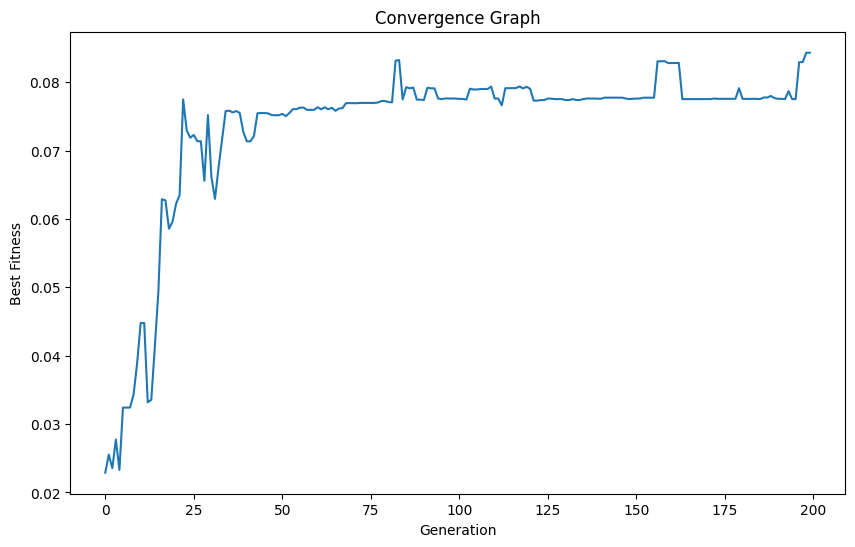

Best X: [1.0098123917571389, -1.9975543026298728, -1.0338750753408457, 1.044578281999832, -1.9703665952041263], Best Evaluation: 11.86070985558898, Best Fit: 0.08431198672223585
Run 15


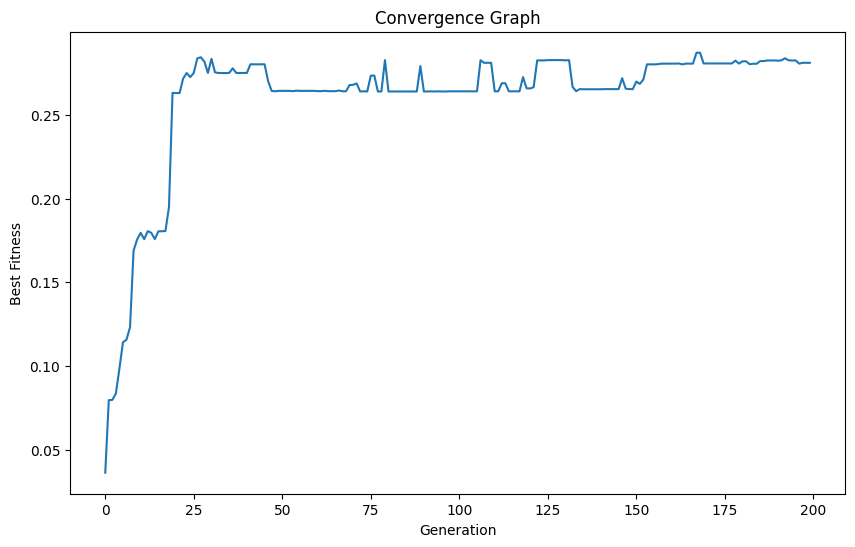

Best X: [-0.9918435046654102, 0.0033203378321671195, -0.016054809988479413, -1.0170780721898822, 1.0367657223947324], Best Evaluation: 3.4826450863263005, Best Fit: 0.2871380742783366
Run 16


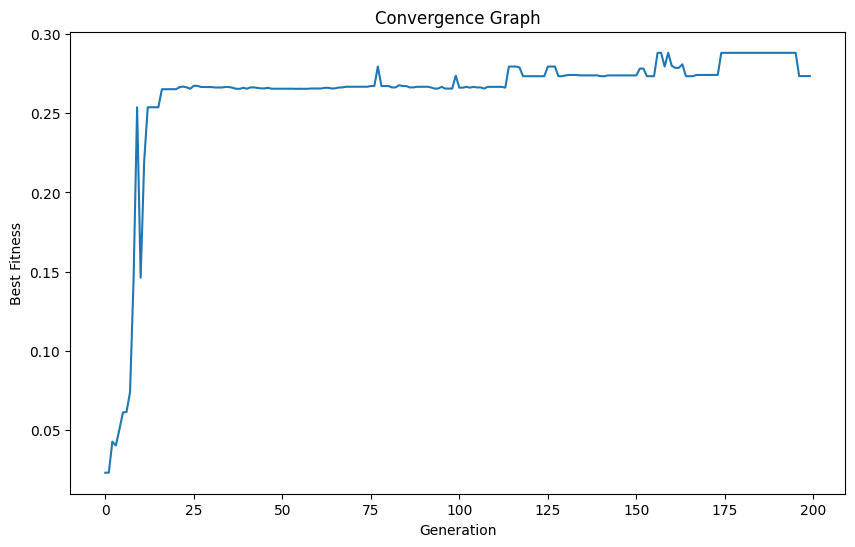

Best X: [0.013554790914847459, -0.9849684522129225, 0.954499469753034, -0.9726246080368659, 0.005976608097901348], Best Evaluation: 3.468760985664595, Best Fit: 0.2882873762710886
Run 17


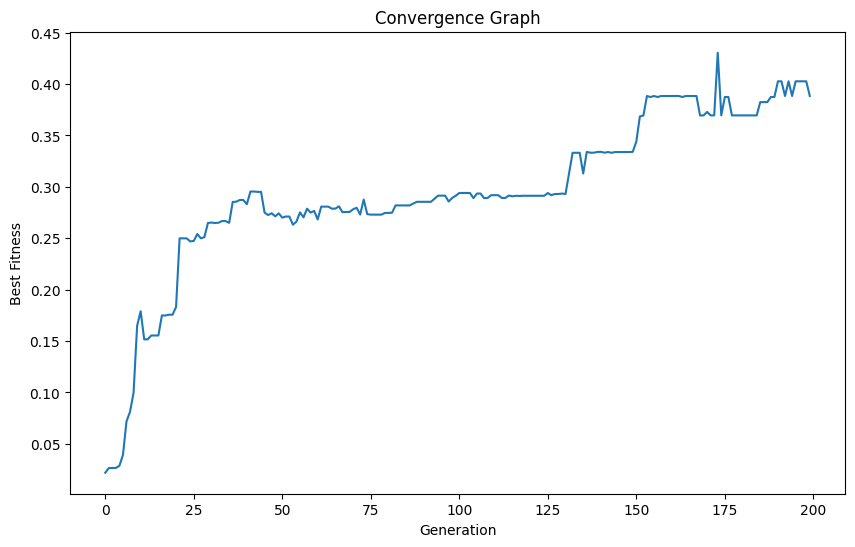

Best X: [0.9673120675053974, -0.012461032570133312, 0.9875465968826056, -0.001132821142739715, 0.0266017654553643], Best Evaluation: 2.3228243340329016, Best Fit: 0.430510386718146
Run 18


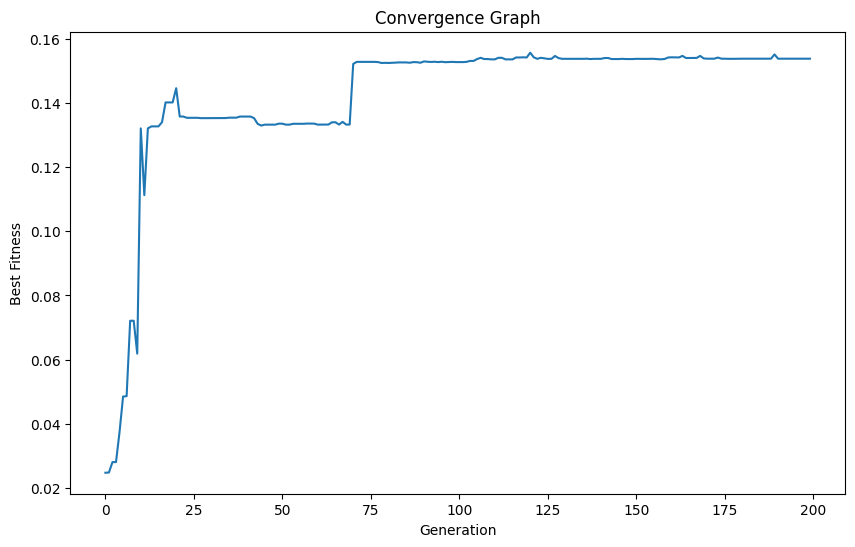

Best X: [0.9548119721372386, -0.9469212869360879, -0.9395774809072943, -1.0065311167229973, 1.01145302927421], Best Evaluation: 6.424967293568088, Best Fit: 0.15564281664531557
Run 19


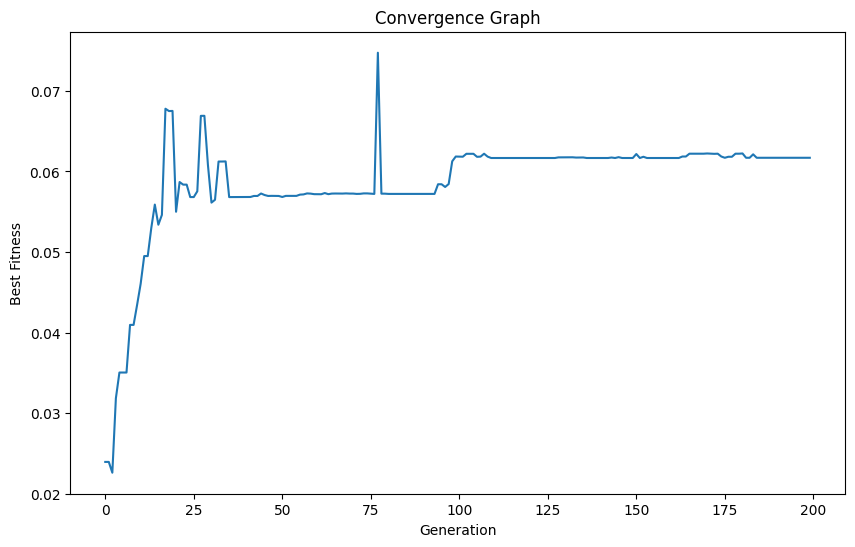

Best X: [0.08441470653310024, 1.913413035682951, -1.010359270929496, -2.074429889144052, 0.04902381152199986], Best Evaluation: 13.378011187609886, Best Fit: 0.0747495273665316
Mean Fitness: 0.23464641531784936
Standard Deviation: 0.1166412867926314
Min: 0.0747495273665316
Max: 0.4970799874683962


In [ ]:
#Parameters
miu = 100
upperBound = 5.12
lowerBound = -5.12
numBits = 17 #Using the formula from the slides
numGenerations = 200
pc = 0.9
numVariables = 5
pm = 1/(numVariables*numBits)
bestFitnessRunsProblem3Binary = []
bestPerGenerationperRunProblem3Binary = []

print("Problem 3, Rastringin n=5")
for i in range(20):
  print("Run", i)
  bestX, bestEvaluation, bestFit, bestPerGeneration = geneticAlgorithmBinary(miu, numBits, numGenerations, pc, pm, lowerBound, upperBound, rastringin, numVariables)
  bestFitnessRunsProblem3Binary.append(bestFit)
  bestPerGenerationperRunProblem3Binary.append(bestPerGeneration)
  print(f"Best X: {bestX}, Best Evaluation: {bestEvaluation}, Best Fit: {bestFit}")
print("Mean Fitness:", np.mean(bestFitnessRunsProblem3Binary, axis=0))
print("Standard Deviation:", np.std(bestFitnessRunsProblem3Binary, axis=0))
print("Min:", np.min(bestFitnessRunsProblem3Binary))
print("Max:", np.max(bestFitnessRunsProblem3Binary))

**Best Evaluation Real: 5.460165013460028e-07**

Best Evaluation Binary: 2.0117486666576525

Real encoding gave the best result for problems 1 and 3, while binary had the best for problem 2.

Talking about generations, in both cases spikes tend to happen between 75 and 100 generations with some outliers, so a value of 100 would be recommended just to be sure.

| Experiment           | Test problem 1 Real | Test problem 1 Binary | Test Problem 2 Real | Test Problem 2 Binary | Rastrigin function, n=5 Real | Rastrigin function, n=5 Binary |
|----------------------|---------------------|-----------------------|---------------------|-----------------------|-----------------------------|-------------------------------|
| Experiment 1         | 1360656.7682447478  | 11.235754739069849     | 415604.7960573741    | 1651653.5713846826     | 25816.99137446546            | 11.235754739069849            |
| Experiment 2         | 566875.8965442672   | 201.62237614032517     | 415604.7960573741    | 1.0049738247740196     | 11518.004185281392           | 201.62237614032517            |
| Experiment 3         | 406506.6525082947   | 5.882569571404447      | 415604.7960573741    | 1651653.5713846826     | 4367.152384917383            | 5.882569571404447             |
| Experiment 4         | 94389.87305898641   | 11.145089857147905     | 415604.7960573741    | 0.9988000023638118     | 3435.883503263059            | 11.145089857147905            |
| Experiment 5         | 47089.88303372437   | 24.700545735777062     | 415604.7960573741    | 1651653.5713846826     | 5597.113804918257            | 24.700545735777062            |
| Experiment 6         | 80155.94485160048   | 5.313011470372522      | 415604.7960573741    | 1.0048041950700357     | 1905.7844949961413           | 5.313011470372522             |
| Experiment 7         | 47007.174490479934  | 18.378609577534082     | 415604.7960573741    | 1651653.5713846826     | 3945.1132847258965           | 18.378609577534082            |
| Experiment 8         | 7846.534675575404   | 153.33048363068679     | 415604.7960573741    | 0.49665337528795794    | 1157.7938045729302           | 153.33048363068679            |
| Experiment 9         | 958364.8947073173   | 39.45908174459484      | 415604.7960573741    | 1.0046513545684923     | 7248.115437194838            | 39.45908174459484             |
| Experiment 10        | 32128.726294707158  | 1.7962443989275398     | 415604.7960573741    | 1.0048698672578926     | 1453.2845132647957           | 1.7962443989275398            |
| Experiment 11        | 39347.33165487965   | 12.407404902513557     | 415604.7960573741    | 1651653.5713846826     | 2156.0039284815904           | 12.407404902513557            |
| Experiment 12        | 167938.26586561944  | 19.467522999784272     | 415604.7960573741    | 1.0039015158475384     | 3824.0194858724364           | 19.467522999784272            |
| Experiment 13        | 2760.755115719916   | 16.25250868407093      | 415604.7960573741    | 1651653.5713846826     | 2485.8927460014905           | 16.25250868407093             |
| Experiment 14        | 271648.48288095515  | 37.022955835846524     | 415604.7960573741    | 0.9995712933842174     | 5234.003282591783            | 37.022955835846524            |
| Experiment 15        | 162754.00677530456  | 1.7511004374851253     | 415604.7960573741    | 1.0042027111880831     | 3127.4875859382184           | 1.7511004374851253            |
| Experiment 16        | 10386.707568119753  | 4.19197527159544       | 415604.7960573741    | 1651653.5713846826     | 1728.9441936783077           | 4.19197527159544              |
| Experiment 17        | 1209196.101443782   | 27.693462981939177     | 415604.7960573741    | 0.9998913621588896     | 6782.874923572883            | 27.693462981939177            |
| Experiment 18        | 52382.18406038845   | 6.651469086392049      | 415604.7960573741    | 1651653.5713846826     | 1539.778193510221            | 6.651469086392049             |
| Experiment 19        | 66176.27074549149   | 52.00469296412736      | 415604.7960573741    | 1.0043911395962752     | 4896.453768492183            | 52.00469296412736             |
| Experiment 20        | 35666.629742613186  | 20.65174939301588      | 415604.7960573741    | 1651653.5713846826     | 2678.0047892364814           | 20.65174939301588             |
| Mean                 | 280963.9542131288   | 33.54793047113053      | 415604.7960573741    | 743244.6334586393      | 4311.904368125952            | 33.54793047113053             |
| Standard Deviation    | 406151.80759833765  | 50.30135884246721      | 0.0                 | 821686.8009016258      | 3965.7480854147637           | 50.30135884246721             |
| Min                  | 2760.755115719916   | 1.7511004374851253     | 415604.7960573741    | 0.49665337528795794    | 1157.7938045729302           | 1.7511004374851253            |
| Max                  | 1360656.7682447478  | 201.62237614032517     | 415604.7960573741    | 1651653.5713846826     | 25816.99137446546            | 201.62237614032517            |
| Best Evaluation       | 7.349392024044421e-07 | 0.08900158674803776 | 0.004164278890295366 | 6.054538417288313e-07  | 7.349392024044421e-07        | 0.08900158674803776           |


# 4. Comparison with previously used methods

In [ ]:
#Find the twoNorm (Euclidean distance between two solution vectors)
def twoNorm(xSol, xReal):
  return np.sqrt((xSol[0]-xReal[0])**2 + (xSol[1]-xReal[1])**2)

In [ ]:
def wolfeConditions(stepSize, currentSolution, objectiveFunction, direction, jacobian, gradient):
  c1 = 1e-4
  c2 = 0.9
  functionCurrent = objectiveFunction(currentSolution) #Evaluate the function
  fun = 1 #Number of function evaluations
  jac = 0 # Number of jacobian evaluations
  flag = False # Set flag for wolfe conditions
  while not flag:
    if objectiveFunction(currentSolution+stepSize*direction) > functionCurrent + c1*np.dot(stepSize,(np.matmul(gradient, direction))): #Sufficient decrease condition
      stepSize = stepSize / 2
      fun += 1
    elif np.dot(jacobian(currentSolution+stepSize*direction), direction) < np.dot(c2, np.matmul(gradient, direction)): #Curvature conditon
      stepSize = stepSize * 2
      jac += 1
    else:
      flag = True
  return stepSize, fun, jac

In [ ]:
def gradientDescent(objectiveFunction, jacobian, currentSolution, stepSize=0.1, maxIter = 1000, tolerance=1e-6):
  path = [currentSolution]
  evaluations = {"Function": 0, "Jacobian": 0}

  for i in range(maxIter):
    gradient = jacobian(currentSolution) #Get the evaluation of the first derivative with the current solution
    evaluations["Jacobian"] += 1
    direction = -gradient
    stepSize, fun, jac = wolfeConditions(stepSize, currentSolution, objectiveFunction, direction, jacobian, gradient) #Wolfe conditions to check step size
    lastSolution = currentSolution
    currentSolution = currentSolution + stepSize*direction #Update solution
    path.append(currentSolution)
    evaluations["Function"] += fun
    evaluations["Jacobian"] += jac
    if twoNorm(currentSolution, lastSolution)<tolerance:
      break

  evaluations["Iterations"] = i+1

  return currentSolution, path, evaluations

In [ ]:
def newtonMethod(objectiveFunction, jacobian, hessian, currentSolution, maxIter = 1000, tolerance=1e-6):
  path = [currentSolution]
  evaluations = {"Function": 0, "Jacobian": 0, "Hessian": 0}

  for i in range(maxIter):
    currentEvaluation = objectiveFunction(currentSolution)
    evaluations["Function"] += 1
    gradient = jacobian(currentSolution) #Get the evaluation of the first derivative with the current solution
    evaluations["Jacobian"] += 1
    hessianMatrix = hessian(currentSolution) #Get the evaluation of the second derivative with the current solution
    evaluations["Hessian"] += 1
    lastSolution = currentSolution
    direction = -np.matmul((np.linalg.inv(hessianMatrix)), gradient)
    currentSolution = currentSolution + direction #We don't need to select step size because we are also using the second derivative
    path.append(currentSolution)
    if twoNorm(currentSolution, lastSolution)<tolerance:
      break

  evaluations["Iterations"] = i

  return currentSolution, path, evaluations

In [ ]:
solution1, path1, evaluations1 = gradientDescent(function1, jacobian1, np.random.uniform(-2.048, 2.048, (2)))
print(f"The solution obtained for 1 with the gradient descent algorithm was x1= {solution1[0]}, x2= {solution1[1]}.\nThe obtained value was {function1(solution1)}, it took {evaluations1['Function']} function evaluations and {evaluations1['Jacobian']} evaluations from the derivative")
solution1Newton, path1Newton, evaluations1Newton = newtonMethod(function1, jacobian1, hessian1, np.random.uniform(-2.048, 2.048, (2)))
print(f"The solution obtained for 1 with the Newton method was x1={solution1Newton[0]}, x2={solution1Newton[1]}.\nThe obtained value was {function1(solution1Newton)}, it took {evaluations1Newton['Function']} function evaluations, {evaluations1Newton['Jacobian']} evaluations from the derivative, and {evaluations1Newton['Hessian']} evaluations from the second derivative")


The solution obtained for 1 with the continuous hill climbing algorithm was x1= 1.0000292681071836, x2= 1.0000591758581059.
The obtained value was 8.974269961372093e-10, it took 16319 function evaluations
The solution obtained for 1 with the gradient descent algorithm was x1= 0.9374880361804706, x2= 0.8784342287539845.
The obtained value was 0.003927958667925336, it took 1291 function evaluations and 1285 evaluations from the derivative
The solution obtained for 1 with the Newton method was x1=1.0, x2=1.0.
The obtained value was 0.0, it took 6 function evaluations, 6 evaluations from the derivative, and 6 evaluations from the second derivative


In [ ]:
solution2, path2, evaluations2 = gradientDescent(function2, jacobian2, np.random.uniform(-5.12, 5.12, (2)))
print(f"The solution obtained for 2 with the gradient descent algorithm was x1= {solution2[0]}, x2= {solution2[1]}.\nThe obtained value was {function2(solution2)}, it took {evaluations2['Function']} function evaluations and {evaluations2['Jacobian']} evaluations from the derivative")
solution2Newton, path2Newton, evaluations2Newton = newtonMethod(function2, jacobian2, hessian2, np.random.uniform(-5.12, 5.12, (2)))
print(f"The solution obtained for 2 with the Newton method was x1={solution2Newton[0]}, x2={solution2Newton[1]}.\nThe obtained value was {function2(solution2Newton)}, it took {evaluations2Newton['Function']} function evaluations, {evaluations2Newton['Jacobian']} evaluations from the derivative, and {evaluations2Newton['Hessian']} evaluations from the second derivative")


The solution obtained for 2 with the continuous hill climbing algorithm was x1= 2.9848610136993923, x2= -2.9848619561618213.
The obtained value was 17.909202496275785, it took 525473 function evaluations
The solution obtained for 2 with the gradient descent algorithm was x1= 1.9899121772790067, x2= -4.974691450697233.
The obtained value was 28.85355412509764, it took 14 function evaluations and 9 evaluations from the derivative
The solution obtained for 2 with the Newton method was x1=-2.984855701039481, x2=-1.5076407318703584.
The obtained value was 31.21606012629293, it took 5 function evaluations, 5 evaluations from the derivative, and 5 evaluations from the second derivative


### Problem 1 Comparison

| Algorithm                     | x1                 | x2                 | Obtained Value               | Function Evaluations        | Derivative Evaluations |
|-------------------------------|--------------------|--------------------|------------------------------|-----------------------------|------------------------|
| Genetic Algorithm (GA)     | 0.99924            | 0.99845            | 7.34939e-07              | -                           | -                      |
| Gradient Descent               | 0.93749            | 0.87843            | 0.003928                     | 1,291                       | 1,285                  |
| **Newton's Method**            | 1.00000            | 1.00000            | **0.0**                      | -                           | -                      |

### Problem 2 Comparison

| Algorithm                     | x1                 | x2                 | Obtained Value               | Function Evaluations        | Derivative Evaluations |
|-------------------------------|--------------------|--------------------|------------------------------|-----------------------------|------------------------|
| **Genetic Algorithm (GA)**     | 3.90628e-05        | -3.90628e-05       | **6.05454e-07**              | -                           | -                      |
| Gradient Descent               | 1.98991            | -4.97469           | 28.85355                     | 14                          | 9                      |
| Newton's Method                | -2.98486           | -1.50764           | 31.21606                     | 5                           | 5                      |


The first problem had the best solution with Newton Method, closely followed by GA with real encoding which had a value of 7.349392024044421e-07, so there's a very small difference with the optimal solution. Newton Method would be recommended since it converges on the optimal result but GA still does a great work.

Problem 2 had the best solution with the GA with binary encoding by a wide margin, since traditional methods tend to get stuck on local optima, this may be because the selections methods used don't always go for the best individual. Mutation and crossover probabilities may also have some influence on this.



# 7. Future work

Combining derivative-based methods like Gradient Descent or Newton’s Method with a Genetic Algorithm (GA) to improve the efficiency and accuracy of the optimization process, especially in complex problems where there are many local optima which can be troublesome for derivative based methods and Genetic Algorithms may prevent them from getting stuck.

As was seen, Genetic Algorithms are good at searching for a solution without getting stuck on local optima, but they are not as good for fine-tuning, whereas, for example, the Newton Method got the exact best solution.

By combining the two GA to perform a broad search, identifying promising regions of the solution space. And then, derivative-based methods can look to find the optimal solution within there.

An algorithm like this then would first run a GA like normal and after that select the best individuals as starting point to run a derivative-based method to fine-tune the solution.